In [1]:

import sys
from pathlib import Path
from datetime import datetime

from matplotlib import pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np
# import time
# import shap


# Add the folder containing 'my_functions.py' to sys.path
sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))

# Import the module or specific functions
# from /home/michalula/code/epiCausality/epiCode/utils/funcs_extract_mC_profiles_from_BAMs.py
# from funcs_extract_mC_profiles_from_BAMs import system_info, extract_from_bam
from funcs_extract_mC_profiles_from_BAMs import (
    system_info,
    get_reference_sequence,
    create_output_directory,
    extract_from_bam,
    process_extracted_reads,
    visualize_data,
    create_padded_reads,
    plot_padded_reads,
    save_padded_reads,
    remove_low_methylated_reads,
    process_extracted_reads_no_fully_unmethylated,
    create_padded_reads_no_fully_unmethylated
    # main,
)
from funcs_analize_forward_reverse_extracted_mC_reads import analize_forward_reverse_CGs_pipeline

modkit found with expected version 0.2.4


In [2]:
system_info()
date_today = datetime.today().strftime('%Y-%m-%d')
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta')
reg_genome_version = "t2t_v2_0"
region_chr = 'chr1'

# 6500bps: EXACT cutting region  
# chr1:206,583,334-206,589,873
region_start = 206583334    + 20
region_end = 206589874      - 20 
# CD55 TSS start: chr1:206586828-206606065 (+)
# (before TSS: 3474, after TSS: 3026 bps)

region_str = region_chr + ":" + str(region_start) + "-" + str(region_end) #'chr1:206586162-206586192'
region_length = region_end - region_start
print("region_length", region_length)


motifs=['CG,0']
ref_seq_list = get_reference_sequence(ref_genome_path, region_chr, region_start, region_end)

print('region_chr', region_chr)
print('region_start', region_start)
print('region_end', region_end)
print(f'{region_chr}:{region_start}-{region_end}') 

System: Linux
Release: 6.8.0-60-generic
Version: #63~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Tue Apr 22 19:00:15 UTC 2
Processor: x86_64
Python version: 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]
region_length 6500
GTCATTGTATGGTTCCTGGGATAAGAGTAAGAACCGTGGTCCCTTGCTCTGTCAAAATCATAAACCTATTTTCTTTGTATTTTGACTTAATTACATAAGCTTGTTTTGGATTGGAAGGTCTATAGAGACTATTTTAGTGCCAAATGCTATTTAATCAATGCAGAAATAAGCCCTTGAGAGGTGCAGTGACTCAGCTGAGGACACACTGATAGTTTCTGGTAGATAAGTATGAAGCCTTGGAACTACTTCTCATATCATAAGCCCCTGGGTTCCCAAATCACCTCCCCAAGTACCTAATTCATCATCCTCTGCATACAAGAAATTTTTGCTCATTCCAATAAAAAGAATGTAGTACGGCAGGACAGGAGAAGTACAGGTTTTGGAATCAAACTAGGTTTAGATTCTGACCTGGTCGCTAGTTAGTGCATGGGCTTTGGTAAACAGCCTCTCAGCCTGTTTCCTTGTCTGCAAAATATGGATAGTTATCTTCACTTCATGAAGTTGTGTTGGTGAAATGGTATAATGTGTATAAAGCAACTGGAACACAACAAATGAGGCCATTTATTTAAAATAATCTTTAGTAAGTTATAAATTCACATATTTGCTTTTTTCTGAGGAATGCTTAGATTTTATCATAGATCTCTTTTCTAAATTGAGTAAATACATAGTGGATTTCTTTGTTTCCTTCCCCTCAGAATGTTGAAATTTGGCTGATTGTAACTATTACTTAAGACTCTATCCAGTAATTGTTCGTA

In [3]:
! ls /home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9/pod5_converted_basecall/5mCG/to_t2t_v2_0/

align_t2t_v2_0_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam
chr1_206560169_206614236.sort_align_t2t_v2_0_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam
chr1_206560169_206614236.sort_align_t2t_v2_0_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam.bai
fixed_variants.chr1_206560169_206614236.vcf.gz
fixed_variants.chr1_206560169_206614236.vcf.gz.csi
script_t2t_v2_align.bash
sort_align_t2t_v2_0_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam
sort_align_t2t_v2_0_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam.bai
summary_sort_align_t2t_v2_0_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.tsv
vcf.chr1_206560169_206614236.chr1_206560169_206614236.sort_align_t2t_v2_0_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.vcf.gz
vcf.chr1_206560169_206614236.chr1_206560169_206614236.sort_align_t2t_v2_0

In [4]:
# Look at CRISPRoff Silenced T cells at day 6 post EP (with no proteins)

folder_path = "/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9/pod5_converted_basecall/5mCG/to_t2t_v2_0/"
bam_name = "chr1_206560169_206614236.sort_align_t2t_v2_0_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"
unedit_bam_path = folder_path + bam_name

# Unedited cells:
#   day 28: "/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_UNEDITED_Day28/merged_outputs/5mCG/to_t2t_v2_0/sort_align_t2t_v2_0_trim_20250721_nCATs_Tcells_UNEDITED_Day28_minion_merged_flowcells_output.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"
#   day 6:  "/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TcellsPrES_unedit_P2R9/passed_fast5/5mCG/to_t2t_v2_0/sort_align_t2t_v2_0_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"
unedit_bam_path

'/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9/pod5_converted_basecall/5mCG/to_t2t_v2_0/chr1_206560169_206614236.sort_align_t2t_v2_0_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam'

# --------------------------------------

# mC confidence in calling > 99.5%

In [5]:
! pwd

/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/croff


In [6]:
unedit_bam_path

'/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9/pod5_converted_basecall/5mCG/to_t2t_v2_0/chr1_206560169_206614236.sort_align_t2t_v2_0_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam'

experiment_name =  day6_CRoff_D6_chr1_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2
Region length: 6500
No specified number of cores requested. 24 available on machine, allocating all.
Modification threshold of 0.995 will be treated as coming from range 0-1.


          | Step 1: Identify motif locations in up_chm13v2.0.fasta   0% | 00:00

          | Step 2: Parse regions in chr1_206560169_206614236.sort_align_t2t_v2_0_trim_20241226_MR_nCATs_TPrES…

          |    0%

          | Transferring 10130 from reads.CG,0.txt into reads.combined_basemods.h5, new size 10130   0% | 00:0…

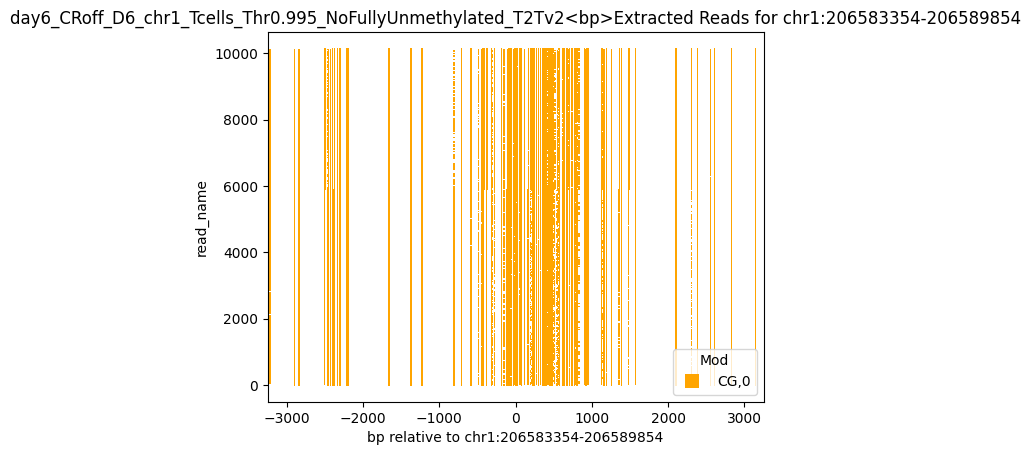

Found read coordinates: 10130 reads
Unique read names with methylation: 9724
Found 3453 reads with full coverage
Reads with methylation data: 9724
Overlap between full coverage and methylation: 3367
After full coverage filtering: 93275 reads with methylation data
Final result: 93275 reads with methylation information out of 10130 total reads


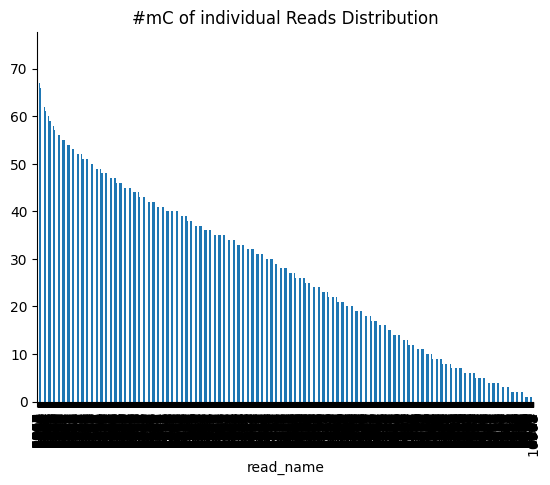

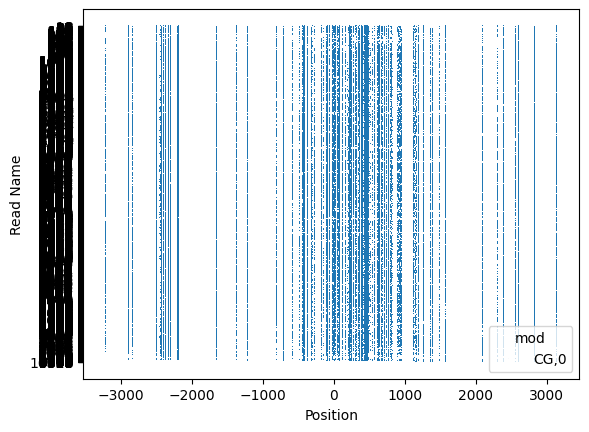

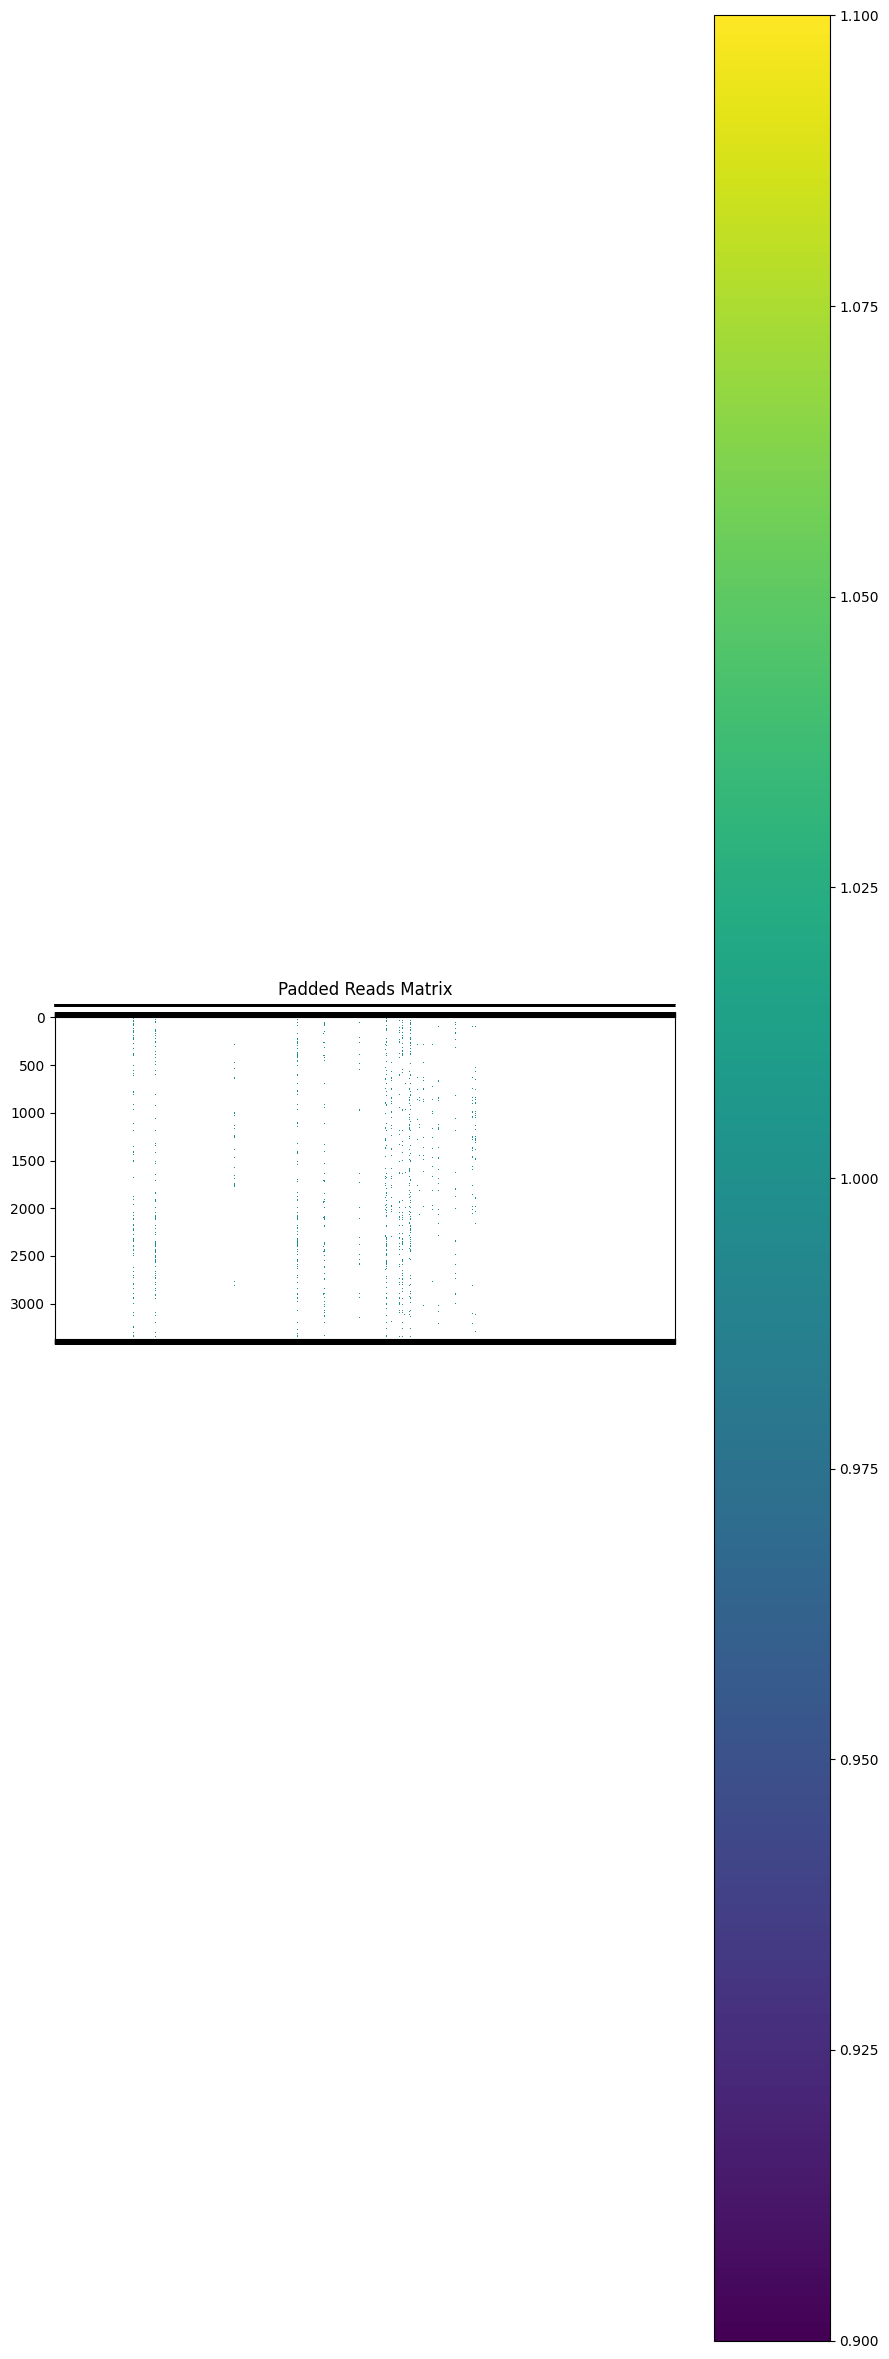

Padded reads saved to padded_reads_day6_CRoff_D6_chr1_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2_mCthresh0.995_t2t_v2_0_chr1:206583354-206589854_2025-08-04.npy
Padded reads loaded successfully.


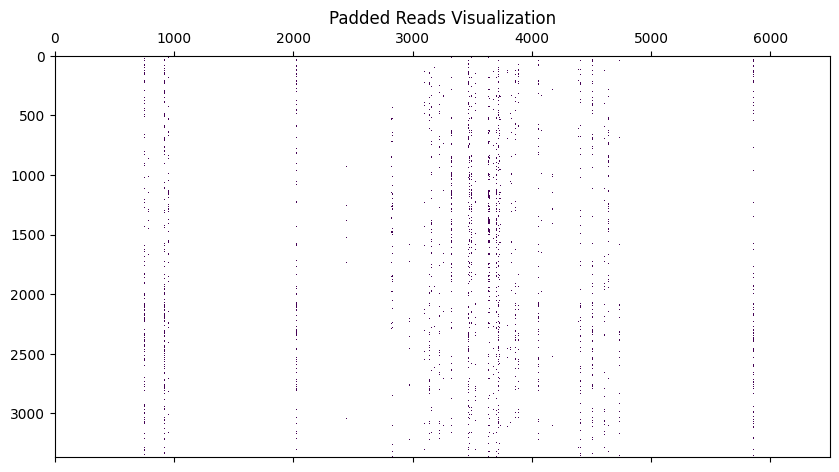

Visualization completed.
Region length: 6500
GTCATTGTATGGTTCCTGGGATAAGAGTAAGAACCGTGGTCCCTTGCTCTGTCAAAATCATAAACCTATTTTCTTTGTATTTTGACTTAATTACATAAGCTTGTTTTGGATTGGAAGGTCTATAGAGACTATTTTAGTGCCAAATGCTATTTAATCAATGCAGAAATAAGCCCTTGAGAGGTGCAGTGACTCAGCTGAGGACACACTGATAGTTTCTGGTAGATAAGTATGAAGCCTTGGAACTACTTCTCATATCATAAGCCCCTGGGTTCCCAAATCACCTCCCCAAGTACCTAATTCATCATCCTCTGCATACAAGAAATTTTTGCTCATTCCAATAAAAAGAATGTAGTACGGCAGGACAGGAGAAGTACAGGTTTTGGAATCAAACTAGGTTTAGATTCTGACCTGGTCGCTAGTTAGTGCATGGGCTTTGGTAAACAGCCTCTCAGCCTGTTTCCTTGTCTGCAAAATATGGATAGTTATCTTCACTTCATGAAGTTGTGTTGGTGAAATGGTATAATGTGTATAAAGCAACTGGAACACAACAAATGAGGCCATTTATTTAAAATAATCTTTAGTAAGTTATAAATTCACATATTTGCTTTTTTCTGAGGAATGCTTAGATTTTATCATAGATCTCTTTTCTAAATTGAGTAAATACATAGTGGATTTCTTTGTTTCCTTCCCCTCAGAATGTTGAAATTTGGCTGATTGTAACTATTACTTAAGACTCTATCCAGTAATTGTTCGTAAAATTTCTTTTCTTTTTTTTTTTTTGAGACGGAGTTTTGCTCTCGTCCCCCAGGCTGGAGTGCAATGGCGCGATCTTGGCTCACTGCAACCTCCGCCTCCCAGGTTCAAGTGATTCTCCCGCCTCAGCCTCCCAAGTAGCTGGGATTACAGGCACCTGCCACAACGCCCAGCCAATTTTTGTATTTTTAGTAGAGACGGG

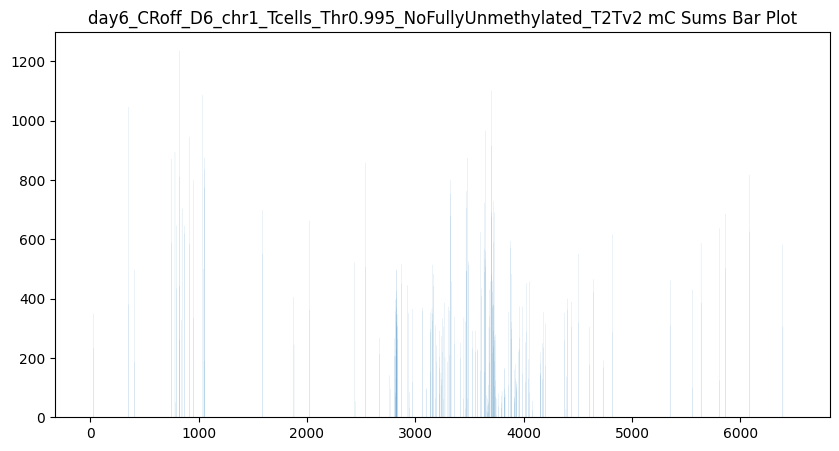

(mC_sums / len(CGs_all) = [0. 0. 0. ... 0. 0. 0.]


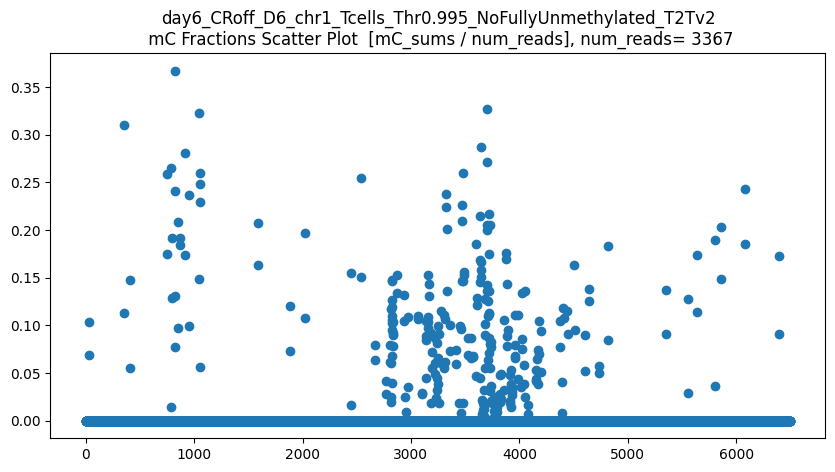

len(CGs_all) = 3367
CGs_all.shape = (3367, 137)
len(CGs_all_on_fwd_C_sums) = 6500
CGs_all_on_fwd_C_sums.shape = (6500,)


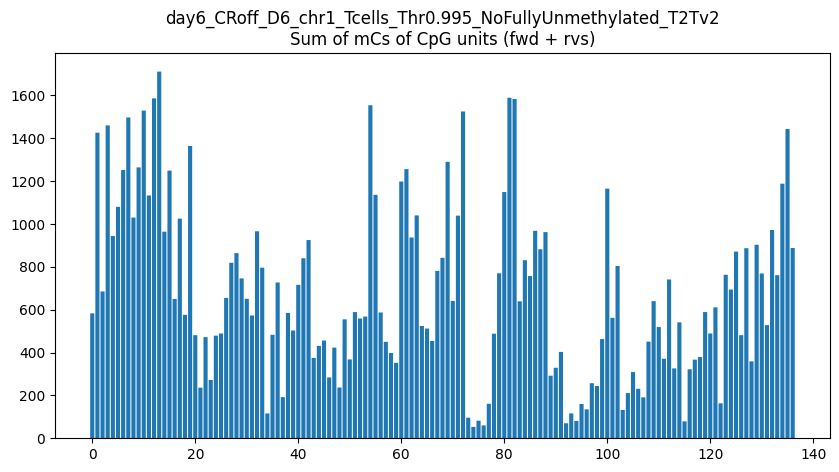

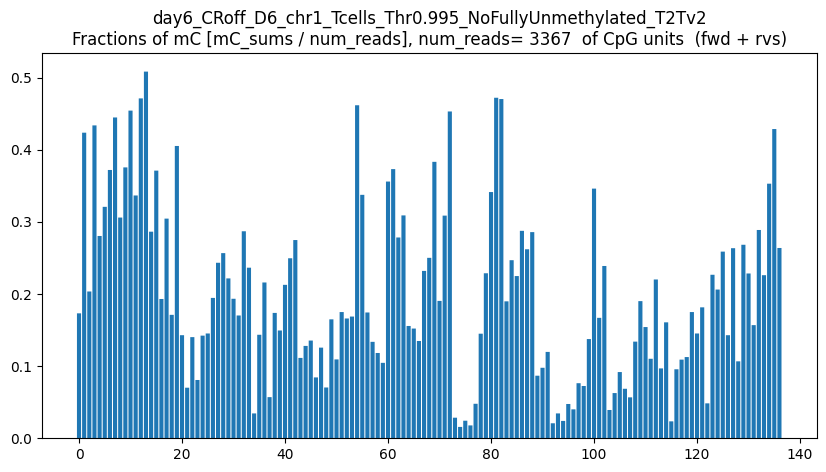

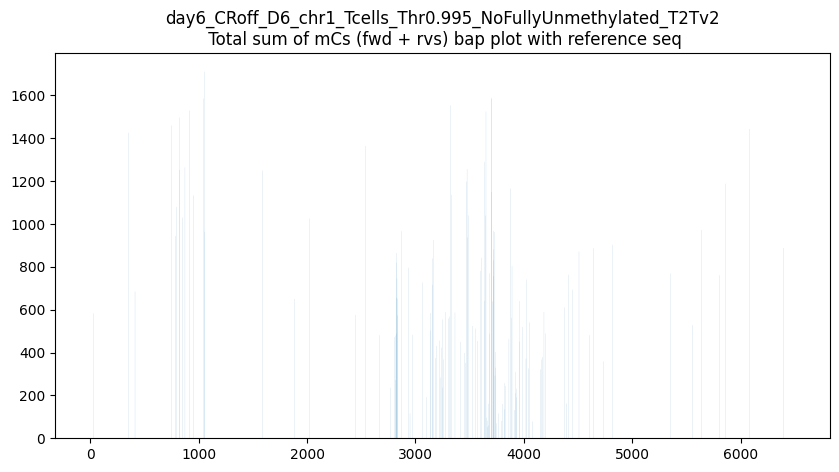

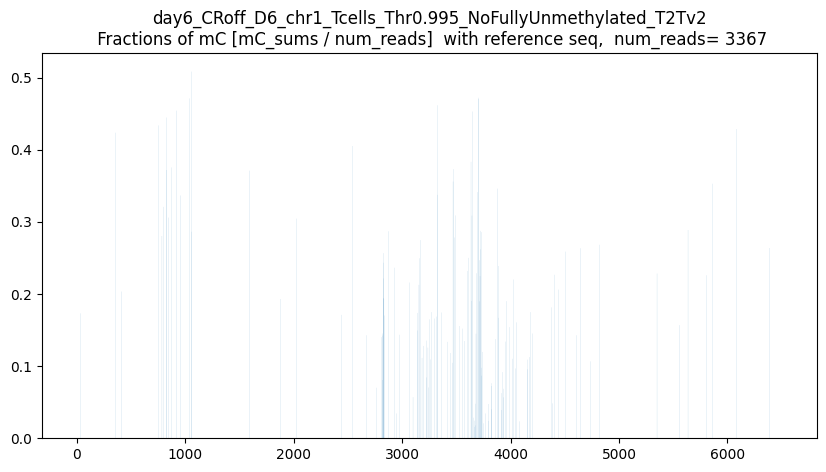

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



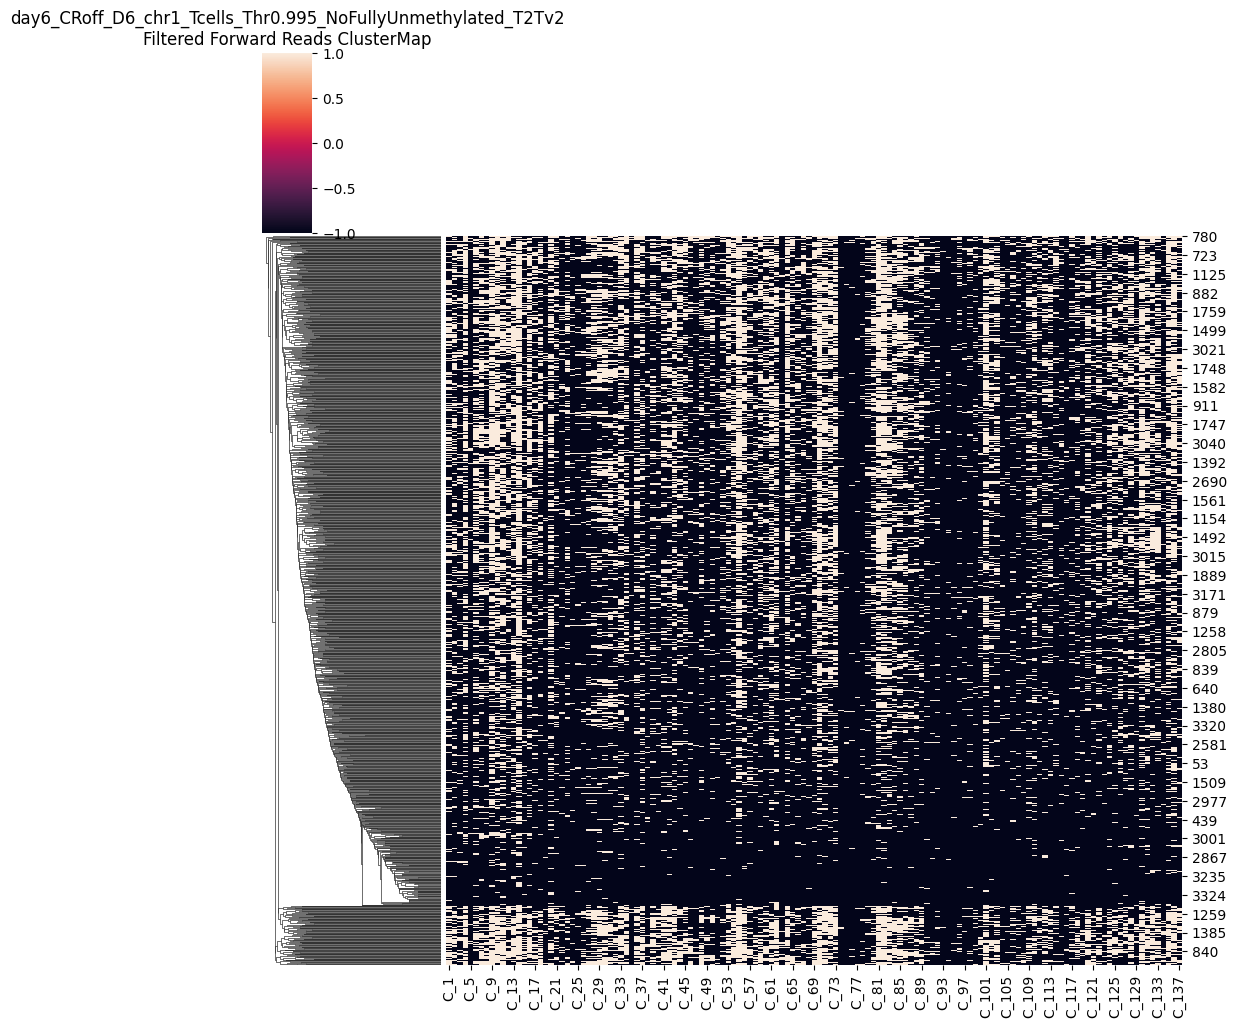

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



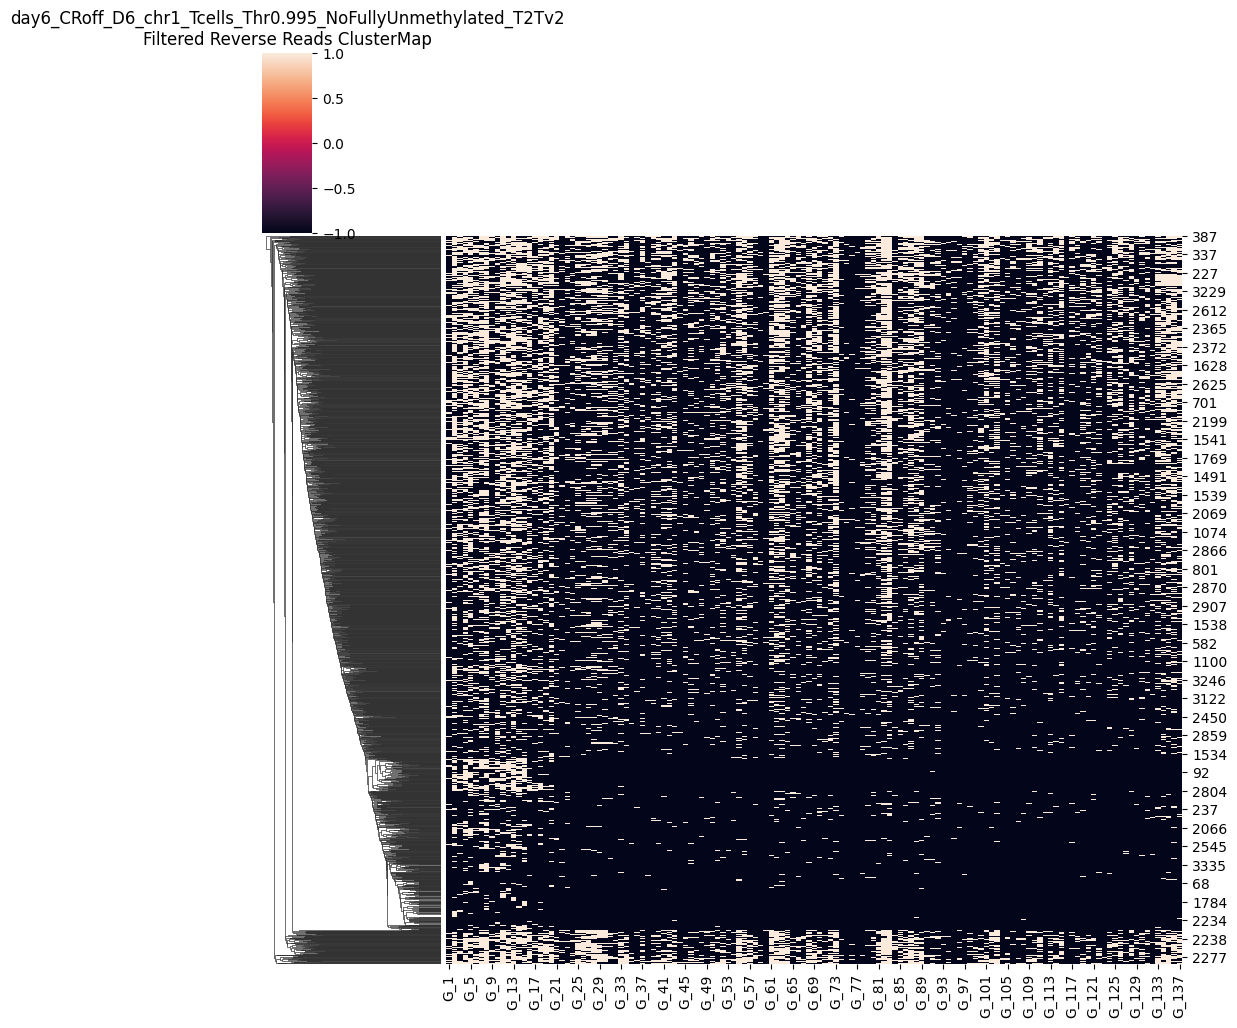

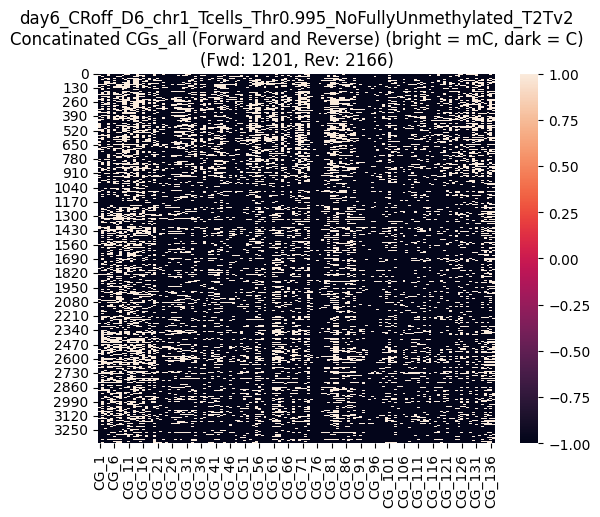

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



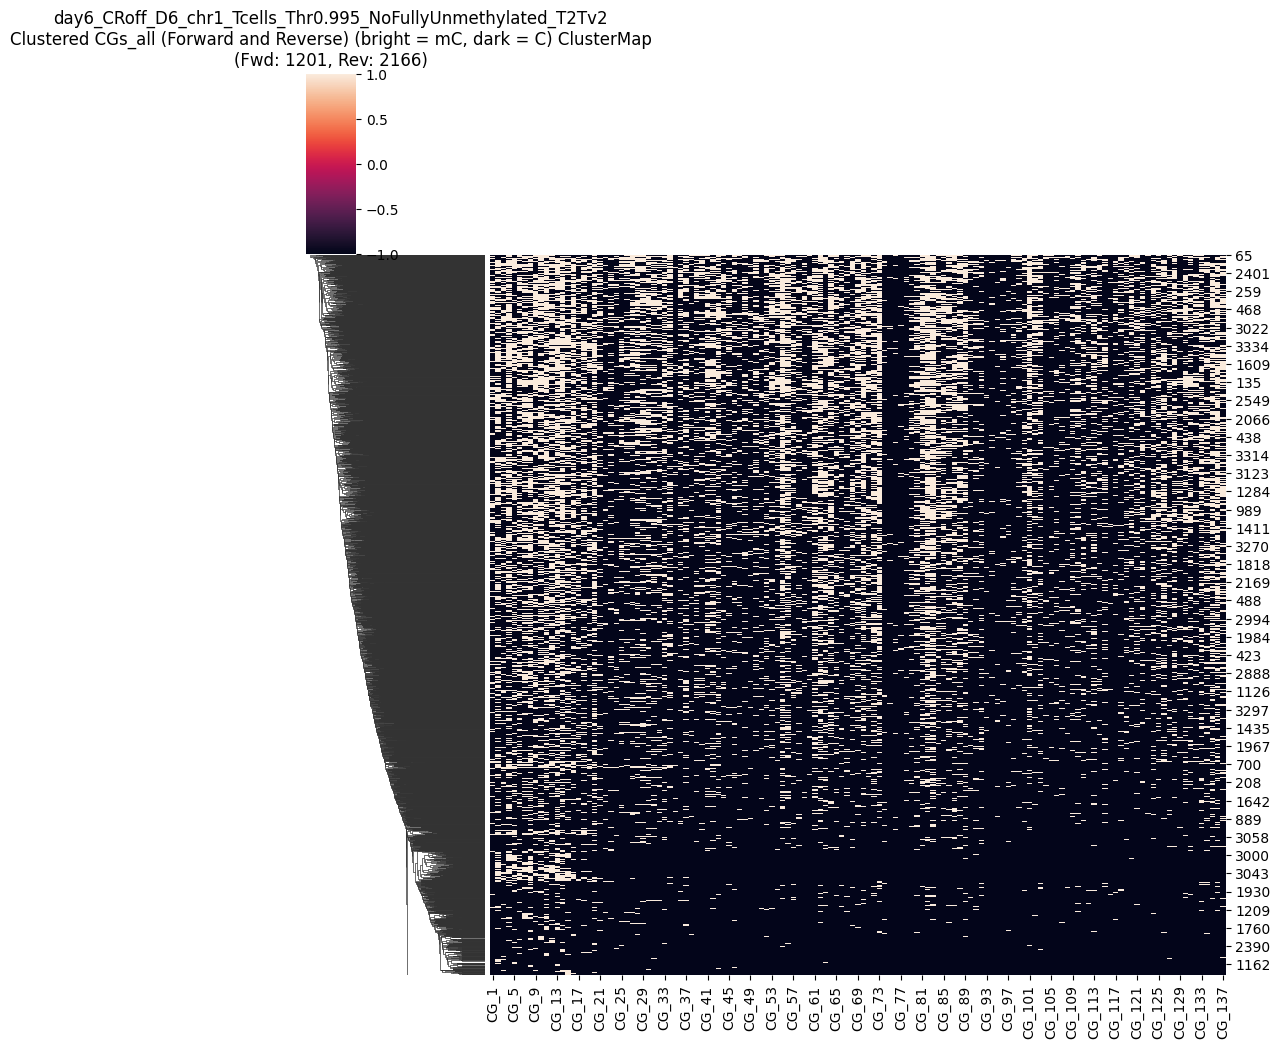

CGs_all saved as CG_137_padded_reads_day6_CRoff_D6_chr1_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2_mCthresh0.995_t2t_v2_0_chr1:206583354-206589854_2025-08-04_units_combined_numFWD1201_numRVS2166.npy in dimelo_v2_output
Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)


In [7]:
threshold_mC =  0.995 
experiment_name = "day6_CRoff_D6_chr1_Tcells_Thr"+str(threshold_mC)+"_NoFullyUnmethylated_T2Tv2"
bam_path = unedit_bam_path

print('experiment_name = ', experiment_name)

save_padded_reads_name_np = f"padded_reads_{experiment_name}_mCthresh{threshold_mC}_{reg_genome_version}_{region_str}_{date_today}.npy"
output_dir = create_output_directory("./dimelo_v2_output")

extract_file, extract_regions = extract_from_bam(
    experiment_name = experiment_name,
    bam_path=bam_path,
    ref_genome_file=ref_genome_path,
    output_dir=output_dir,
    regions=region_str,
    motifs=motifs,
    output_name='extracted_reads',
    threshold_mC=threshold_mC,
)
keep_full_coverage_reads_only=True

if extract_file:
    reads_df, regions_dict = process_extracted_reads(extract_file, region_str, motifs, ref_seq_list, 
    keep_full_coverage_reads_only=keep_full_coverage_reads_only)
    visualize_data(reads_df)

    padded_reads = create_padded_reads(reads_df, regions_dict, region_length)
    if padded_reads is not None:
        plot_padded_reads(padded_reads, ref_seq_list)
        save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np)

# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")


In [8]:
CGs_all_CRoff_D6_mc0995_original = CGs_all
CGs_all_CRoff_D6_mc0995_original

CG_1  CG_2  CG_3  CG_4  CG_5  CG_6  CG_7  CG_8  CG_9  CG_10  ...  \
0      1.0   1.0   NaN   1.0   NaN   1.0   NaN   NaN   1.0    1.0  ...   
1      NaN   NaN   NaN   NaN   NaN   NaN   1.0   1.0   NaN    NaN  ...   
2      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN  ...   
3      NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN    NaN  ...   
4      NaN   1.0   NaN   1.0   NaN   NaN   1.0   NaN   1.0    1.0  ...   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...    ...  ...   
3362   NaN   1.0   NaN   NaN   1.0   NaN   NaN   1.0   1.0    1.0  ...   
3363   1.0   1.0   NaN   NaN   1.0   NaN   NaN   1.0   1.0    1.0  ...   
3364   NaN   1.0   NaN   1.0   NaN   NaN   1.0   1.0   1.0    NaN  ...   
3365   NaN   1.0   1.0   NaN   1.0   1.0   NaN   1.0   NaN    NaN  ...   
3366   NaN   NaN   NaN   1.0   NaN   NaN   1.0   1.0   NaN    NaN  ...   

      CG_128  CG_129  CG_130  CG_131  CG_132  CG_133  CG_134  CG_135  CG_136  \
0        NaN     NaN     1.0     1.0     1.0     1.0     NaN     1.0     NaN   
1        NaN     NaN     1.0     NaN     NaN     NaN     NaN     NaN     NaN   
2        NaN     NaN     NaN     NaN     NaN     1.0     NaN     NaN     NaN   
3        NaN     NaN     1.0     NaN     1.0     1.0     NaN     NaN     NaN   
4        NaN     NaN     1.0     1.0     NaN     1.0     NaN     1.0     1.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
3362     NaN     1.0     NaN     NaN     NaN     NaN     NaN     1.0     1.0   
3363     1.0     NaN     NaN     NaN     NaN     1.0     1.0     NaN     NaN   
3364     1.0     NaN     1.0     NaN     NaN     NaN     NaN     NaN     NaN   
3365     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3366     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

      CG_137  
0        1.0  
1        NaN  
2        NaN  
3        NaN  
4        NaN  
...      ...  
3362     NaN  
3363     1.0  
3364     NaN  
3365     NaN  
3366     NaN  

[3367 rows x 137 columns]

Mean methylated CGs per read: 28.0
Maximum methylated CGs per read: 74.0
Threshold (80% of max): 22.40
Original number of reads: 3367
Number of reads after filtering: 1975
Removed 1392 reads


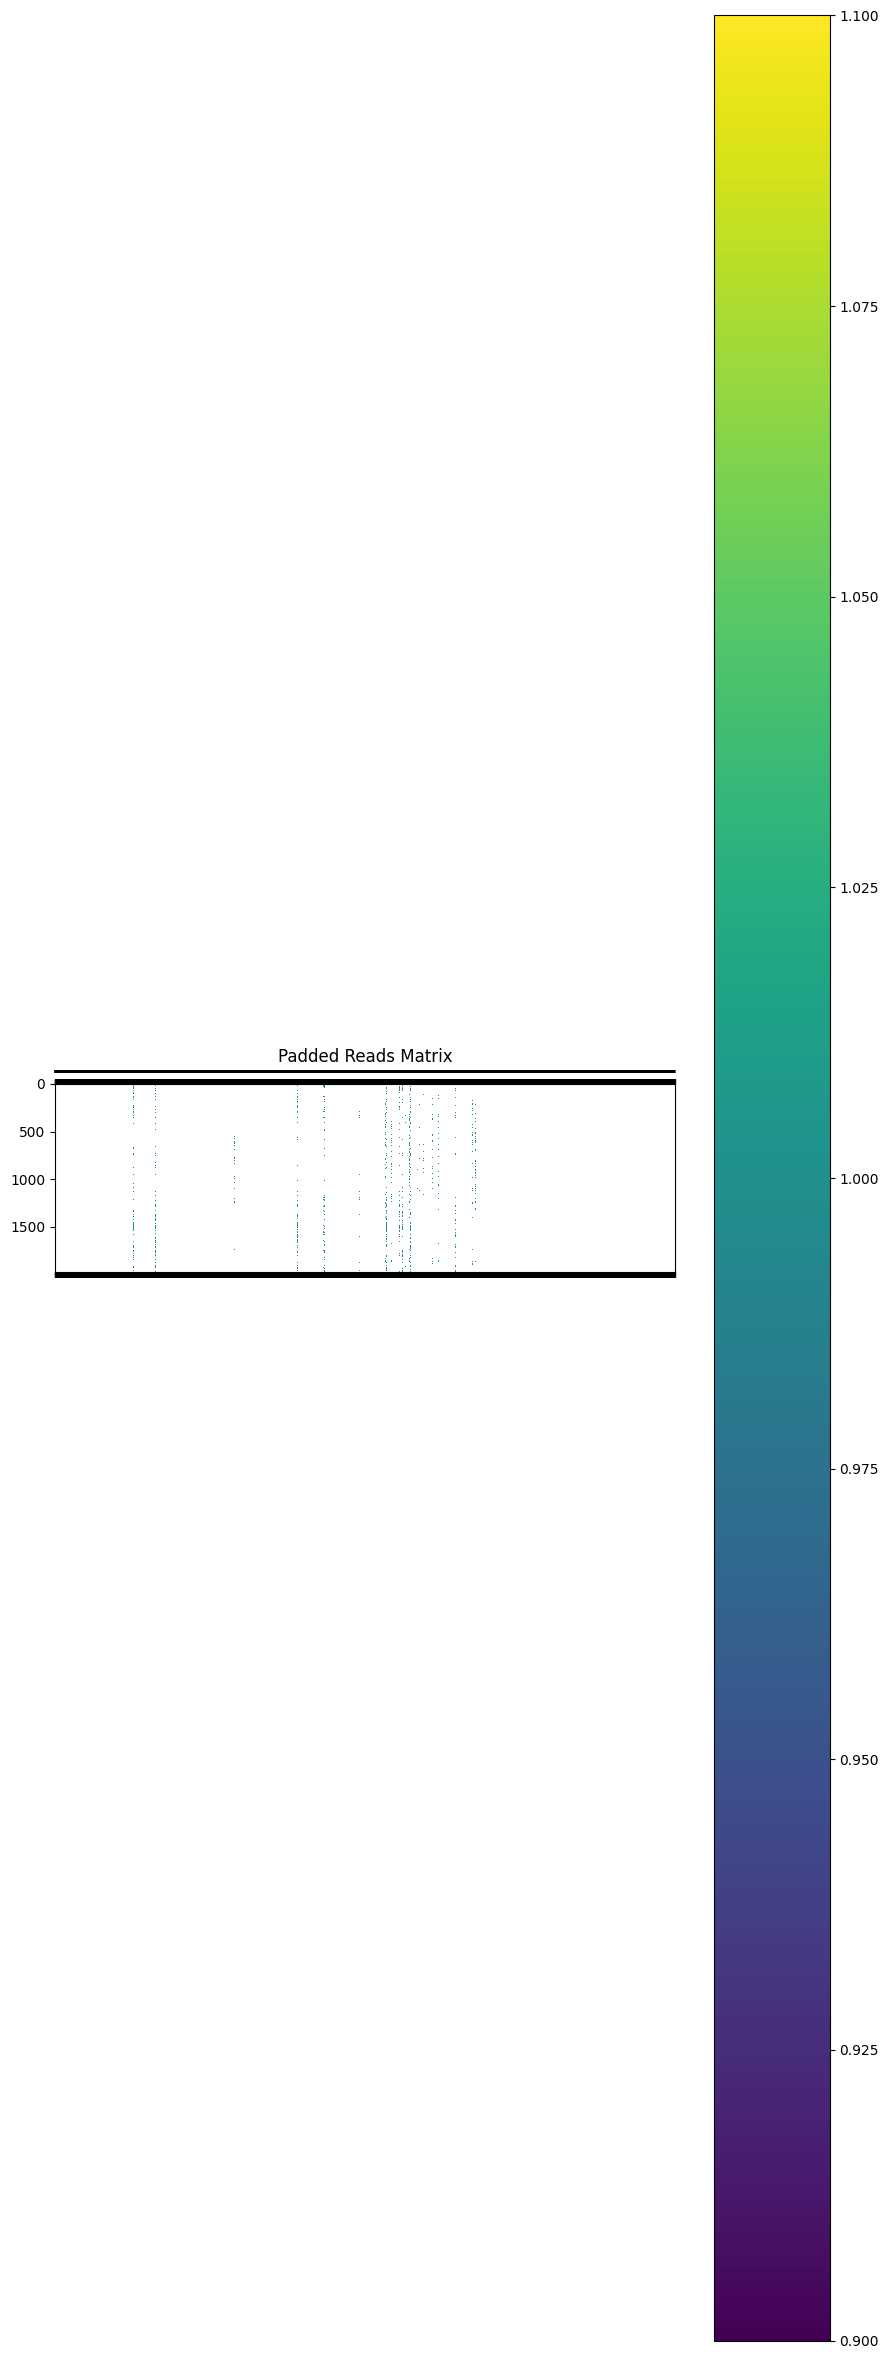

Padded reads saved to removed_low80_methylated_padded_reads_day6_CRoff_D6_chr1_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2_mCthresh0.995_t2t_v2_0_chr1:206583354-206589854_2025-08-04.npy
Padded reads loaded successfully.


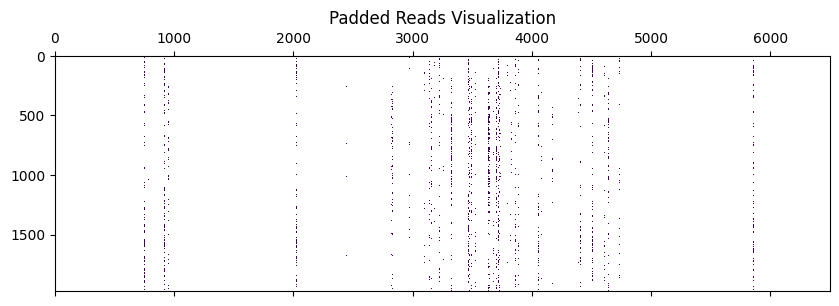

Visualization completed.
Region length: 6500
GTCATTGTATGGTTCCTGGGATAAGAGTAAGAACCGTGGTCCCTTGCTCTGTCAAAATCATAAACCTATTTTCTTTGTATTTTGACTTAATTACATAAGCTTGTTTTGGATTGGAAGGTCTATAGAGACTATTTTAGTGCCAAATGCTATTTAATCAATGCAGAAATAAGCCCTTGAGAGGTGCAGTGACTCAGCTGAGGACACACTGATAGTTTCTGGTAGATAAGTATGAAGCCTTGGAACTACTTCTCATATCATAAGCCCCTGGGTTCCCAAATCACCTCCCCAAGTACCTAATTCATCATCCTCTGCATACAAGAAATTTTTGCTCATTCCAATAAAAAGAATGTAGTACGGCAGGACAGGAGAAGTACAGGTTTTGGAATCAAACTAGGTTTAGATTCTGACCTGGTCGCTAGTTAGTGCATGGGCTTTGGTAAACAGCCTCTCAGCCTGTTTCCTTGTCTGCAAAATATGGATAGTTATCTTCACTTCATGAAGTTGTGTTGGTGAAATGGTATAATGTGTATAAAGCAACTGGAACACAACAAATGAGGCCATTTATTTAAAATAATCTTTAGTAAGTTATAAATTCACATATTTGCTTTTTTCTGAGGAATGCTTAGATTTTATCATAGATCTCTTTTCTAAATTGAGTAAATACATAGTGGATTTCTTTGTTTCCTTCCCCTCAGAATGTTGAAATTTGGCTGATTGTAACTATTACTTAAGACTCTATCCAGTAATTGTTCGTAAAATTTCTTTTCTTTTTTTTTTTTTGAGACGGAGTTTTGCTCTCGTCCCCCAGGCTGGAGTGCAATGGCGCGATCTTGGCTCACTGCAACCTCCGCCTCCCAGGTTCAAGTGATTCTCCCGCCTCAGCCTCCCAAGTAGCTGGGATTACAGGCACCTGCCACAACGCCCAGCCAATTTTTGTATTTTTAGTAGAGACGGG

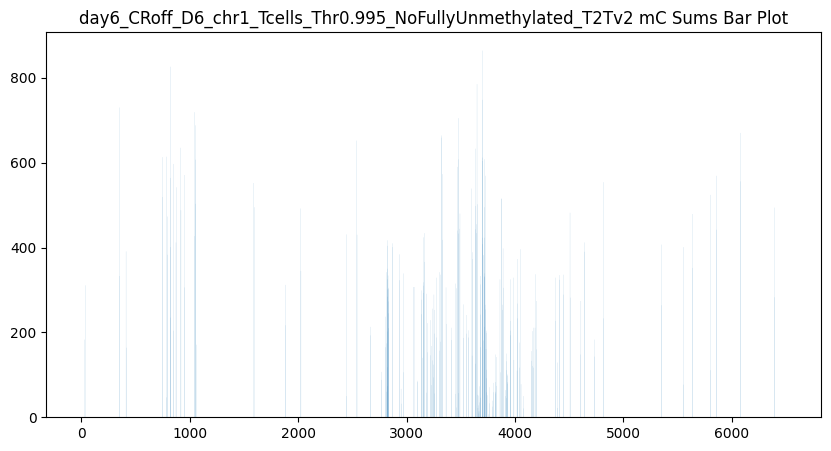

(mC_sums / len(CGs_all) = [0. 0. 0. ... 0. 0. 0.]


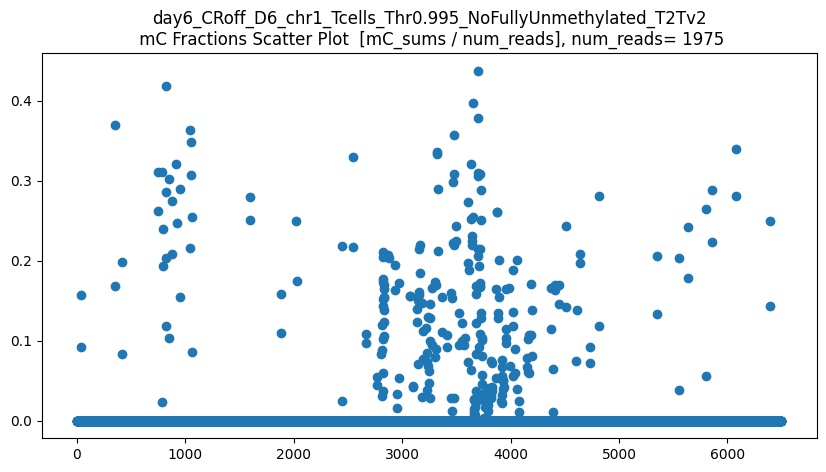

len(CGs_all) = 1975
CGs_all.shape = (1975, 137)
len(CGs_all_on_fwd_C_sums) = 6500
CGs_all_on_fwd_C_sums.shape = (6500,)


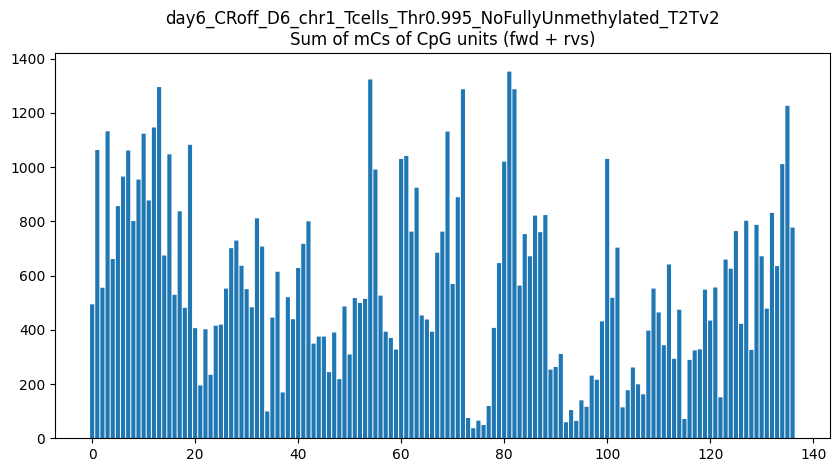

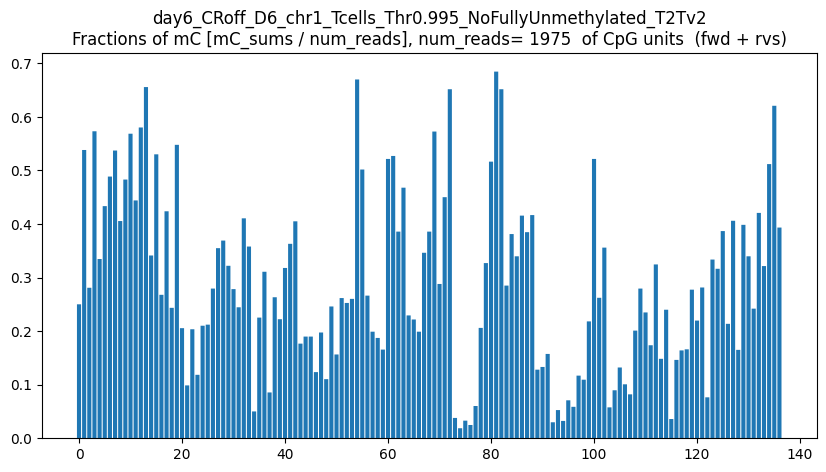

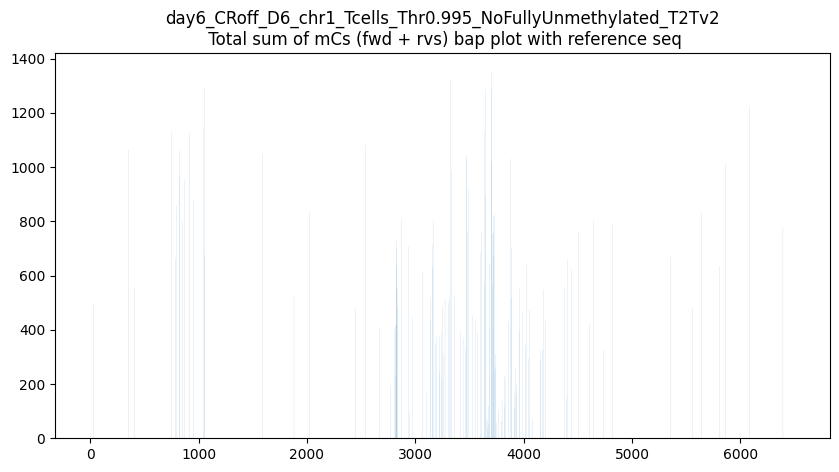

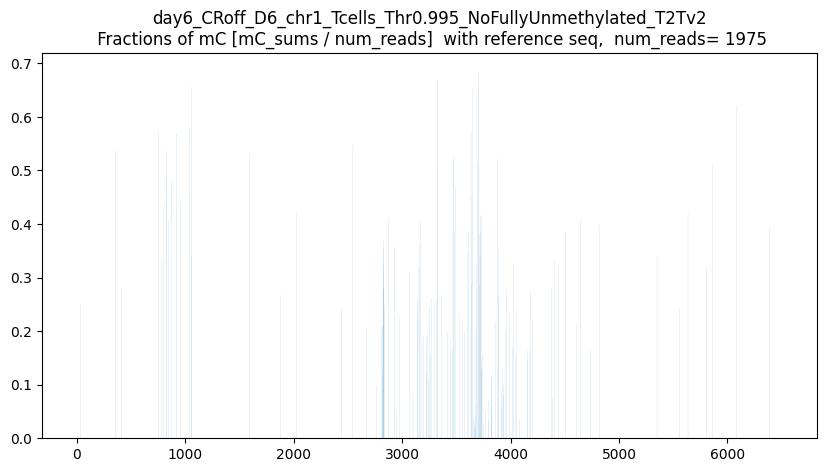

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



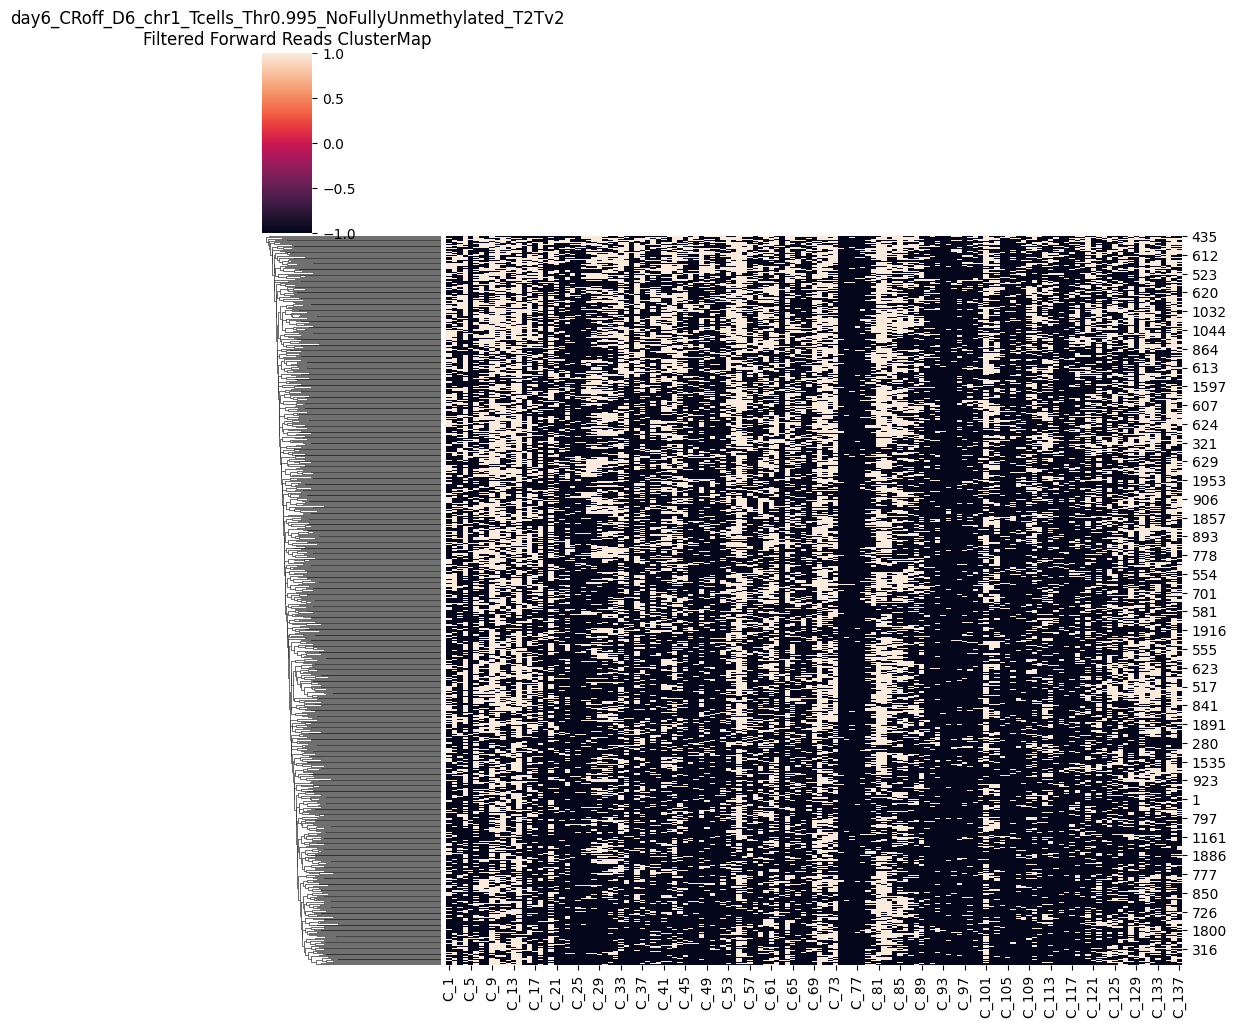

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



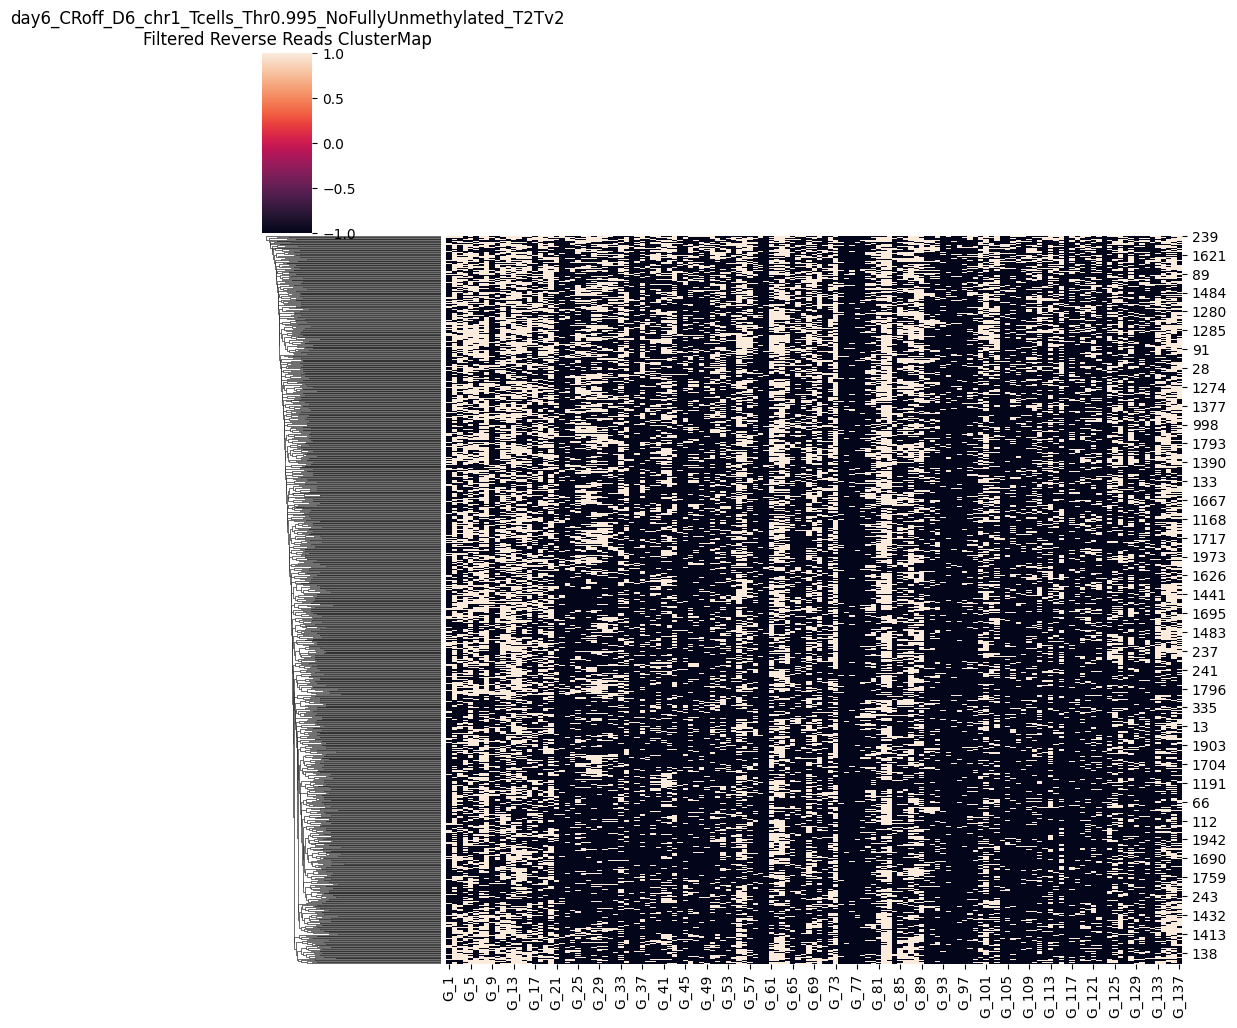

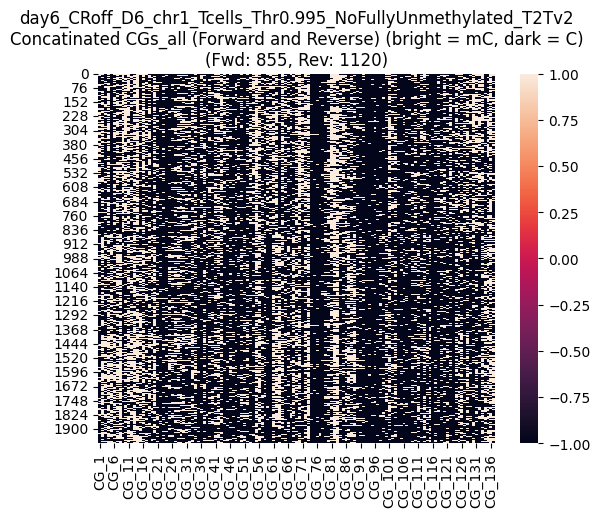

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



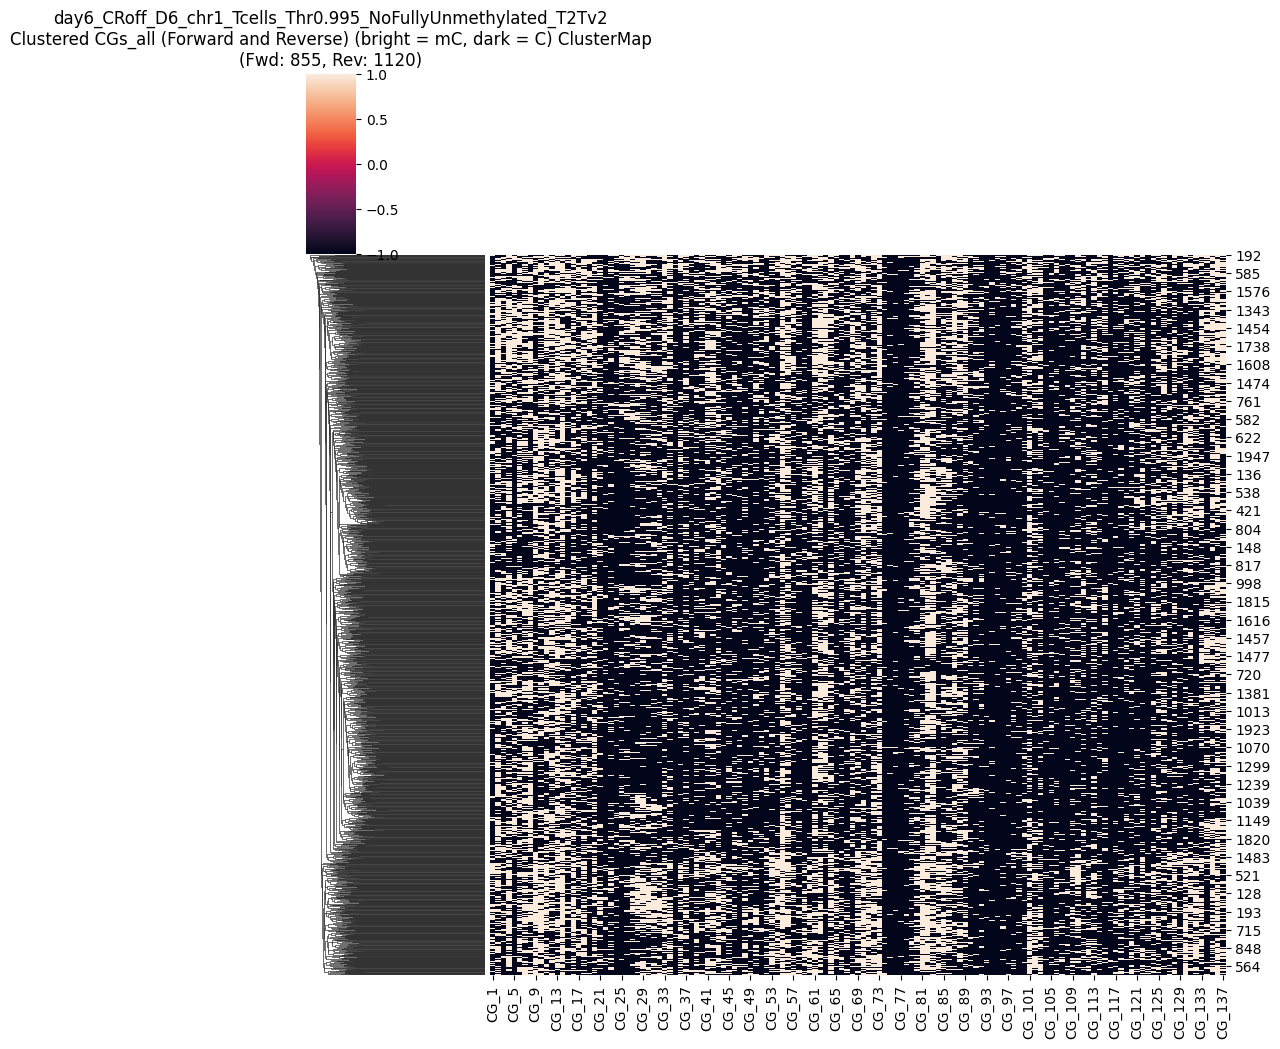

CGs_all saved as CG_137_removed_low80_methylated_padded_reads_day6_CRoff_D6_chr1_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2_mCthresh0.995_t2t_v2_0_chr1:206583354-206589854_2025-08-04_units_combined_numFWD855_numRVS1120.npy in dimelo_v2_output
Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)


CG_1  CG_2  CG_3  CG_4  CG_5  CG_6  CG_7  CG_8  CG_9  CG_10  ...  \
0      1.0   1.0   NaN   1.0   NaN   1.0   NaN   NaN   1.0    1.0  ...   
1      NaN   NaN   NaN   NaN   NaN   NaN   1.0   1.0   NaN    NaN  ...   
2      NaN   1.0   NaN   1.0   NaN   NaN   1.0   NaN   1.0    1.0  ...   
3      NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   1.0    1.0  ...   
4      1.0   1.0   NaN   1.0   NaN   NaN   1.0   NaN   1.0    NaN  ...   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...    ...  ...   
1970   1.0   1.0   NaN   NaN   1.0   1.0   NaN   1.0   1.0    1.0  ...   
1971   NaN   NaN   NaN   1.0   1.0   1.0   NaN   1.0   NaN    1.0  ...   
1972   NaN   1.0   NaN   NaN   1.0   NaN   NaN   1.0   1.0    1.0  ...   
1973   1.0   1.0   NaN   NaN   1.0   NaN   NaN   1.0   1.0    1.0  ...   
1974   NaN   1.0   NaN   1.0   NaN   NaN   1.0   1.0   1.0    NaN  ...   

      CG_128  CG_129  CG_130  CG_131  CG_132  CG_133  CG_134  CG_135  CG_136  \
0        NaN     NaN     1.0     1.0     1.0     1.0     NaN     1.0     NaN   
1        NaN     NaN     1.0     NaN     NaN     NaN     NaN     NaN     NaN   
2        NaN     NaN     1.0     1.0     NaN     1.0     NaN     1.0     1.0   
3        NaN     1.0     1.0     NaN     1.0     NaN     NaN     1.0     1.0   
4        NaN     NaN     NaN     NaN     NaN     1.0     NaN     NaN     NaN   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1970     1.0     NaN     1.0     NaN     NaN     1.0     NaN     1.0     NaN   
1971     1.0     NaN     1.0     NaN     NaN     NaN     NaN     NaN     1.0   
1972     NaN     1.0     NaN     NaN     NaN     NaN     NaN     1.0     1.0   
1973     1.0     NaN     NaN     NaN     NaN     1.0     1.0     NaN     NaN   
1974     1.0     NaN     1.0     NaN     NaN     NaN     NaN     NaN     NaN   

      CG_137  
0        1.0  
1        NaN  
2        NaN  
3        1.0  
4        NaN  
...      ...  
1970     NaN  
1971     NaN  
1972     NaN  
1973     1.0  
1974     NaN  

[1975 rows x 137 columns]

In [9]:
threshold_percent = 80
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_CRoff_D6_mc0995_remove_low80 = CGs_all
CGs_all_CRoff_D6_mc0995_remove_low80


Mean methylated CGs per read: 28.0
Maximum methylated CGs per read: 74.0
Threshold (70% of max): 19.60
Original number of reads: 3367
Number of reads after filtering: 2143
Removed 1224 reads


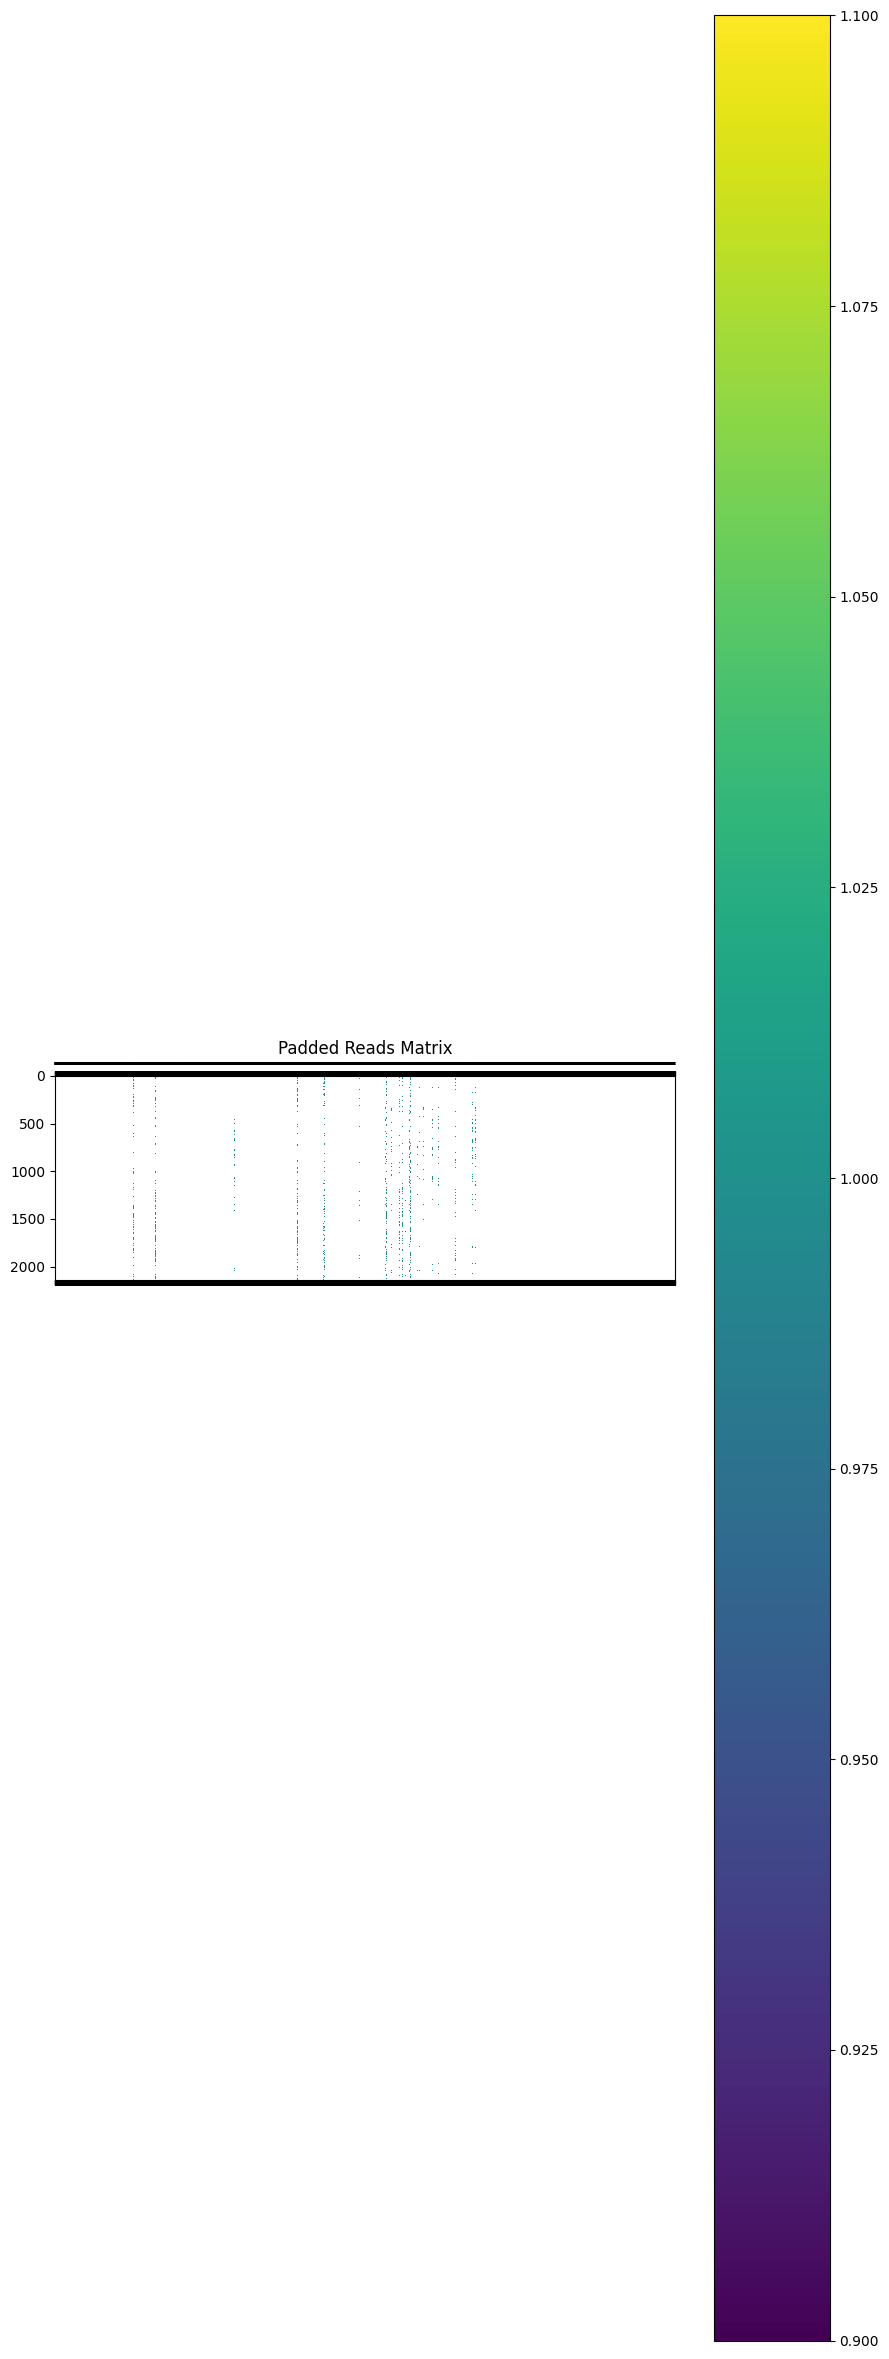

Padded reads saved to removed_low70_methylated_padded_reads_day6_CRoff_D6_chr1_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2_mCthresh0.995_t2t_v2_0_chr1:206583354-206589854_2025-08-04.npy
Padded reads loaded successfully.


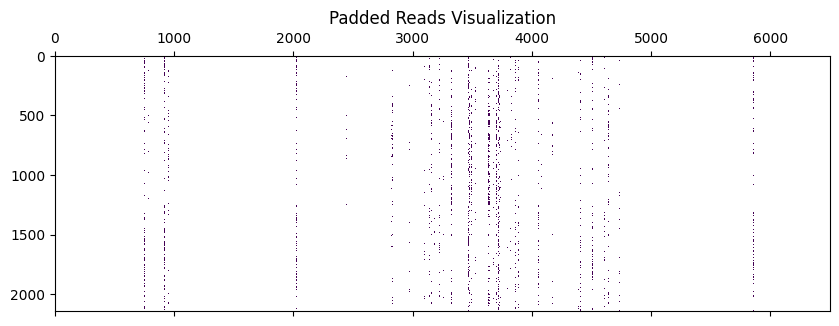

Visualization completed.
Region length: 6500
GTCATTGTATGGTTCCTGGGATAAGAGTAAGAACCGTGGTCCCTTGCTCTGTCAAAATCATAAACCTATTTTCTTTGTATTTTGACTTAATTACATAAGCTTGTTTTGGATTGGAAGGTCTATAGAGACTATTTTAGTGCCAAATGCTATTTAATCAATGCAGAAATAAGCCCTTGAGAGGTGCAGTGACTCAGCTGAGGACACACTGATAGTTTCTGGTAGATAAGTATGAAGCCTTGGAACTACTTCTCATATCATAAGCCCCTGGGTTCCCAAATCACCTCCCCAAGTACCTAATTCATCATCCTCTGCATACAAGAAATTTTTGCTCATTCCAATAAAAAGAATGTAGTACGGCAGGACAGGAGAAGTACAGGTTTTGGAATCAAACTAGGTTTAGATTCTGACCTGGTCGCTAGTTAGTGCATGGGCTTTGGTAAACAGCCTCTCAGCCTGTTTCCTTGTCTGCAAAATATGGATAGTTATCTTCACTTCATGAAGTTGTGTTGGTGAAATGGTATAATGTGTATAAAGCAACTGGAACACAACAAATGAGGCCATTTATTTAAAATAATCTTTAGTAAGTTATAAATTCACATATTTGCTTTTTTCTGAGGAATGCTTAGATTTTATCATAGATCTCTTTTCTAAATTGAGTAAATACATAGTGGATTTCTTTGTTTCCTTCCCCTCAGAATGTTGAAATTTGGCTGATTGTAACTATTACTTAAGACTCTATCCAGTAATTGTTCGTAAAATTTCTTTTCTTTTTTTTTTTTTGAGACGGAGTTTTGCTCTCGTCCCCCAGGCTGGAGTGCAATGGCGCGATCTTGGCTCACTGCAACCTCCGCCTCCCAGGTTCAAGTGATTCTCCCGCCTCAGCCTCCCAAGTAGCTGGGATTACAGGCACCTGCCACAACGCCCAGCCAATTTTTGTATTTTTAGTAGAGACGGG

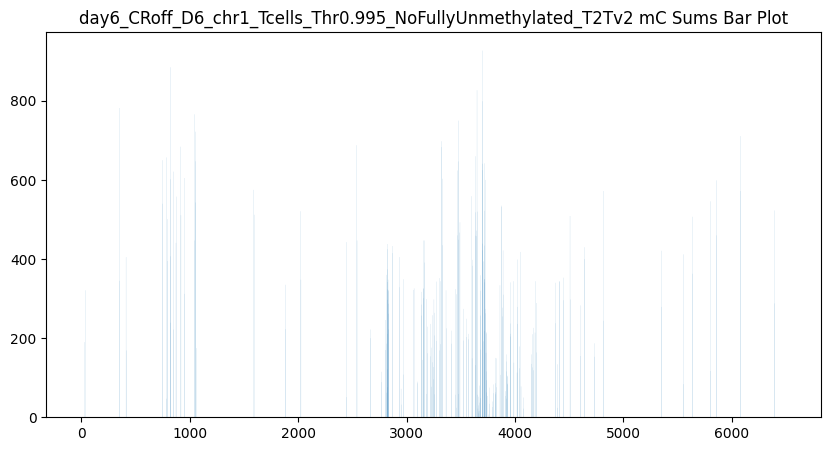

(mC_sums / len(CGs_all) = [0. 0. 0. ... 0. 0. 0.]


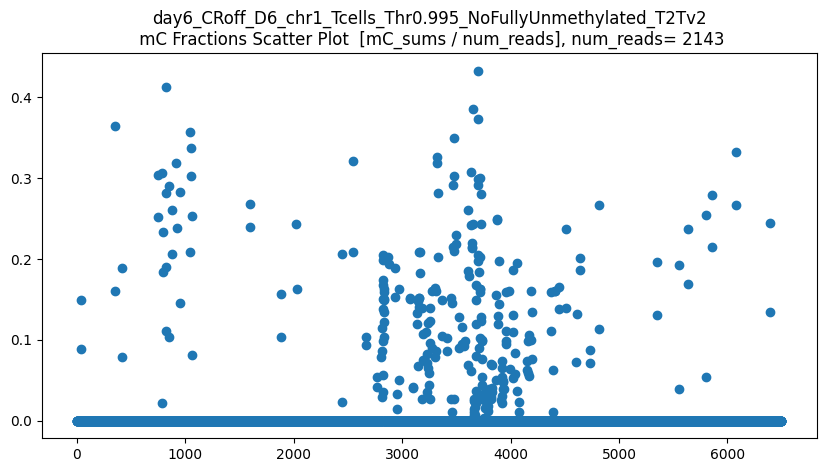

len(CGs_all) = 2143
CGs_all.shape = (2143, 137)
len(CGs_all_on_fwd_C_sums) = 6500
CGs_all_on_fwd_C_sums.shape = (6500,)


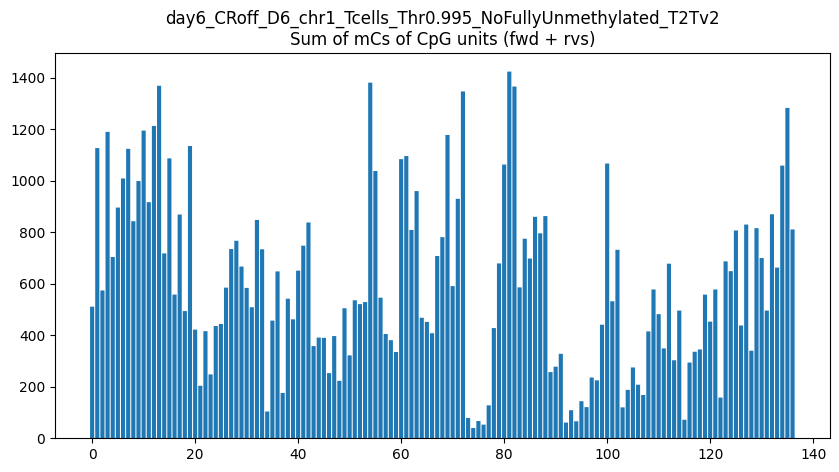

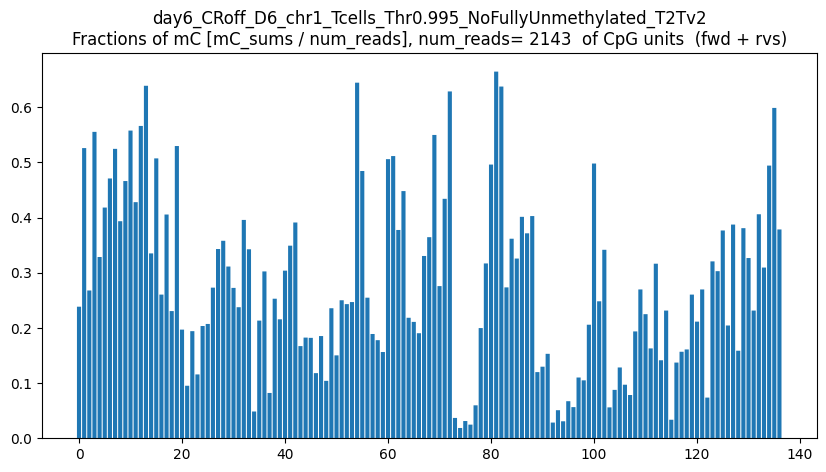

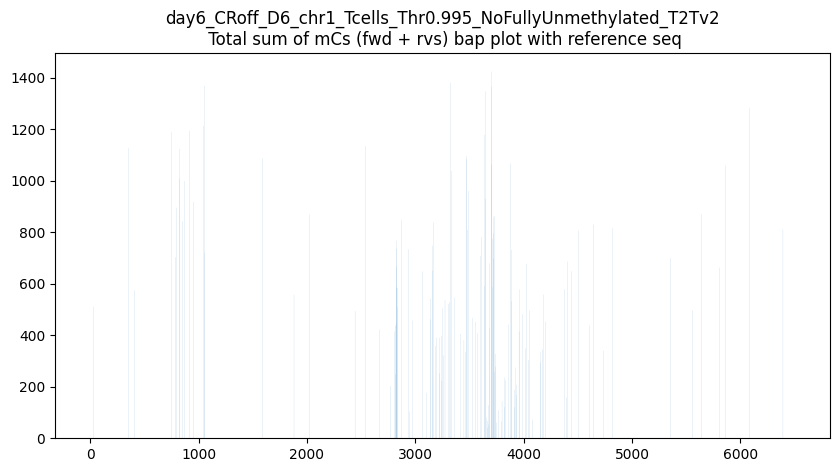

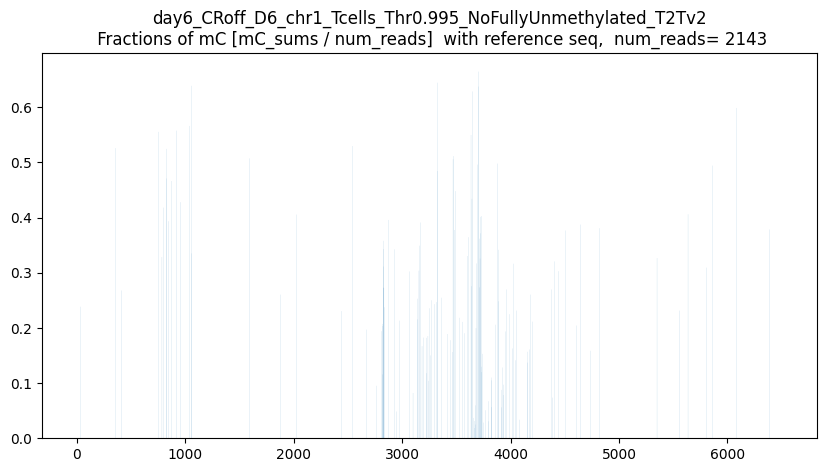

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



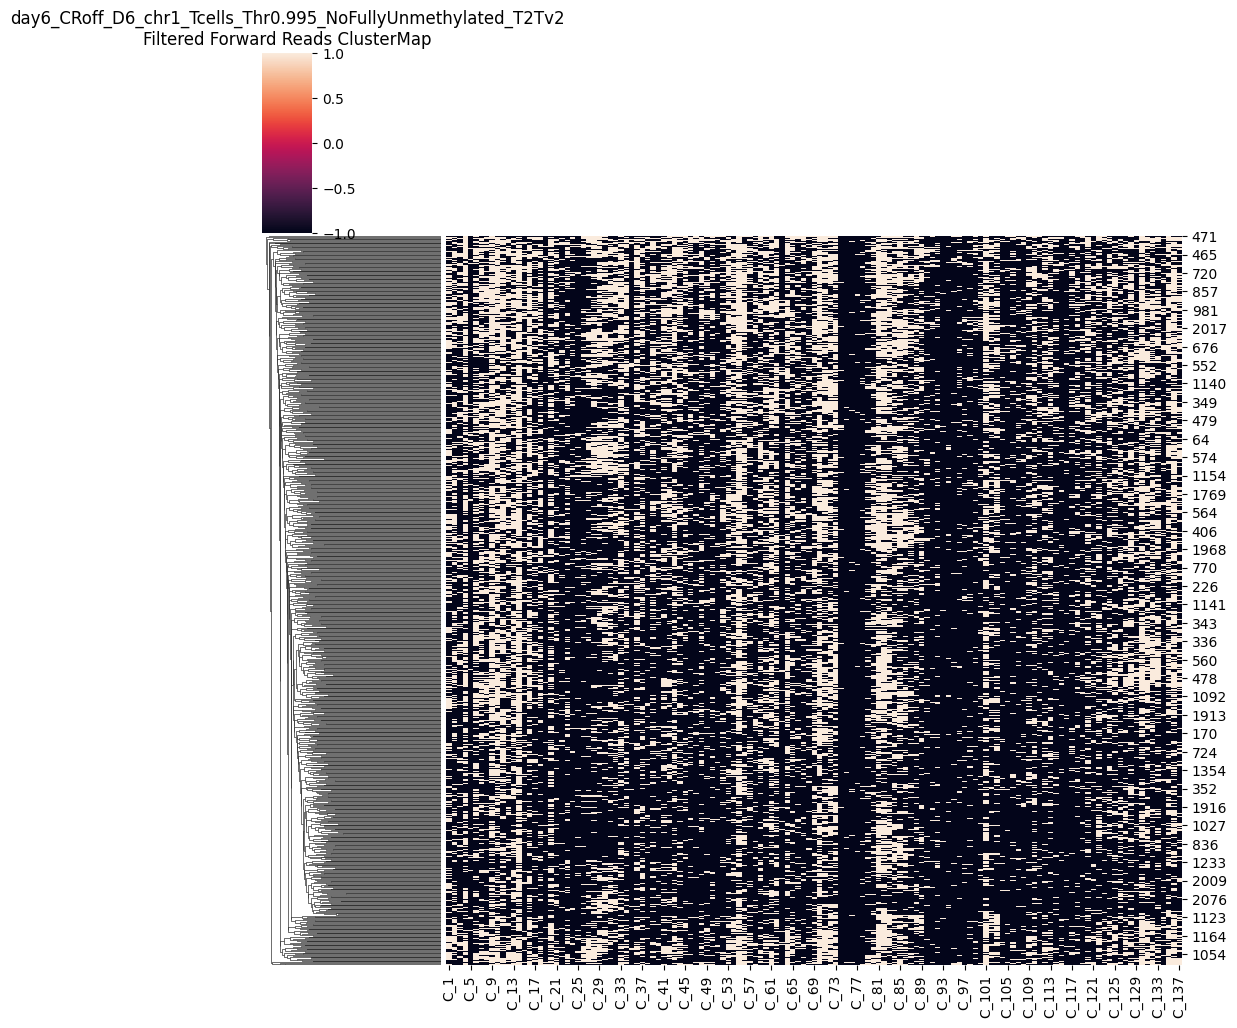

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



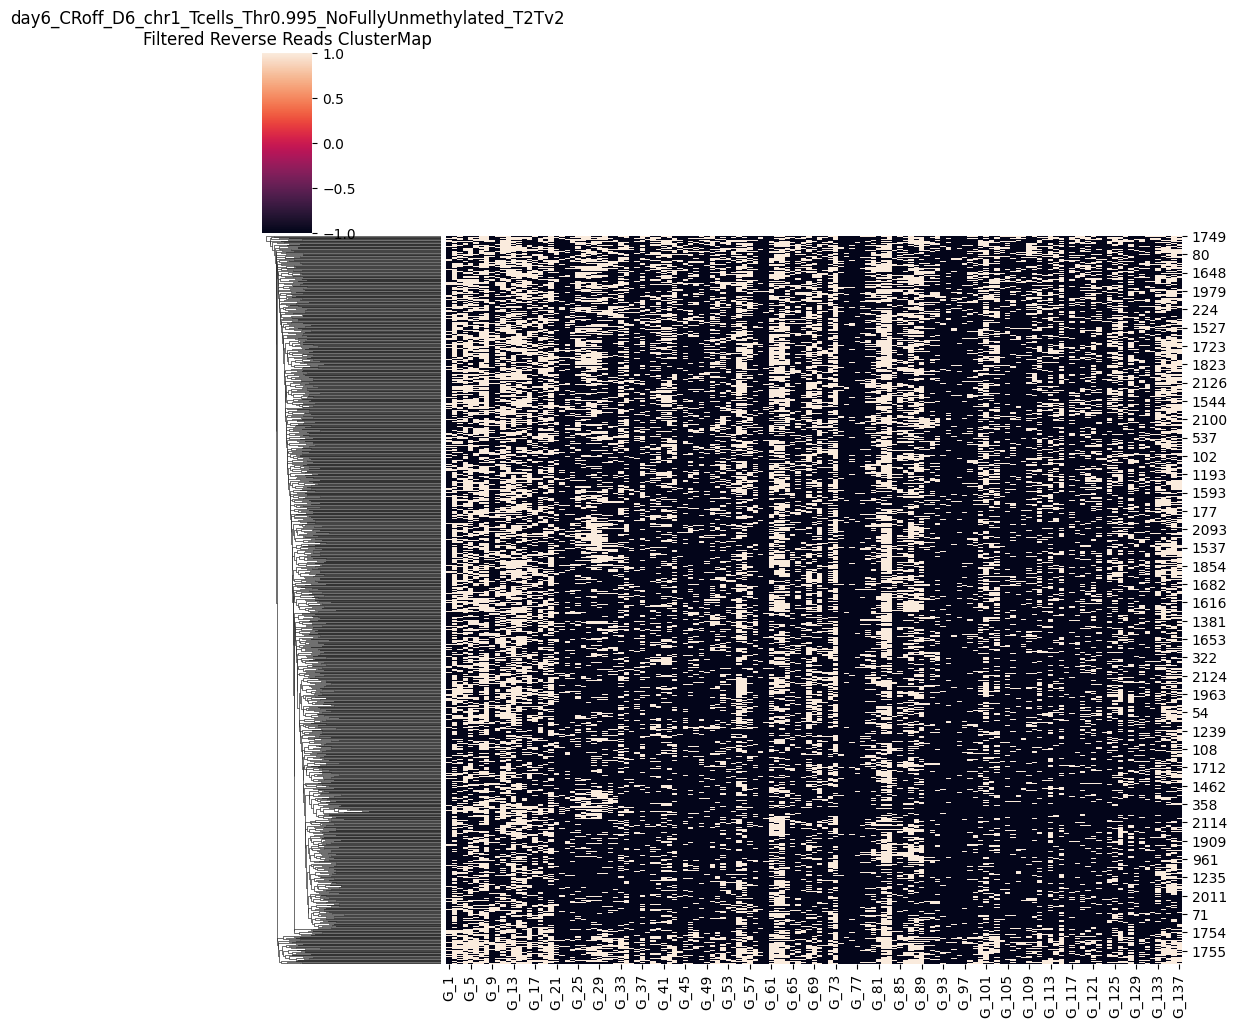

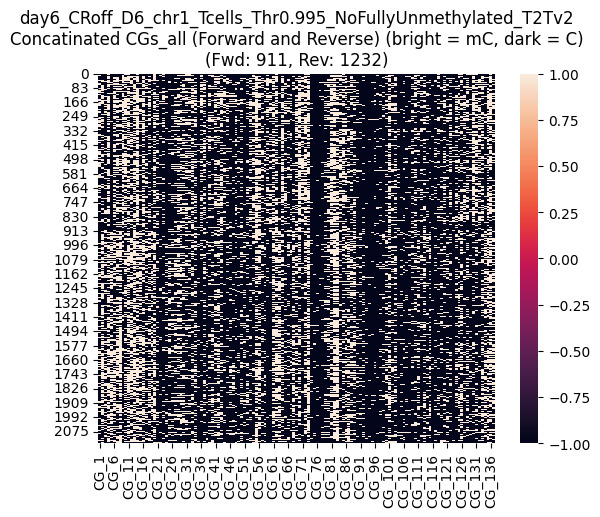

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



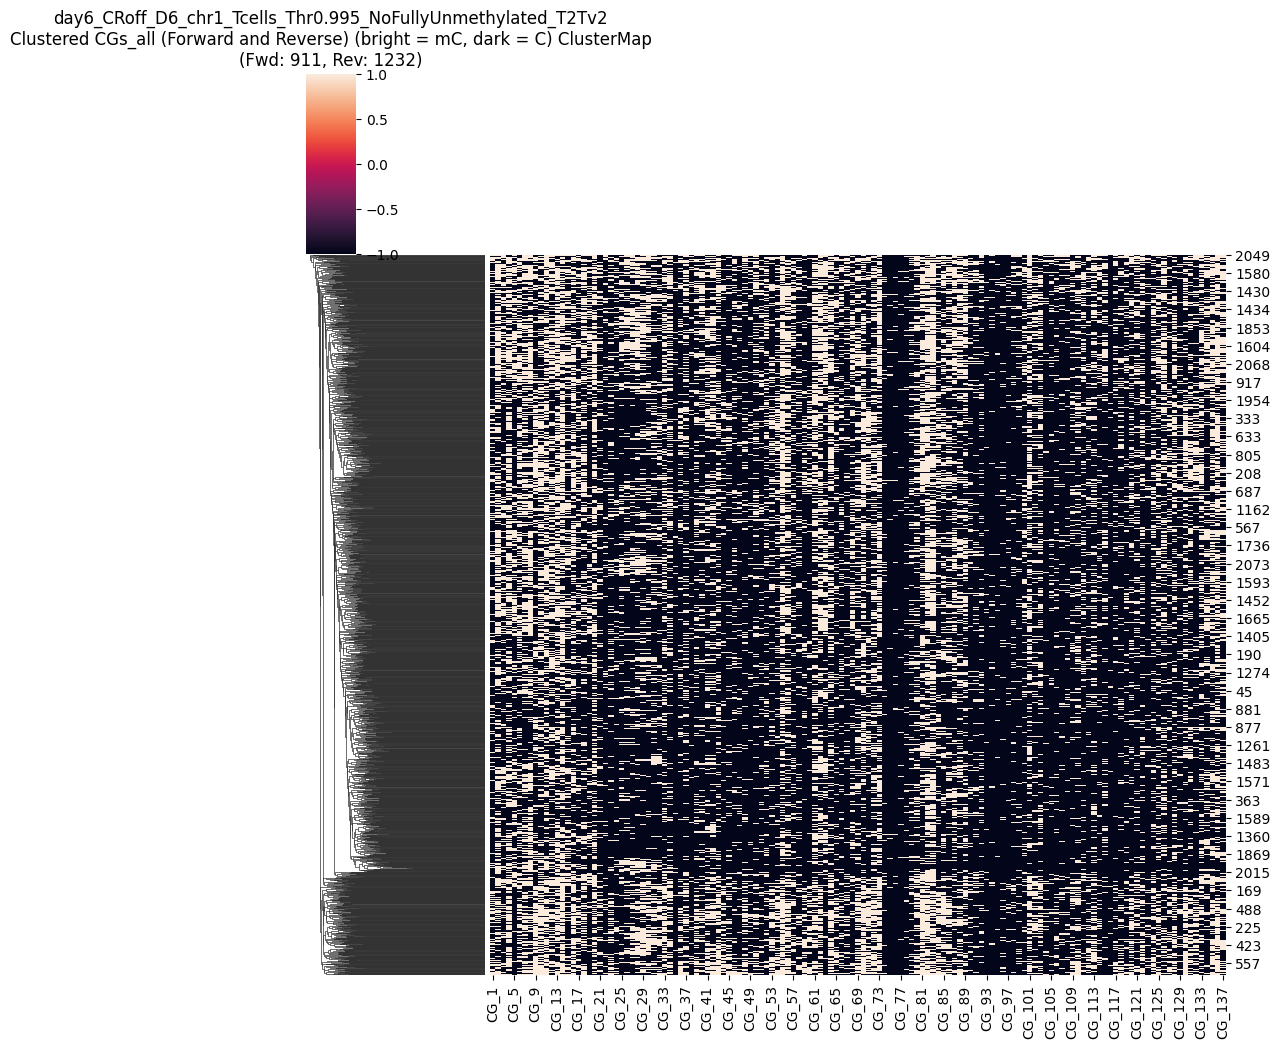

CGs_all saved as CG_137_removed_low70_methylated_padded_reads_day6_CRoff_D6_chr1_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2_mCthresh0.995_t2t_v2_0_chr1:206583354-206589854_2025-08-04_units_combined_numFWD911_numRVS1232.npy in dimelo_v2_output
Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)


CG_1  CG_2  CG_3  CG_4  CG_5  CG_6  CG_7  CG_8  CG_9  CG_10  ...  \
0      1.0   1.0   NaN   1.0   NaN   1.0   NaN   NaN   1.0    1.0  ...   
1      NaN   NaN   NaN   NaN   NaN   NaN   1.0   1.0   NaN    NaN  ...   
2      NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN    NaN  ...   
3      NaN   1.0   NaN   1.0   NaN   NaN   1.0   NaN   1.0    1.0  ...   
4      NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   1.0    1.0  ...   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...    ...  ...   
2138   NaN   1.0   NaN   1.0   NaN   1.0   NaN   NaN   NaN    NaN  ...   
2139   NaN   1.0   NaN   NaN   NaN   NaN   1.0   1.0   NaN    NaN  ...   
2140   NaN   1.0   NaN   NaN   1.0   NaN   NaN   1.0   1.0    1.0  ...   
2141   1.0   1.0   NaN   NaN   1.0   NaN   NaN   1.0   1.0    1.0  ...   
2142   NaN   1.0   NaN   1.0   NaN   NaN   1.0   1.0   1.0    NaN  ...   

      CG_128  CG_129  CG_130  CG_131  CG_132  CG_133  CG_134  CG_135  CG_136  \
0        NaN     NaN     1.0     1.0     1.0     1.0     NaN     1.0     NaN   
1        NaN     NaN     1.0     NaN     NaN     NaN     NaN     NaN     NaN   
2        NaN     NaN     1.0     NaN     1.0     1.0     NaN     NaN     NaN   
3        NaN     NaN     1.0     1.0     NaN     1.0     NaN     1.0     1.0   
4        NaN     1.0     1.0     NaN     1.0     NaN     NaN     1.0     1.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2138     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2139     NaN     NaN     NaN     NaN     NaN     NaN     NaN     1.0     1.0   
2140     NaN     1.0     NaN     NaN     NaN     NaN     NaN     1.0     1.0   
2141     1.0     NaN     NaN     NaN     NaN     1.0     1.0     NaN     NaN   
2142     1.0     NaN     1.0     NaN     NaN     NaN     NaN     NaN     NaN   

      CG_137  
0        1.0  
1        NaN  
2        NaN  
3        NaN  
4        1.0  
...      ...  
2138     NaN  
2139     NaN  
2140     NaN  
2141     1.0  
2142     NaN  

[2143 rows x 137 columns]

In [10]:
threshold_percent = 70
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_CRoff_D6_mc0995_remove_low70 = CGs_all
CGs_all_CRoff_D6_mc0995_remove_low70


Mean methylated CGs per read: 28.0
Maximum methylated CGs per read: 74.0
Threshold (50% of max): 14.00
Original number of reads: 3367
Number of reads after filtering: 2461
Removed 906 reads


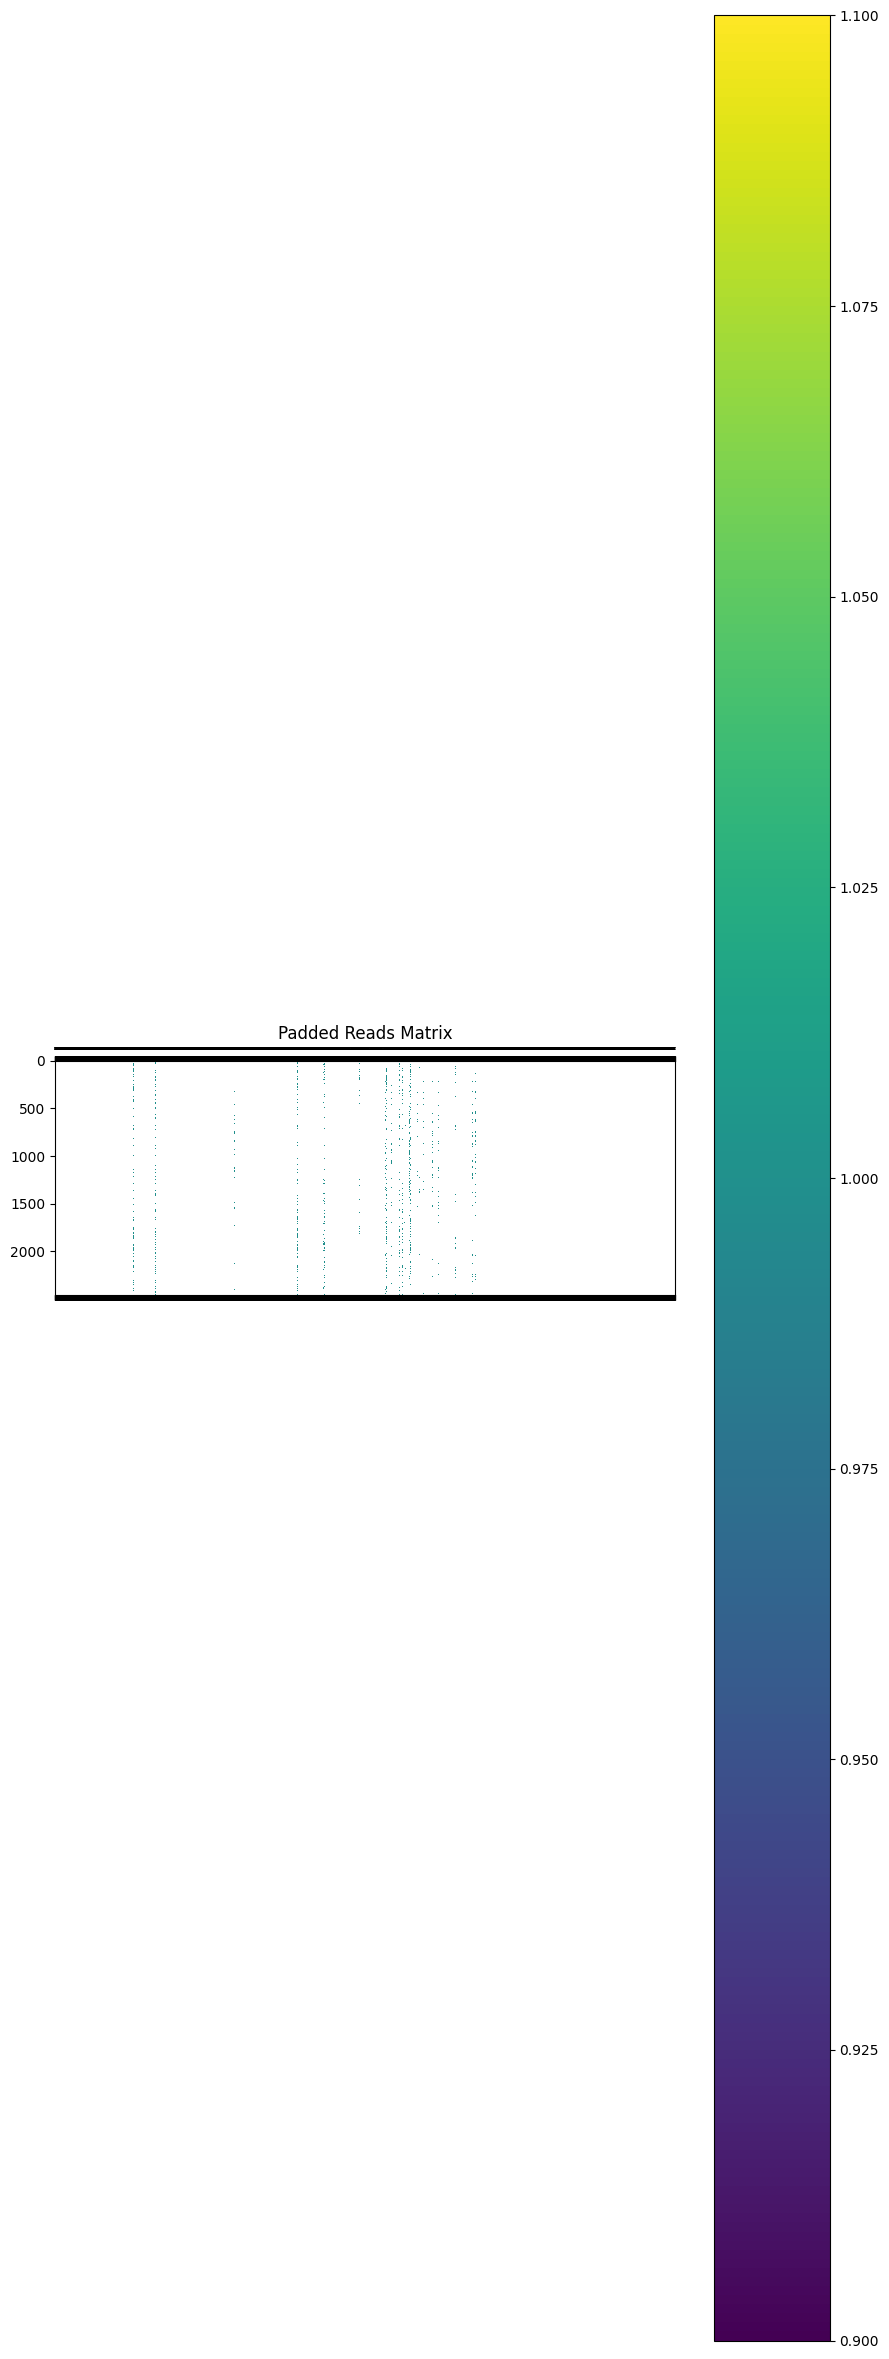

Padded reads saved to removed_low50_methylated_padded_reads_day6_CRoff_D6_chr1_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2_mCthresh0.995_t2t_v2_0_chr1:206583354-206589854_2025-08-04.npy
Padded reads loaded successfully.


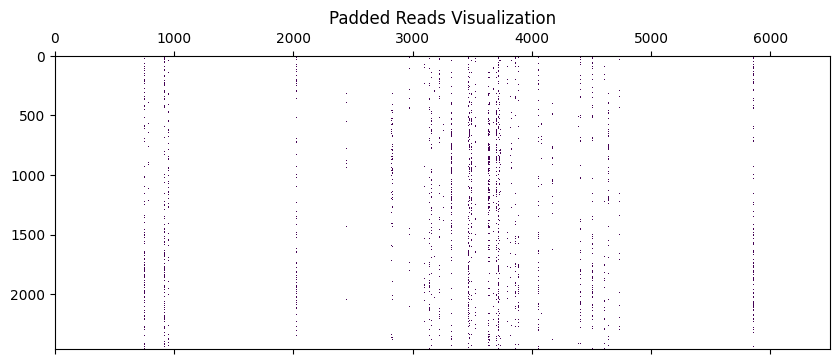

Visualization completed.
Region length: 6500
GTCATTGTATGGTTCCTGGGATAAGAGTAAGAACCGTGGTCCCTTGCTCTGTCAAAATCATAAACCTATTTTCTTTGTATTTTGACTTAATTACATAAGCTTGTTTTGGATTGGAAGGTCTATAGAGACTATTTTAGTGCCAAATGCTATTTAATCAATGCAGAAATAAGCCCTTGAGAGGTGCAGTGACTCAGCTGAGGACACACTGATAGTTTCTGGTAGATAAGTATGAAGCCTTGGAACTACTTCTCATATCATAAGCCCCTGGGTTCCCAAATCACCTCCCCAAGTACCTAATTCATCATCCTCTGCATACAAGAAATTTTTGCTCATTCCAATAAAAAGAATGTAGTACGGCAGGACAGGAGAAGTACAGGTTTTGGAATCAAACTAGGTTTAGATTCTGACCTGGTCGCTAGTTAGTGCATGGGCTTTGGTAAACAGCCTCTCAGCCTGTTTCCTTGTCTGCAAAATATGGATAGTTATCTTCACTTCATGAAGTTGTGTTGGTGAAATGGTATAATGTGTATAAAGCAACTGGAACACAACAAATGAGGCCATTTATTTAAAATAATCTTTAGTAAGTTATAAATTCACATATTTGCTTTTTTCTGAGGAATGCTTAGATTTTATCATAGATCTCTTTTCTAAATTGAGTAAATACATAGTGGATTTCTTTGTTTCCTTCCCCTCAGAATGTTGAAATTTGGCTGATTGTAACTATTACTTAAGACTCTATCCAGTAATTGTTCGTAAAATTTCTTTTCTTTTTTTTTTTTTGAGACGGAGTTTTGCTCTCGTCCCCCAGGCTGGAGTGCAATGGCGCGATCTTGGCTCACTGCAACCTCCGCCTCCCAGGTTCAAGTGATTCTCCCGCCTCAGCCTCCCAAGTAGCTGGGATTACAGGCACCTGCCACAACGCCCAGCCAATTTTTGTATTTTTAGTAGAGACGGG

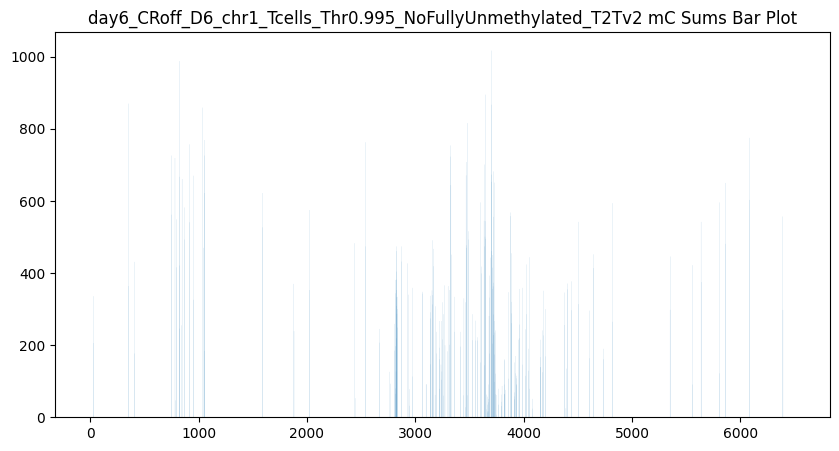

(mC_sums / len(CGs_all) = [0. 0. 0. ... 0. 0. 0.]


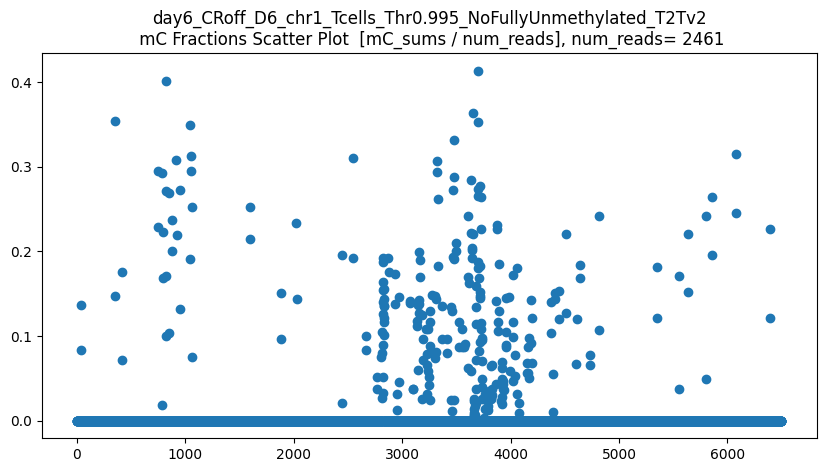

len(CGs_all) = 2461
CGs_all.shape = (2461, 137)
len(CGs_all_on_fwd_C_sums) = 6500
CGs_all_on_fwd_C_sums.shape = (6500,)


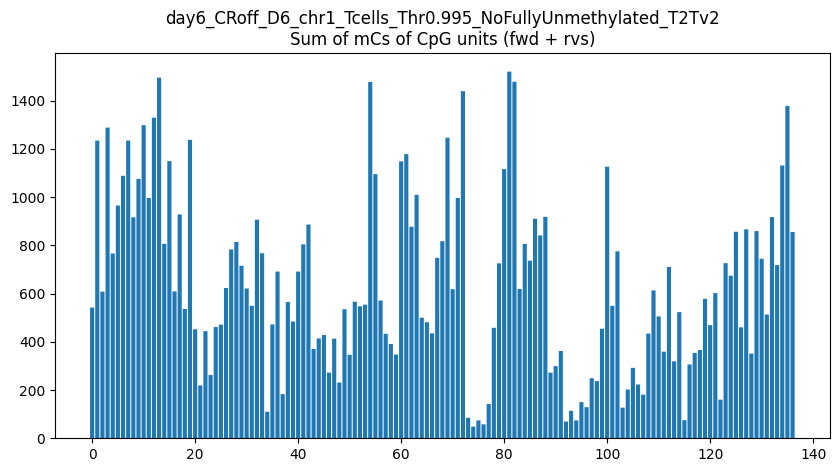

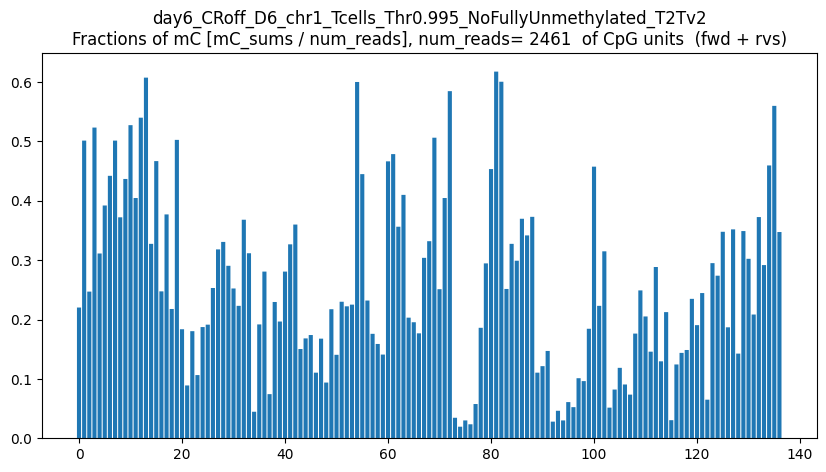

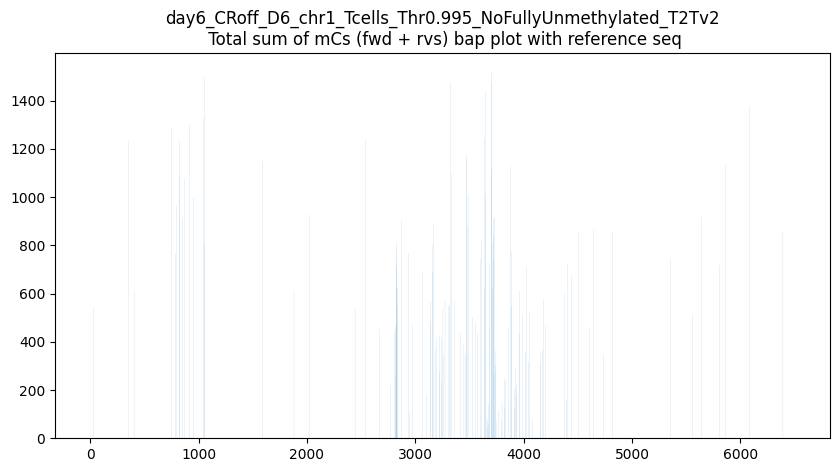

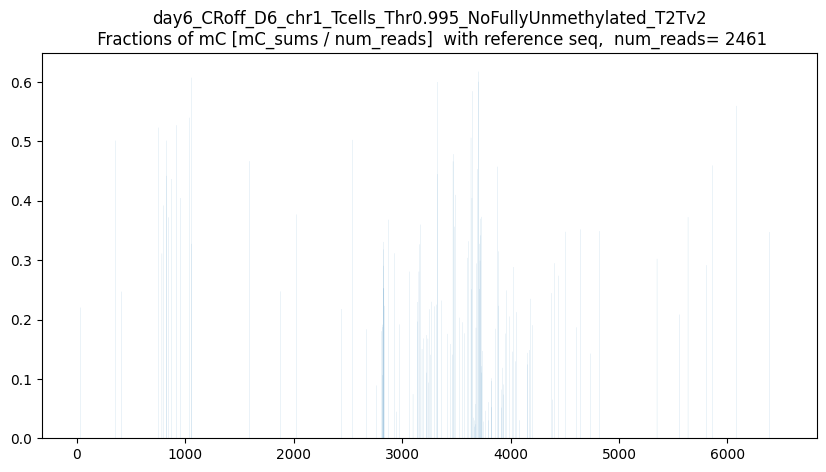

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



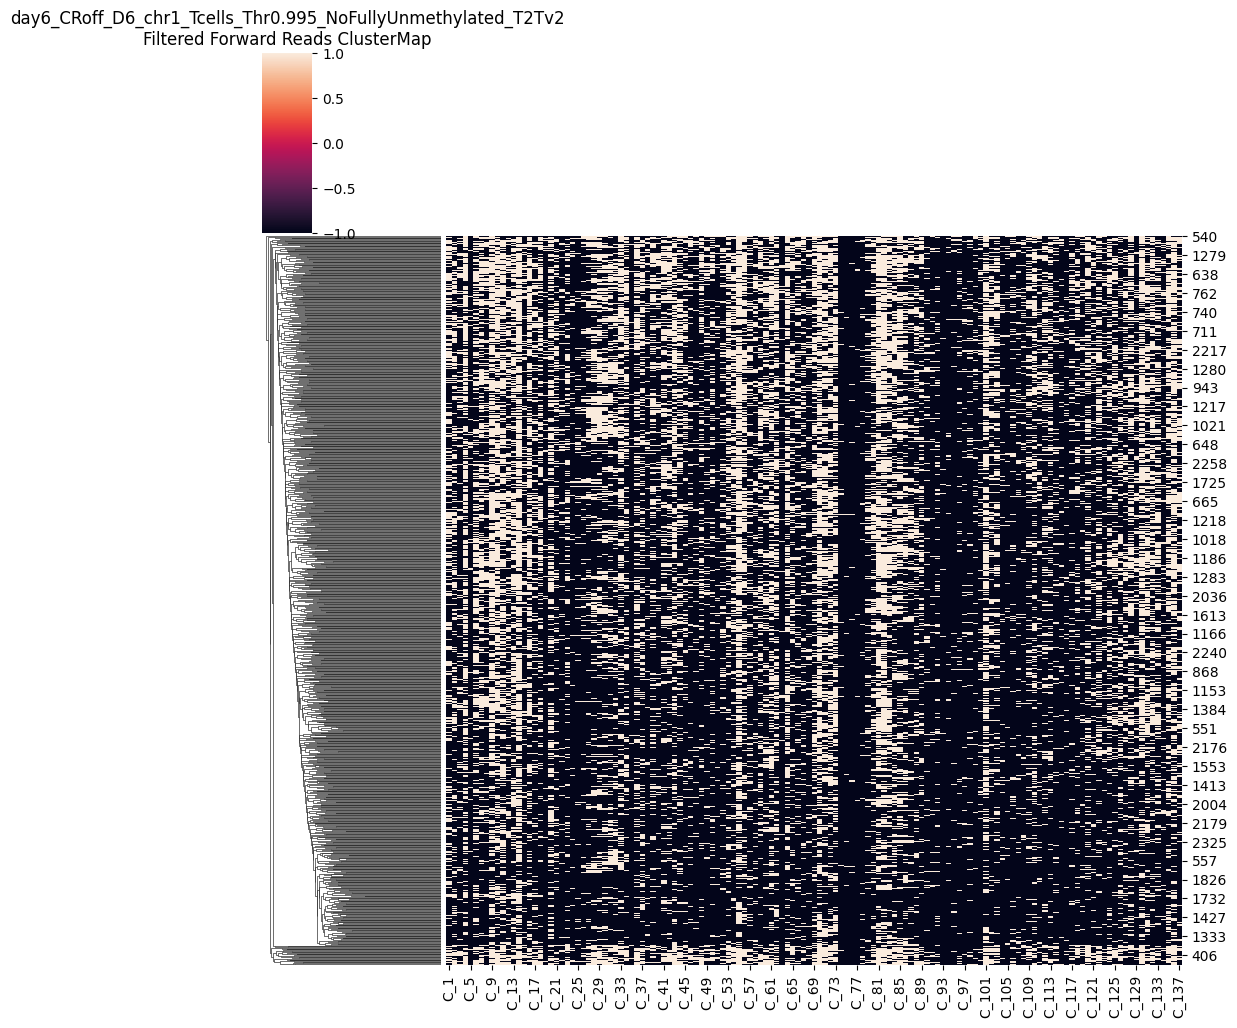

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



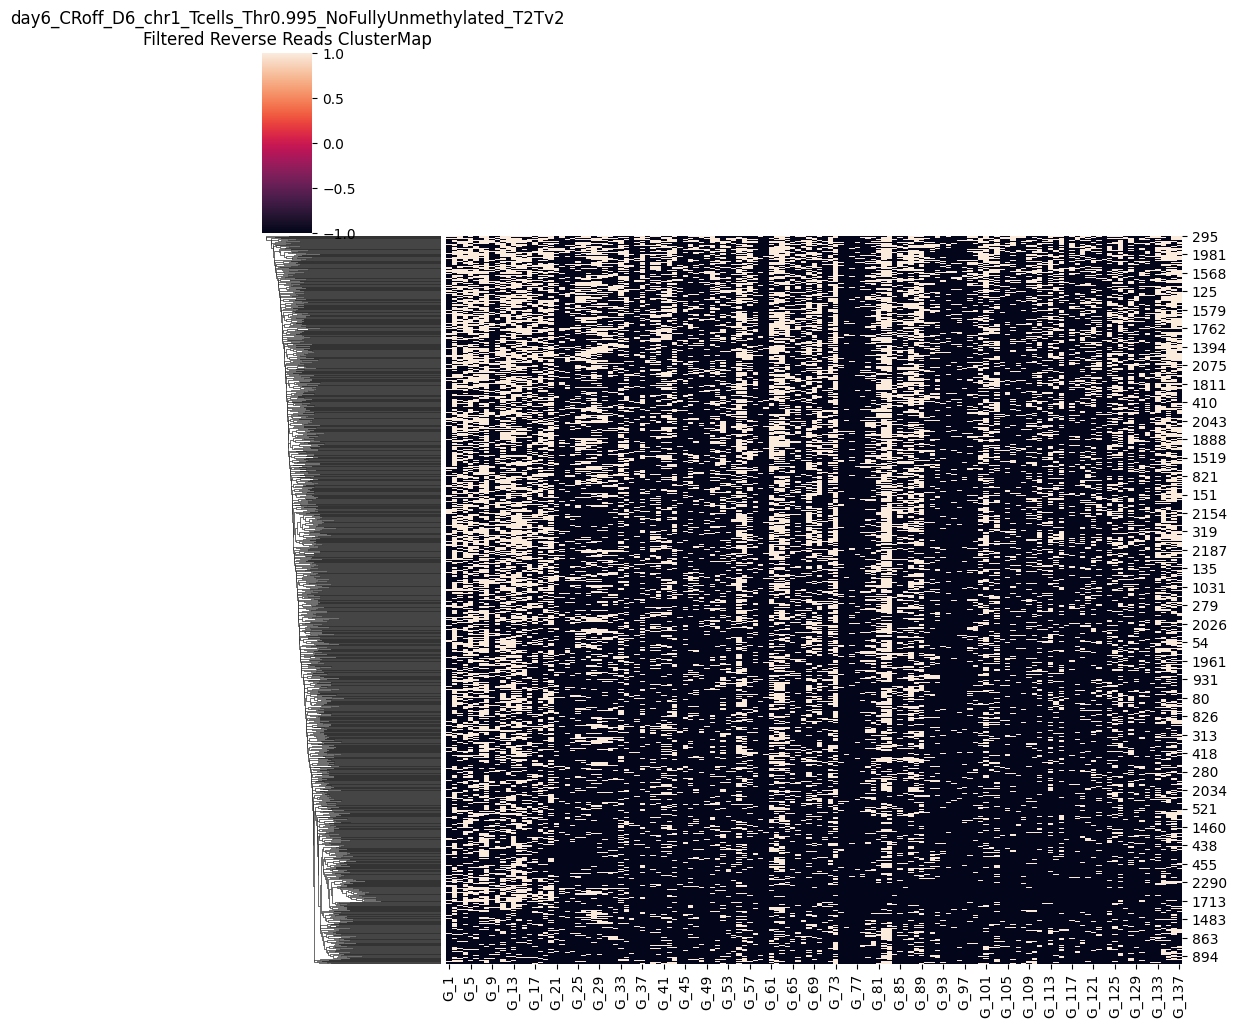

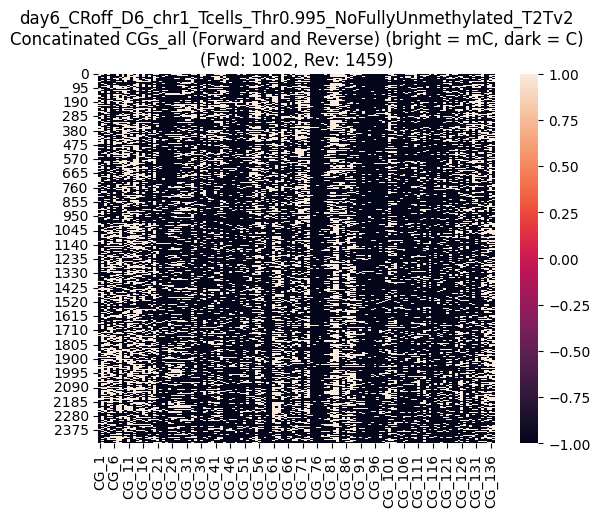

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



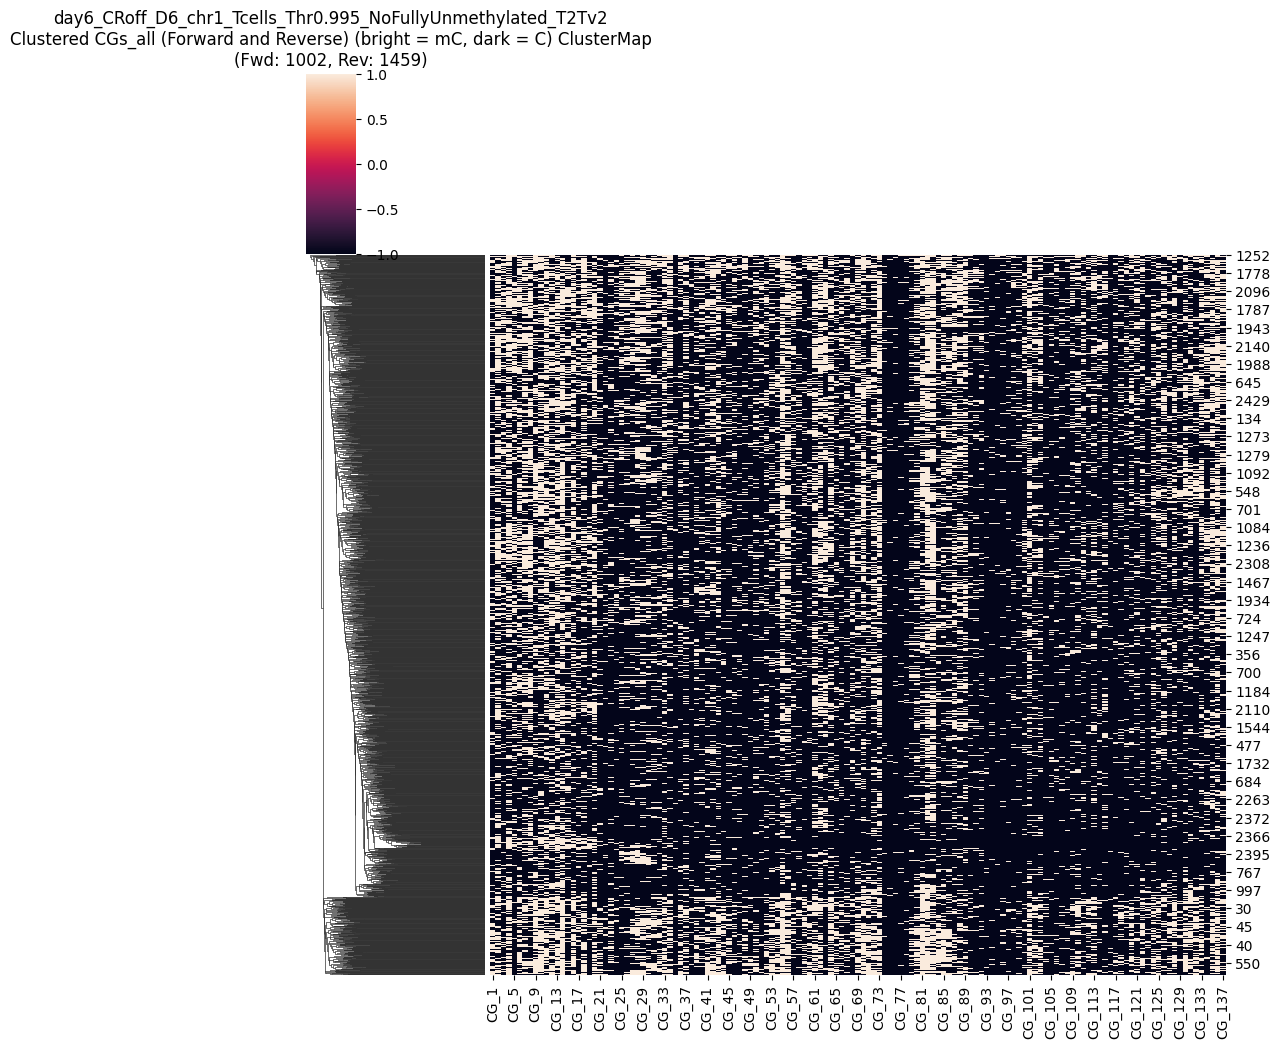

CGs_all saved as CG_137_removed_low50_methylated_padded_reads_day6_CRoff_D6_chr1_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2_mCthresh0.995_t2t_v2_0_chr1:206583354-206589854_2025-08-04_units_combined_numFWD1002_numRVS1459.npy in dimelo_v2_output
Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)


CG_1  CG_2  CG_3  CG_4  CG_5  CG_6  CG_7  CG_8  CG_9  CG_10  ...  \
0      1.0   1.0   NaN   1.0   NaN   1.0   NaN   NaN   1.0    1.0  ...   
1      NaN   NaN   NaN   NaN   NaN   NaN   1.0   1.0   NaN    NaN  ...   
2      NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN    NaN  ...   
3      NaN   1.0   NaN   1.0   NaN   NaN   1.0   NaN   1.0    1.0  ...   
4      NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   1.0    1.0  ...   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...    ...  ...   
2456   NaN   1.0   NaN   NaN   NaN   NaN   1.0   1.0   NaN    NaN  ...   
2457   NaN   1.0   NaN   NaN   1.0   NaN   NaN   1.0   1.0    1.0  ...   
2458   1.0   1.0   NaN   NaN   1.0   NaN   NaN   1.0   1.0    1.0  ...   
2459   NaN   1.0   NaN   1.0   NaN   NaN   1.0   1.0   1.0    NaN  ...   
2460   NaN   NaN   NaN   1.0   NaN   NaN   1.0   1.0   NaN    NaN  ...   

      CG_128  CG_129  CG_130  CG_131  CG_132  CG_133  CG_134  CG_135  CG_136  \
0        NaN     NaN     1.0     1.0     1.0     1.0     NaN     1.0     NaN   
1        NaN     NaN     1.0     NaN     NaN     NaN     NaN     NaN     NaN   
2        NaN     NaN     1.0     NaN     1.0     1.0     NaN     NaN     NaN   
3        NaN     NaN     1.0     1.0     NaN     1.0     NaN     1.0     1.0   
4        NaN     1.0     1.0     NaN     1.0     NaN     NaN     1.0     1.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2456     NaN     NaN     NaN     NaN     NaN     NaN     NaN     1.0     1.0   
2457     NaN     1.0     NaN     NaN     NaN     NaN     NaN     1.0     1.0   
2458     1.0     NaN     NaN     NaN     NaN     1.0     1.0     NaN     NaN   
2459     1.0     NaN     1.0     NaN     NaN     NaN     NaN     NaN     NaN   
2460     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

      CG_137  
0        1.0  
1        NaN  
2        NaN  
3        NaN  
4        1.0  
...      ...  
2456     NaN  
2457     NaN  
2458     1.0  
2459     NaN  
2460     NaN  

[2461 rows x 137 columns]

In [11]:
threshold_percent = 50
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_CRoff_D6_mc0995_remove_low50 = CGs_all
CGs_all_CRoff_D6_mc0995_remove_low50


Mean methylated CGs per read: 28.0
Maximum methylated CGs per read: 74.0
Threshold (10% of max): 2.80
Original number of reads: 3367
Number of reads after filtering: 3213
Removed 154 reads


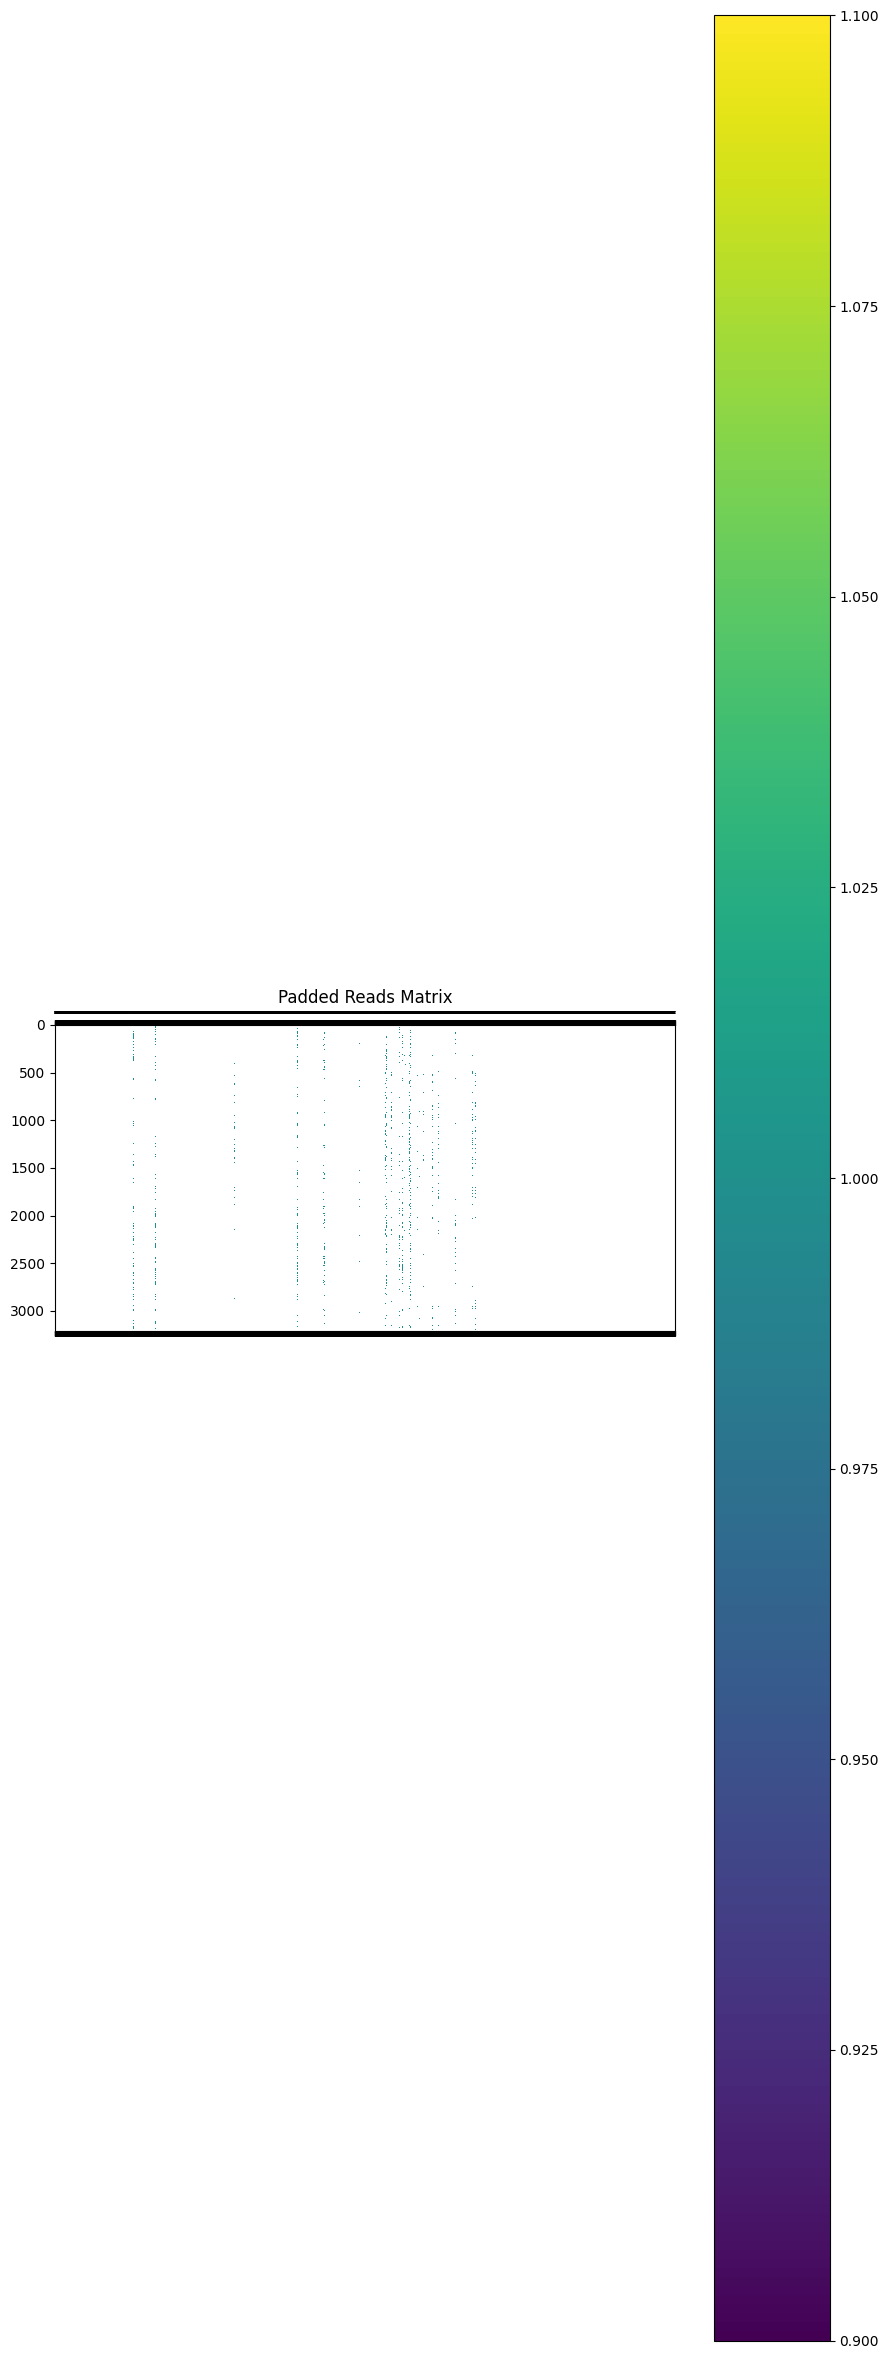

Padded reads saved to removed_low10_methylated_padded_reads_day6_CRoff_D6_chr1_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2_mCthresh0.995_t2t_v2_0_chr1:206583354-206589854_2025-08-04.npy
Padded reads loaded successfully.


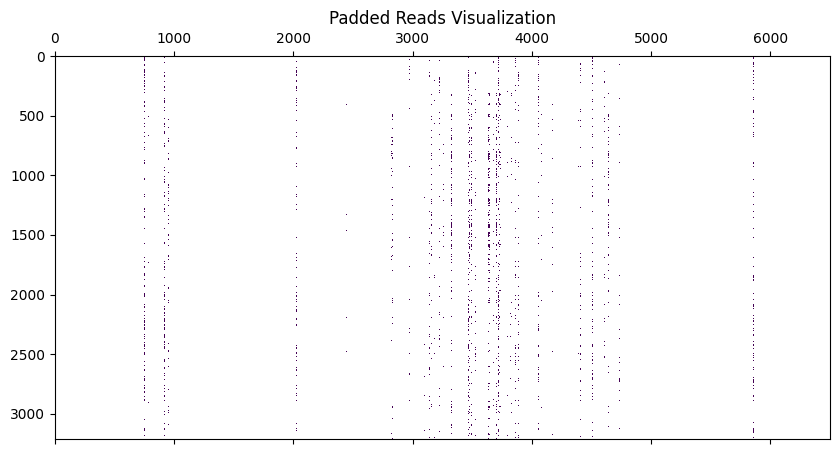

Visualization completed.
Region length: 6500
GTCATTGTATGGTTCCTGGGATAAGAGTAAGAACCGTGGTCCCTTGCTCTGTCAAAATCATAAACCTATTTTCTTTGTATTTTGACTTAATTACATAAGCTTGTTTTGGATTGGAAGGTCTATAGAGACTATTTTAGTGCCAAATGCTATTTAATCAATGCAGAAATAAGCCCTTGAGAGGTGCAGTGACTCAGCTGAGGACACACTGATAGTTTCTGGTAGATAAGTATGAAGCCTTGGAACTACTTCTCATATCATAAGCCCCTGGGTTCCCAAATCACCTCCCCAAGTACCTAATTCATCATCCTCTGCATACAAGAAATTTTTGCTCATTCCAATAAAAAGAATGTAGTACGGCAGGACAGGAGAAGTACAGGTTTTGGAATCAAACTAGGTTTAGATTCTGACCTGGTCGCTAGTTAGTGCATGGGCTTTGGTAAACAGCCTCTCAGCCTGTTTCCTTGTCTGCAAAATATGGATAGTTATCTTCACTTCATGAAGTTGTGTTGGTGAAATGGTATAATGTGTATAAAGCAACTGGAACACAACAAATGAGGCCATTTATTTAAAATAATCTTTAGTAAGTTATAAATTCACATATTTGCTTTTTTCTGAGGAATGCTTAGATTTTATCATAGATCTCTTTTCTAAATTGAGTAAATACATAGTGGATTTCTTTGTTTCCTTCCCCTCAGAATGTTGAAATTTGGCTGATTGTAACTATTACTTAAGACTCTATCCAGTAATTGTTCGTAAAATTTCTTTTCTTTTTTTTTTTTTGAGACGGAGTTTTGCTCTCGTCCCCCAGGCTGGAGTGCAATGGCGCGATCTTGGCTCACTGCAACCTCCGCCTCCCAGGTTCAAGTGATTCTCCCGCCTCAGCCTCCCAAGTAGCTGGGATTACAGGCACCTGCCACAACGCCCAGCCAATTTTTGTATTTTTAGTAGAGACGGG

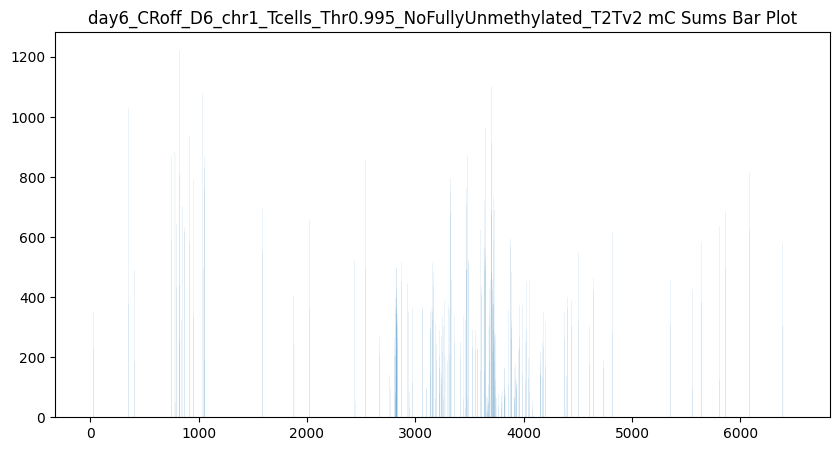

(mC_sums / len(CGs_all) = [0. 0. 0. ... 0. 0. 0.]


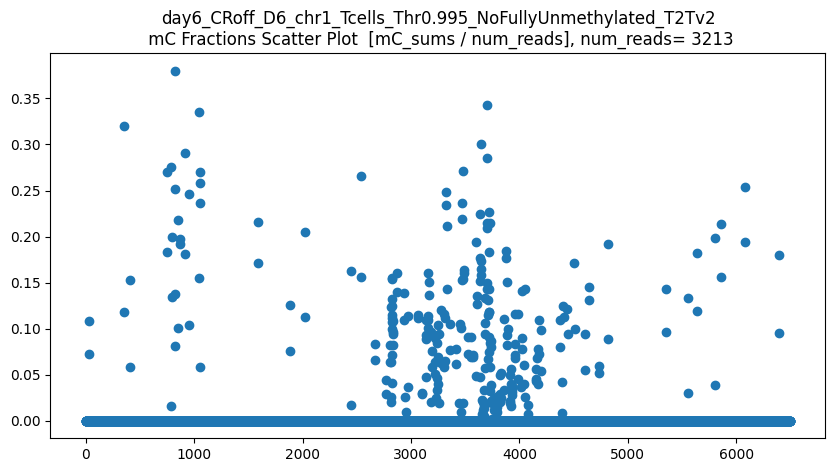

len(CGs_all) = 3213
CGs_all.shape = (3213, 137)
len(CGs_all_on_fwd_C_sums) = 6500
CGs_all_on_fwd_C_sums.shape = (6500,)


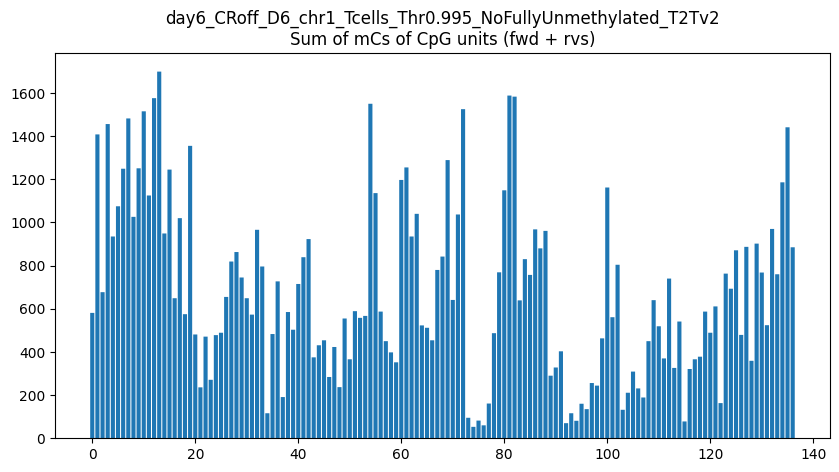

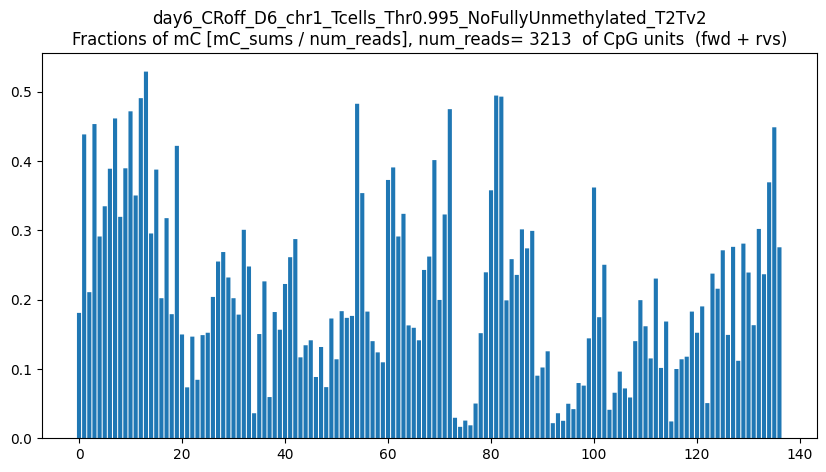

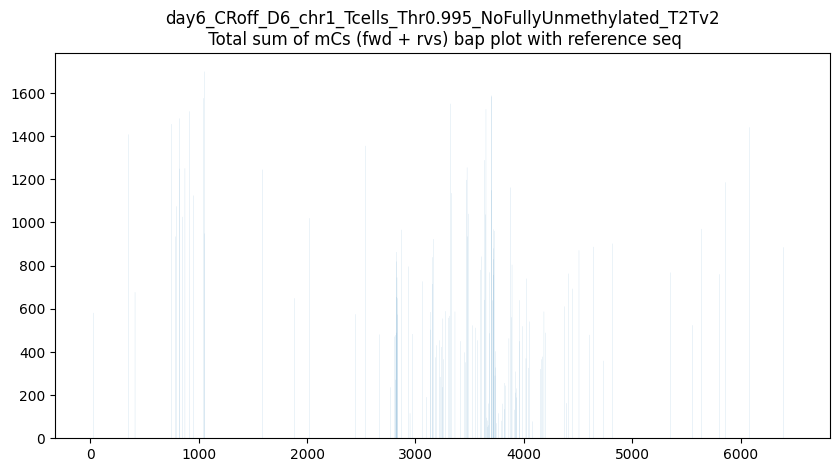

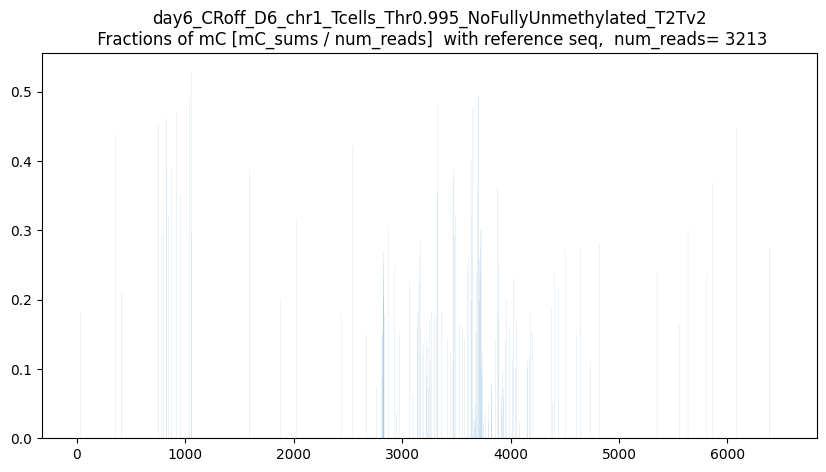

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



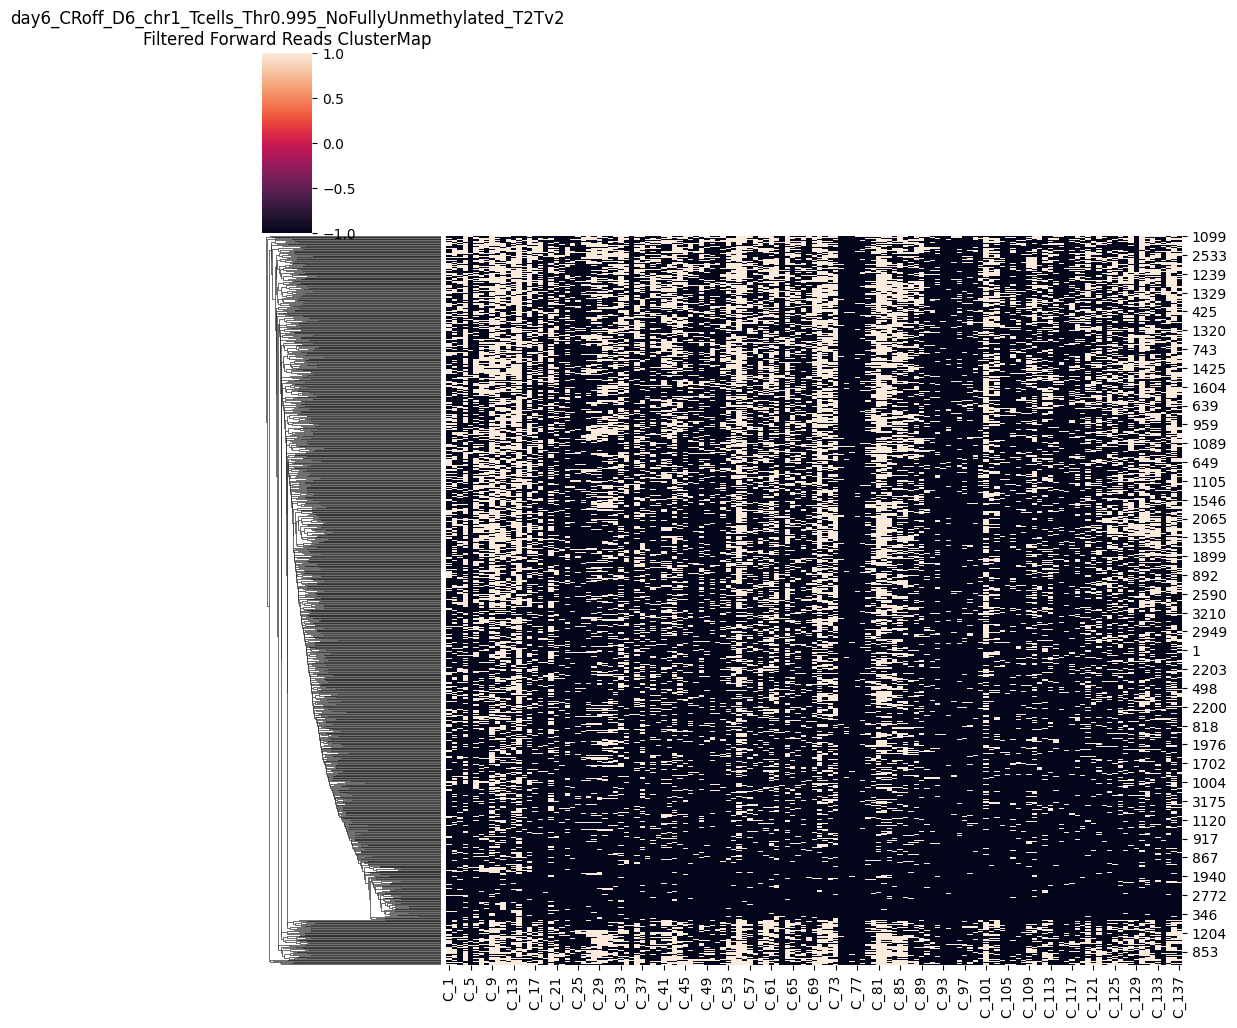

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



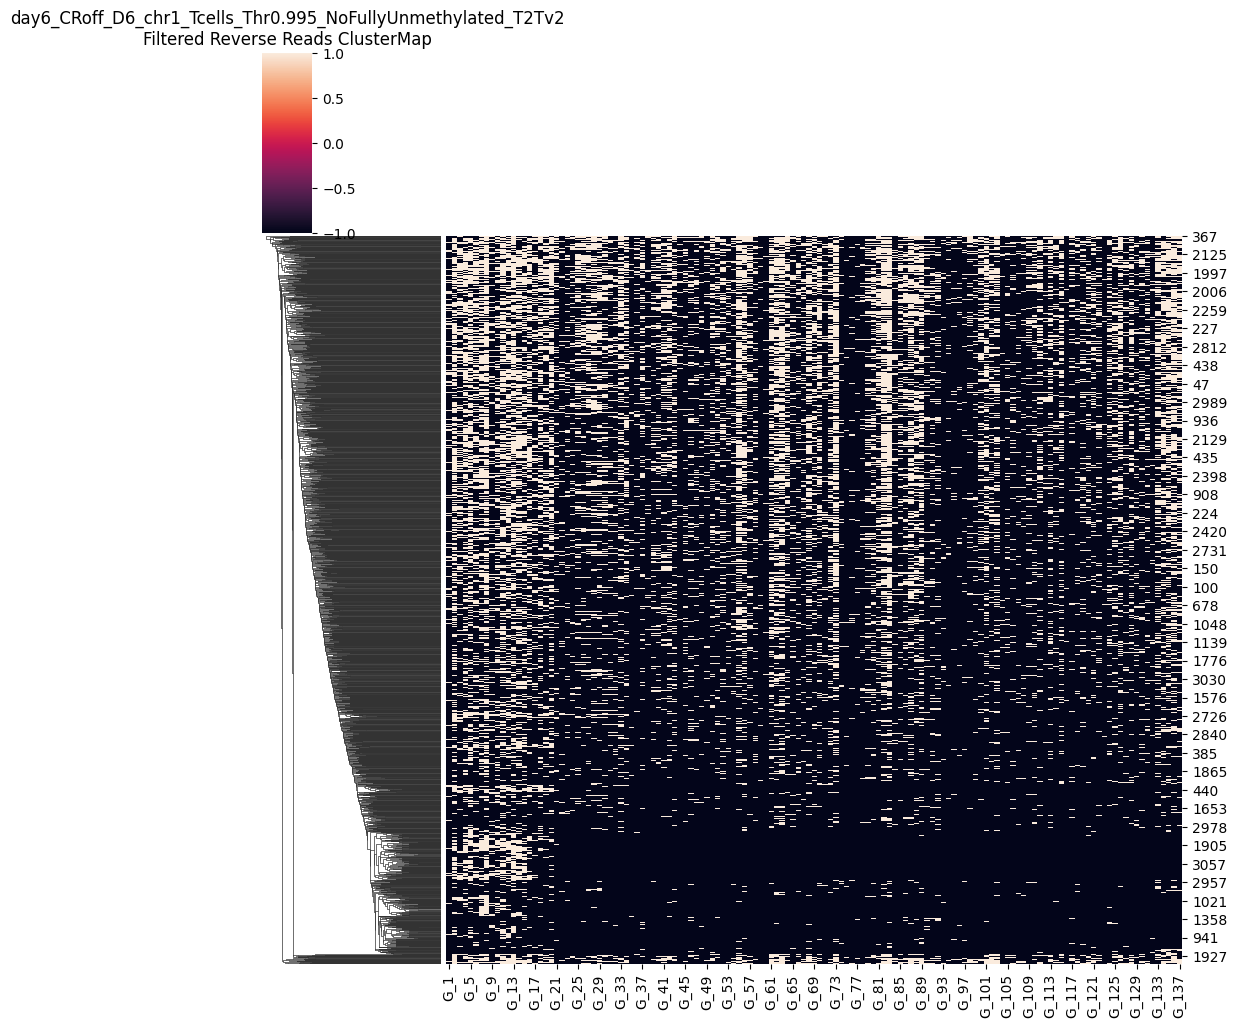

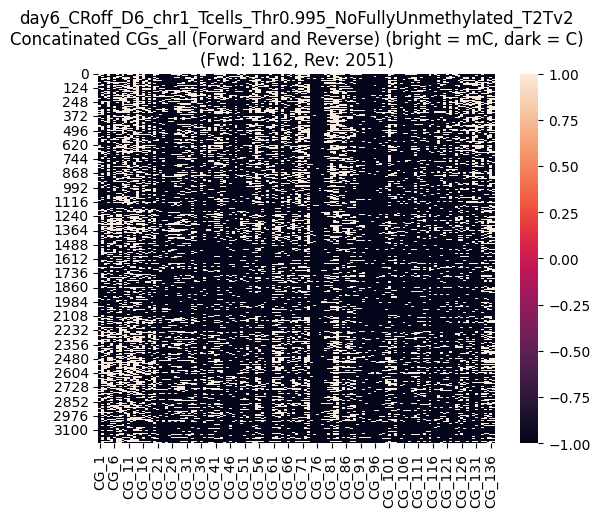

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



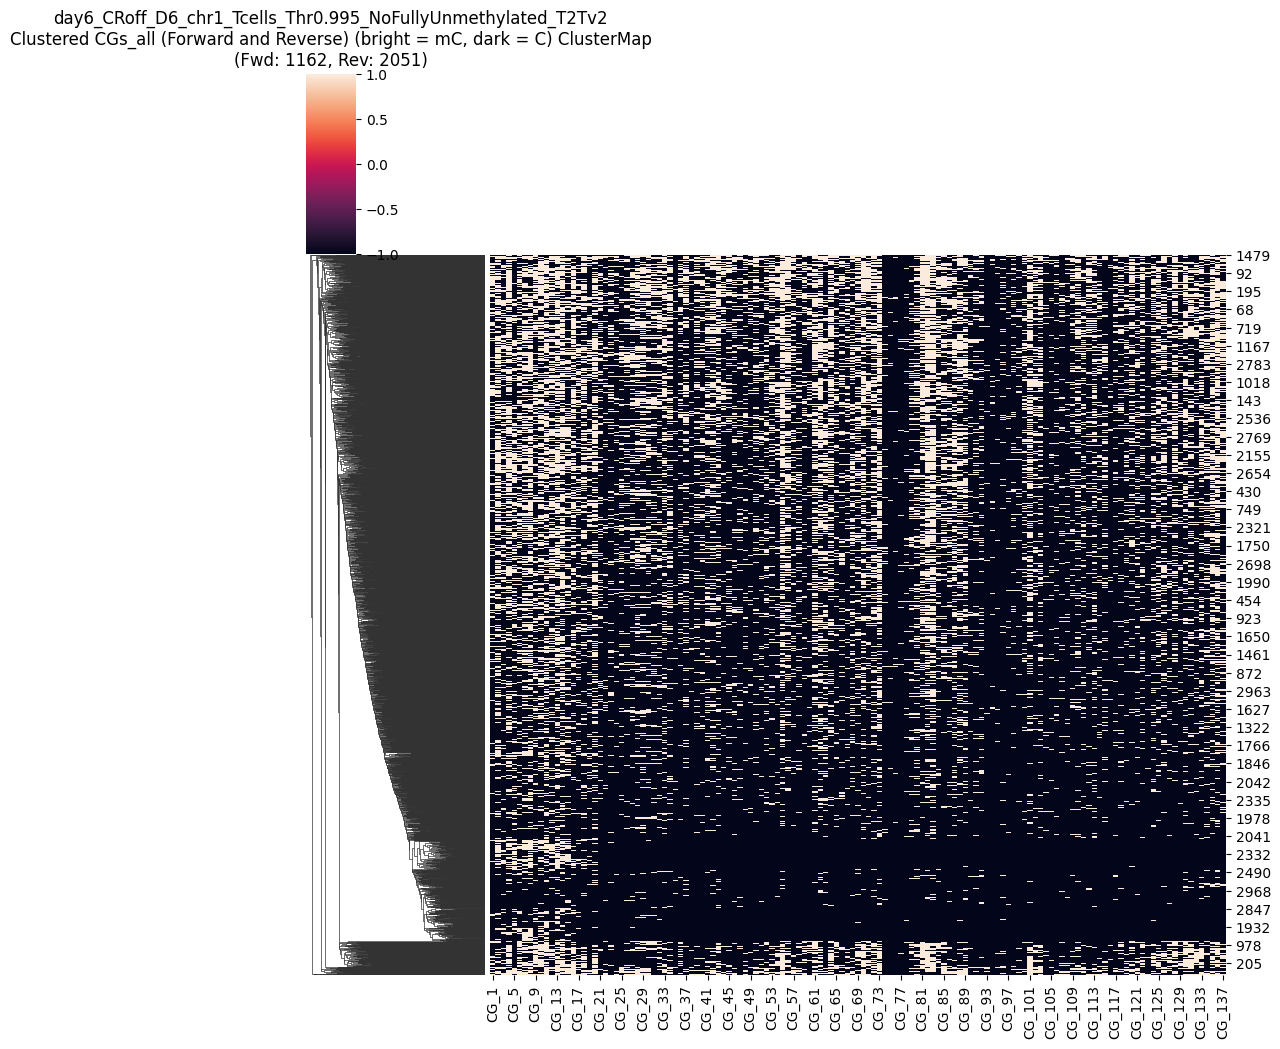

CGs_all saved as CG_137_removed_low10_methylated_padded_reads_day6_CRoff_D6_chr1_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2_mCthresh0.995_t2t_v2_0_chr1:206583354-206589854_2025-08-04_units_combined_numFWD1162_numRVS2051.npy in dimelo_v2_output
Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)


CG_1  CG_2  CG_3  CG_4  CG_5  CG_6  CG_7  CG_8  CG_9  CG_10  ...  \
0      1.0   1.0   NaN   1.0   NaN   1.0   NaN   NaN   1.0    1.0  ...   
1      NaN   NaN   NaN   NaN   NaN   NaN   1.0   1.0   NaN    NaN  ...   
2      NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN    NaN  ...   
3      NaN   1.0   NaN   1.0   NaN   NaN   1.0   NaN   1.0    1.0  ...   
4      1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    1.0  ...   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...    ...  ...   
3208   NaN   1.0   NaN   NaN   1.0   NaN   NaN   1.0   1.0    1.0  ...   
3209   1.0   1.0   NaN   NaN   1.0   NaN   NaN   1.0   1.0    1.0  ...   
3210   NaN   1.0   NaN   1.0   NaN   NaN   1.0   1.0   1.0    NaN  ...   
3211   NaN   1.0   1.0   NaN   1.0   1.0   NaN   1.0   NaN    NaN  ...   
3212   NaN   NaN   NaN   1.0   NaN   NaN   1.0   1.0   NaN    NaN  ...   

      CG_128  CG_129  CG_130  CG_131  CG_132  CG_133  CG_134  CG_135  CG_136  \
0        NaN     NaN     1.0     1.0     1.0     1.0     NaN     1.0     NaN   
1        NaN     NaN     1.0     NaN     NaN     NaN     NaN     NaN     NaN   
2        NaN     NaN     1.0     NaN     1.0     1.0     NaN     NaN     NaN   
3        NaN     NaN     1.0     1.0     NaN     1.0     NaN     1.0     1.0   
4        1.0     NaN     NaN     1.0     NaN     NaN     NaN     NaN     1.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
3208     NaN     1.0     NaN     NaN     NaN     NaN     NaN     1.0     1.0   
3209     1.0     NaN     NaN     NaN     NaN     1.0     1.0     NaN     NaN   
3210     1.0     NaN     1.0     NaN     NaN     NaN     NaN     NaN     NaN   
3211     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3212     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

      CG_137  
0        1.0  
1        NaN  
2        NaN  
3        NaN  
4        NaN  
...      ...  
3208     NaN  
3209     1.0  
3210     NaN  
3211     NaN  
3212     NaN  

[3213 rows x 137 columns]

In [12]:
threshold_percent = 10
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_CRoff_D6_mc0995_remove_low10 = CGs_all
CGs_all_CRoff_D6_mc0995_remove_low10


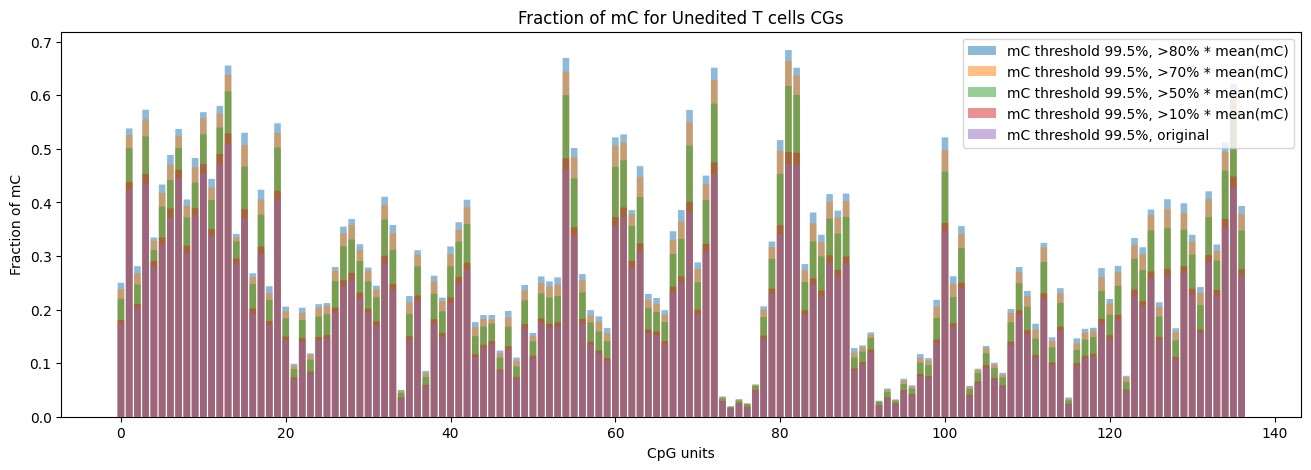

In [16]:
CGs_all_pd = CGs_all_CRoff_D6_mc0995_remove_low80
CGs_all_0995_remove_low80_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_0995_remove_low80_frac = CGs_all_0995_remove_low80_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_CRoff_D6_mc0995_remove_low70
CGs_all_0995_remove_low70_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_0995_remove_low70_frac = CGs_all_0995_remove_low70_sums  / len(CGs_all_pd) 


CGs_all_pd = CGs_all_CRoff_D6_mc0995_remove_low50
CGs_all_0995_remove_low50_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_0995_remove_low50_frac = CGs_all_0995_remove_low50_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_CRoff_D6_mc0995_remove_low10
CGs_all_0995_remove_low10_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_0995_remove_low10_frac = CGs_all_0995_remove_low10_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_CRoff_D6_mc0995_original
CGs_all_mc0995_orifinal_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_mc0995_orifinal_frac = CGs_all_mc0995_orifinal_sums  / len(CGs_all_pd) 



plt.figure(figsize=(16, 5))
plt.bar(np.arange(len(CGs_all_0995_remove_low80_frac)), CGs_all_0995_remove_low80_frac, snap=False, alpha=0.5, label='mC threshold 99.5%, >80% * mean(mC)')
plt.bar(np.arange(len(CGs_all_0995_remove_low70_sums)), CGs_all_0995_remove_low70_frac, snap=False, alpha=0.5, label='mC threshold 99.5%, >70% * mean(mC)')
plt.bar(np.arange(len(CGs_all_0995_remove_low50_frac)), CGs_all_0995_remove_low50_frac, snap=False, alpha=0.5, label='mC threshold 99.5%, >50% * mean(mC)')
plt.bar(np.arange(len(CGs_all_0995_remove_low10_frac)), CGs_all_0995_remove_low10_frac, snap=False, alpha=0.5, label='mC threshold 99.5%, >10% * mean(mC)')
plt.bar(np.arange(len(CGs_all_mc0995_orifinal_frac)), CGs_all_mc0995_orifinal_frac, snap=False, alpha=0.5, label='mC threshold 99.5%, original')

# Add labels and title
plt.xlabel('CpG units')
plt.ylabel('Fraction of mC')
plt.title('Fraction of mC for Unedited T cells CGs')
plt.legend()

# Show the plot
plt.show()

# --------------------------------------

# mC confidence in calling > 95%

/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/croff
experiment_name =  day6_CRoff_D6_chr1_Tcells_Thr0.95_NoFullyUnmethylated_T2Tv2
Region length: 6500
No specified number of cores requested. 24 available on machine, allocating all.
Modification threshold of 0.95 will be treated as coming from range 0-1.


          | Step 1: Identify motif locations in up_chm13v2.0.fasta   0% | 00:00

          | Step 2: Parse regions in chr1_206560169_206614236.sort_align_t2t_v2_0_trim_20241226_MR_nCATs_TPrES…

          |    0%

          | Transferring 10130 from reads.CG,0.txt into reads.combined_basemods.h5, new size 10130   0% | 00:0…

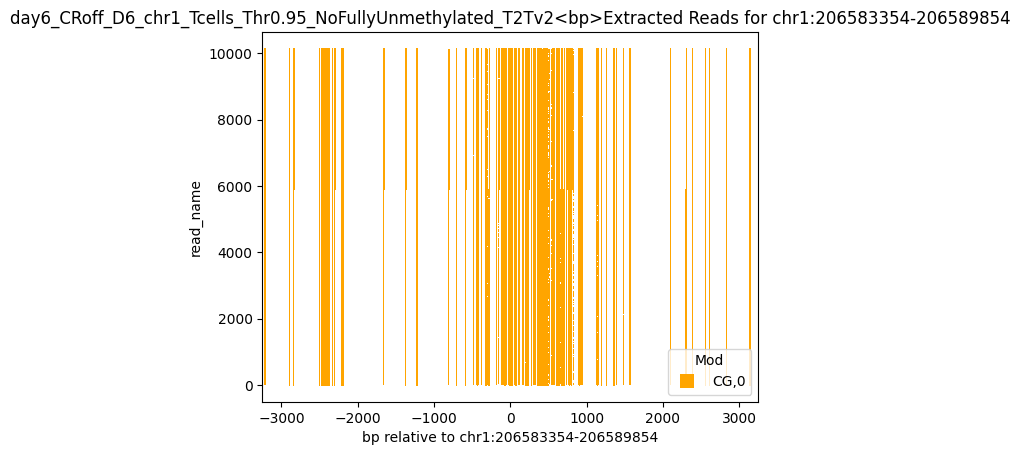

Found read coordinates: 10130 reads
Unique read names with methylation: 10012
Found 3453 reads with full coverage
Reads with methylation data: 10012
Overlap between full coverage and methylation: 3422
After full coverage filtering: 149228 reads with methylation data
Final result: 149228 reads with methylation information out of 10130 total reads


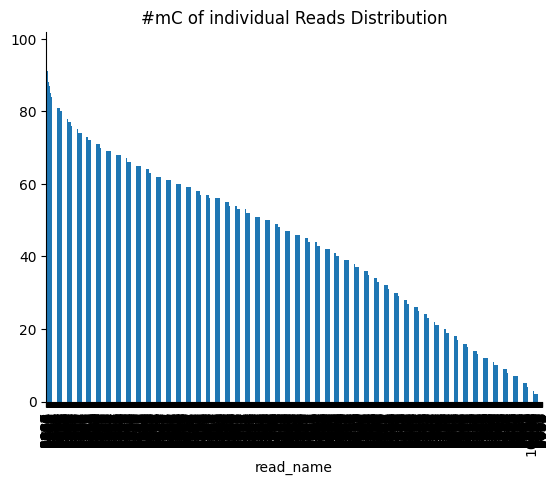

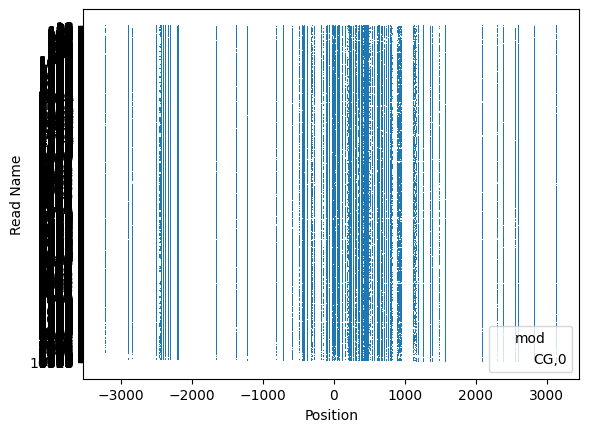

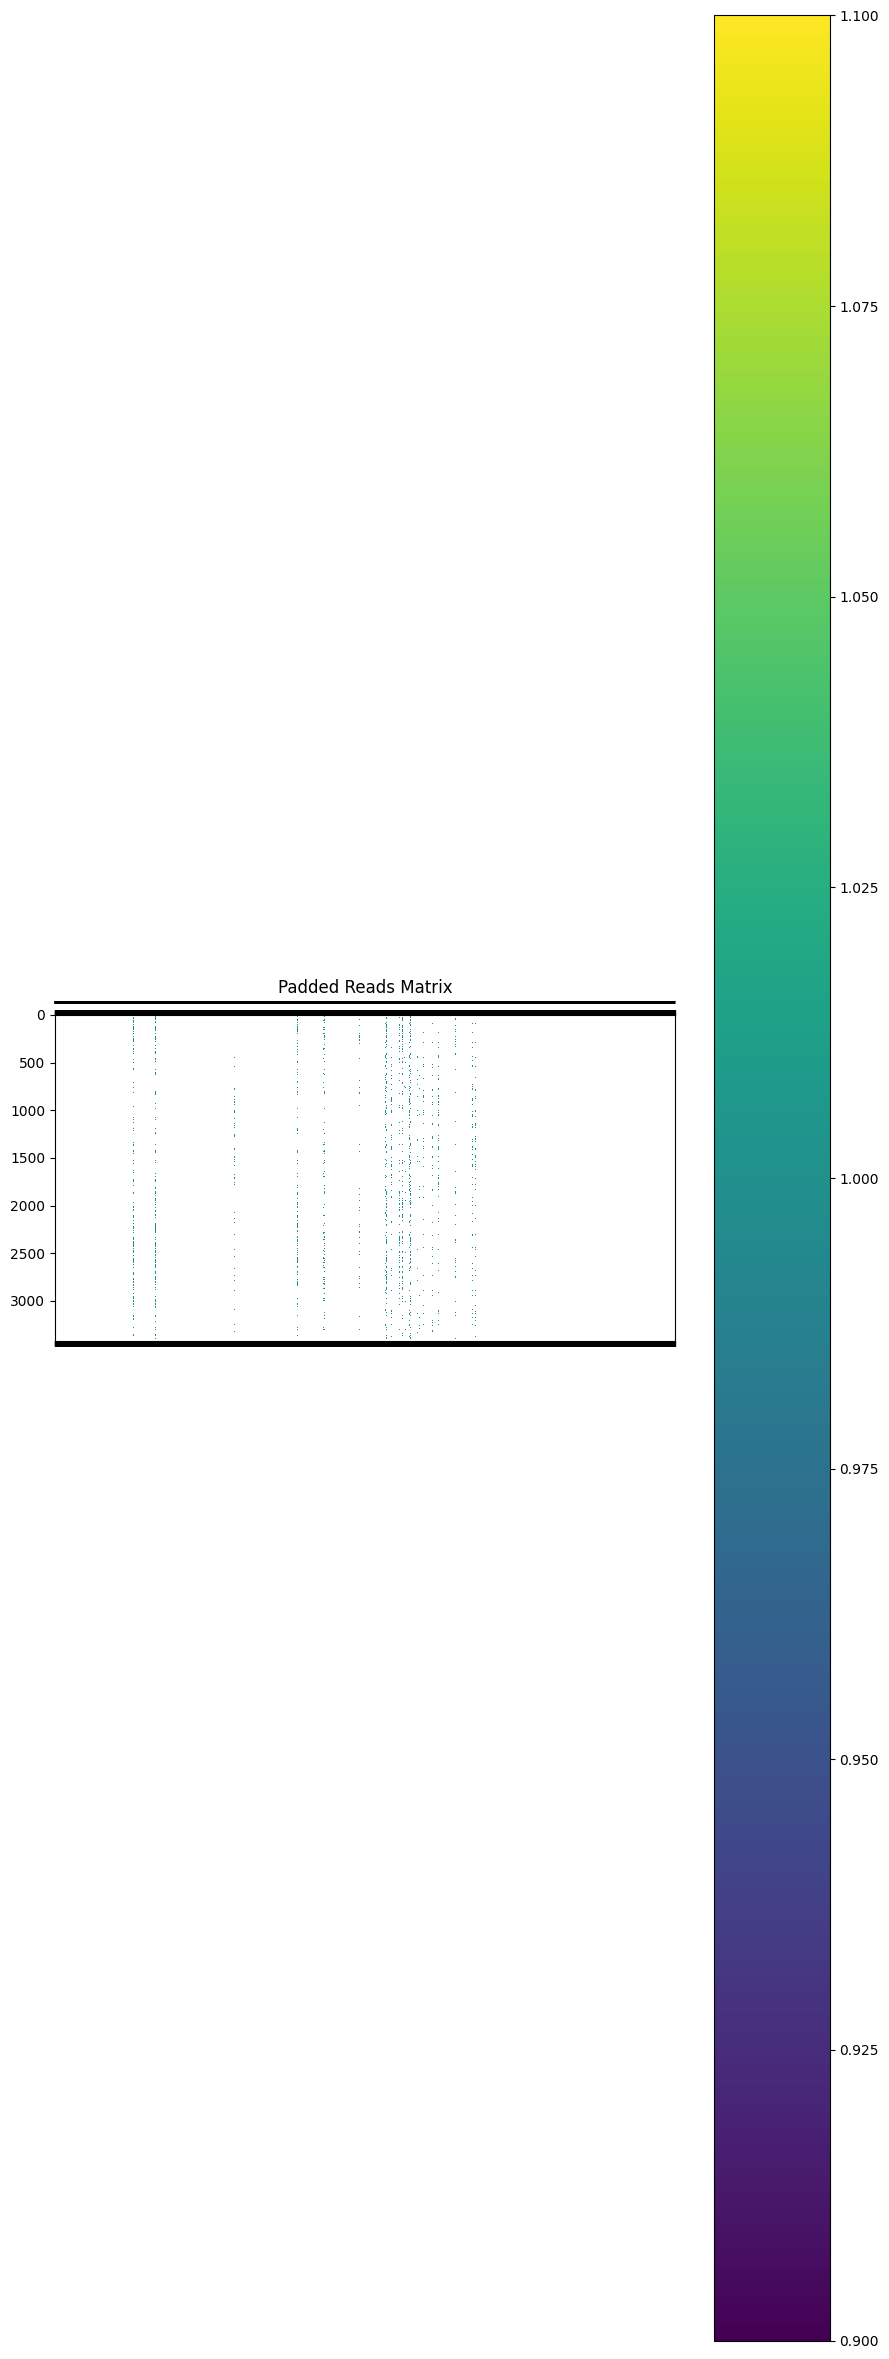

Padded reads saved to padded_reads_day6_CRoff_D6_chr1_Tcells_Thr0.95_NoFullyUnmethylated_T2Tv2_mCthresh0.95_t2t_v2_0_chr1:206583354-206589854_2025-08-04.npy
Padded reads loaded successfully.


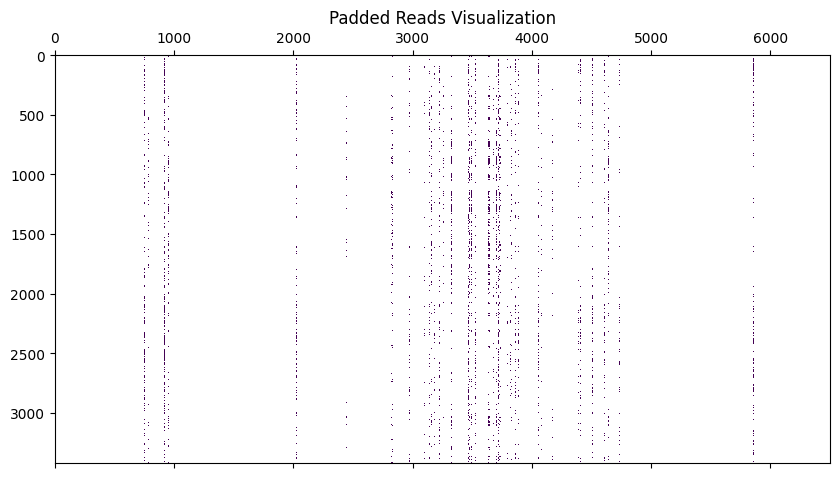

Visualization completed.
Region length: 6500
GTCATTGTATGGTTCCTGGGATAAGAGTAAGAACCGTGGTCCCTTGCTCTGTCAAAATCATAAACCTATTTTCTTTGTATTTTGACTTAATTACATAAGCTTGTTTTGGATTGGAAGGTCTATAGAGACTATTTTAGTGCCAAATGCTATTTAATCAATGCAGAAATAAGCCCTTGAGAGGTGCAGTGACTCAGCTGAGGACACACTGATAGTTTCTGGTAGATAAGTATGAAGCCTTGGAACTACTTCTCATATCATAAGCCCCTGGGTTCCCAAATCACCTCCCCAAGTACCTAATTCATCATCCTCTGCATACAAGAAATTTTTGCTCATTCCAATAAAAAGAATGTAGTACGGCAGGACAGGAGAAGTACAGGTTTTGGAATCAAACTAGGTTTAGATTCTGACCTGGTCGCTAGTTAGTGCATGGGCTTTGGTAAACAGCCTCTCAGCCTGTTTCCTTGTCTGCAAAATATGGATAGTTATCTTCACTTCATGAAGTTGTGTTGGTGAAATGGTATAATGTGTATAAAGCAACTGGAACACAACAAATGAGGCCATTTATTTAAAATAATCTTTAGTAAGTTATAAATTCACATATTTGCTTTTTTCTGAGGAATGCTTAGATTTTATCATAGATCTCTTTTCTAAATTGAGTAAATACATAGTGGATTTCTTTGTTTCCTTCCCCTCAGAATGTTGAAATTTGGCTGATTGTAACTATTACTTAAGACTCTATCCAGTAATTGTTCGTAAAATTTCTTTTCTTTTTTTTTTTTTGAGACGGAGTTTTGCTCTCGTCCCCCAGGCTGGAGTGCAATGGCGCGATCTTGGCTCACTGCAACCTCCGCCTCCCAGGTTCAAGTGATTCTCCCGCCTCAGCCTCCCAAGTAGCTGGGATTACAGGCACCTGCCACAACGCCCAGCCAATTTTTGTATTTTTAGTAGAGACGGG

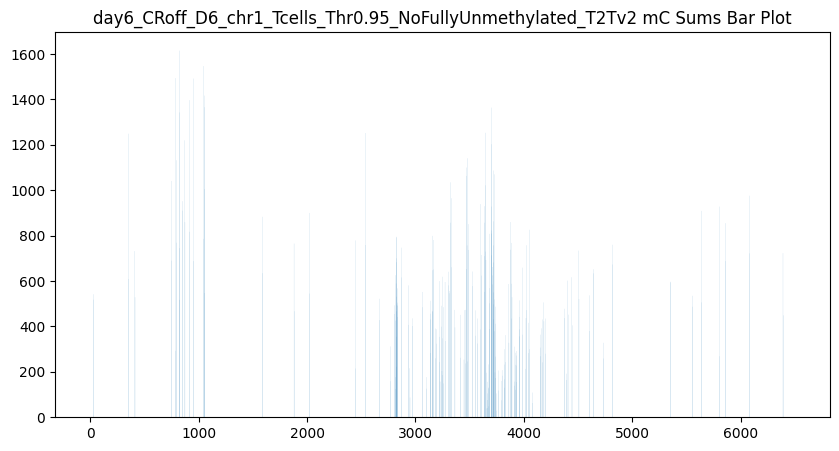

(mC_sums / len(CGs_all) = [0. 0. 0. ... 0. 0. 0.]


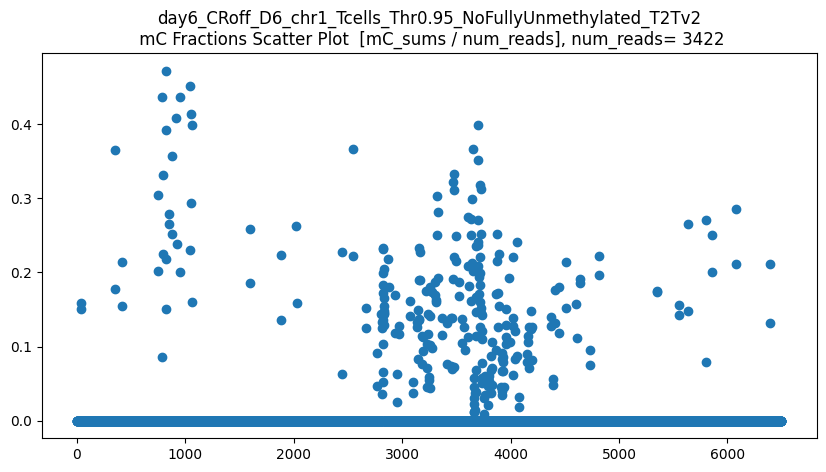

len(CGs_all) = 3422
CGs_all.shape = (3422, 137)
len(CGs_all_on_fwd_C_sums) = 6500
CGs_all_on_fwd_C_sums.shape = (6500,)


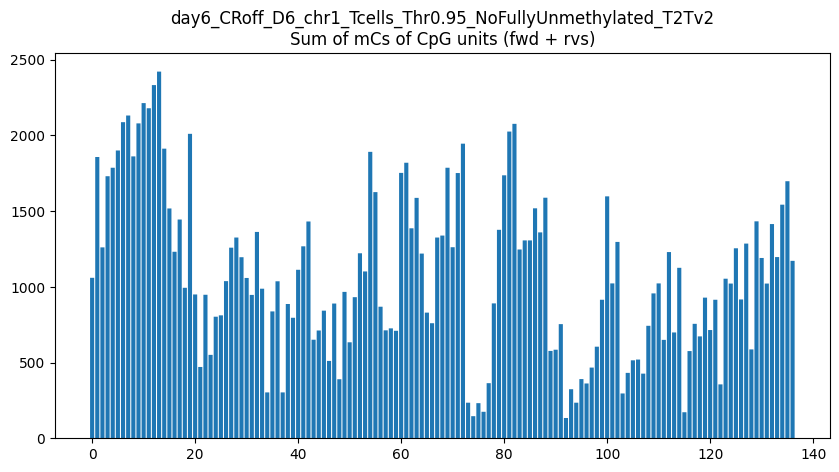

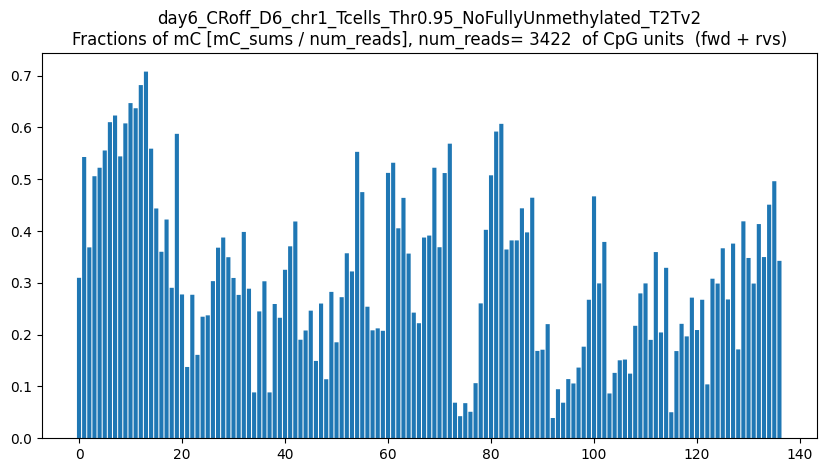

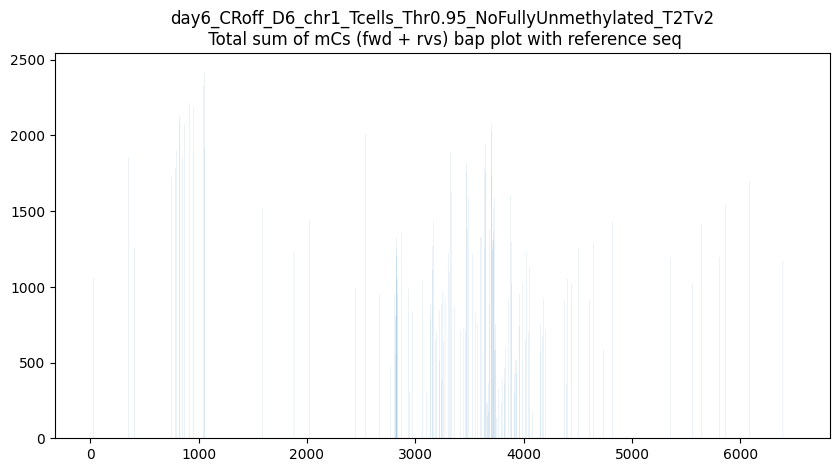

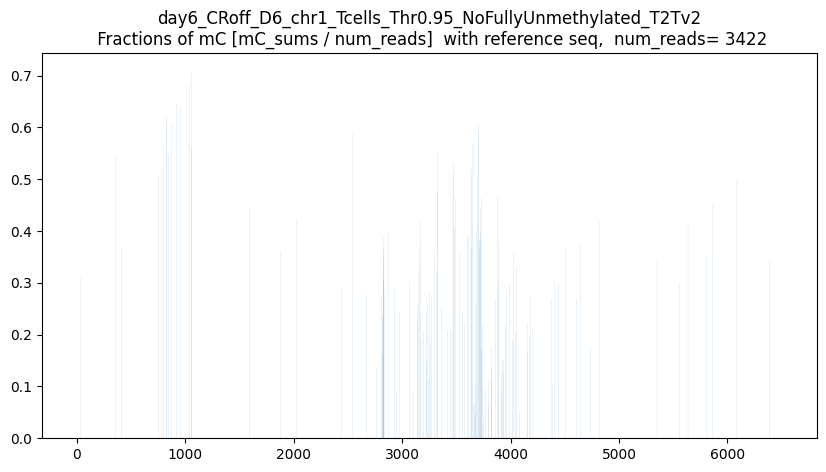

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



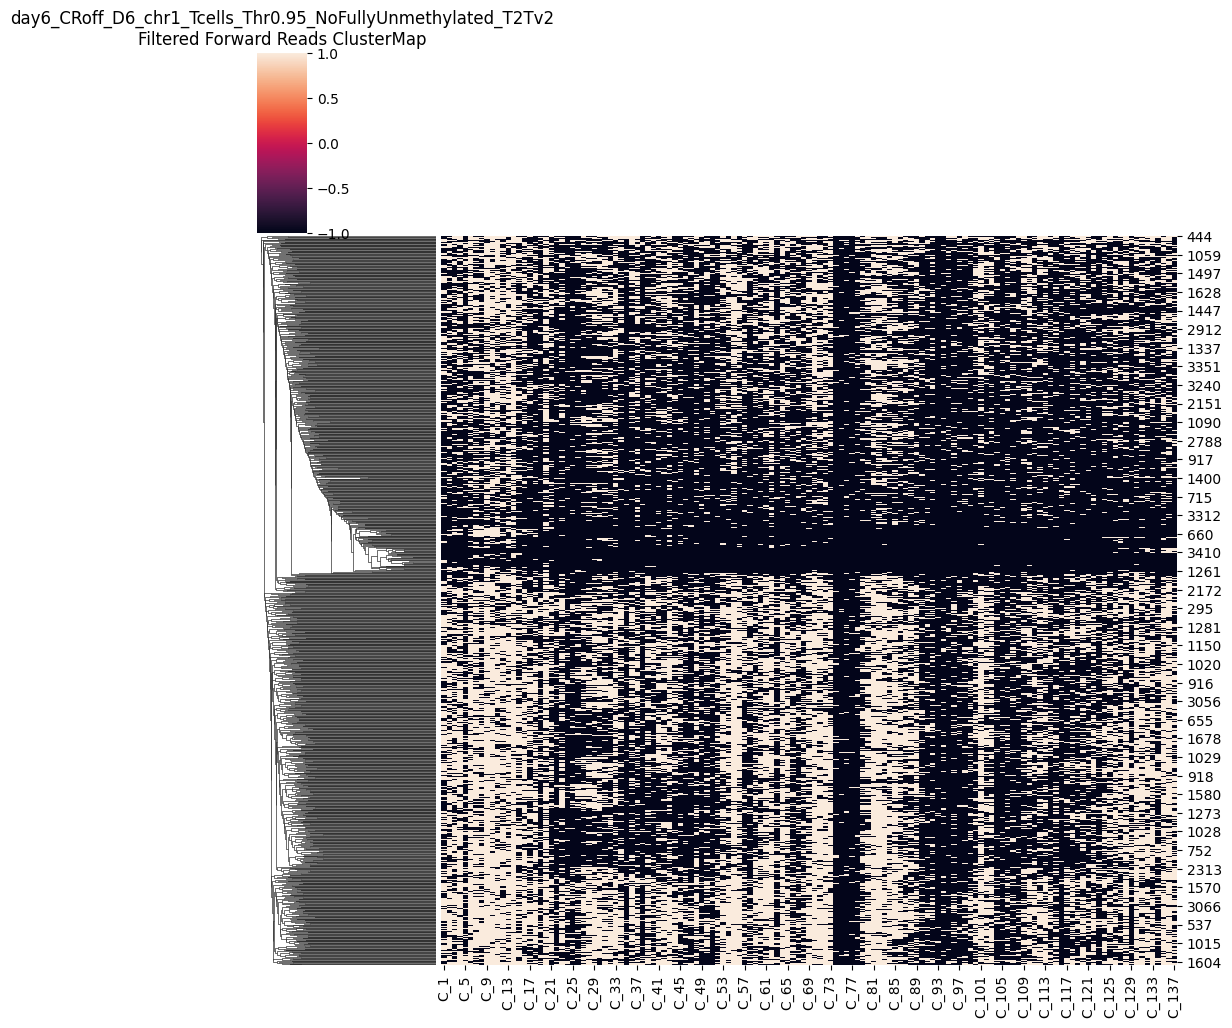

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



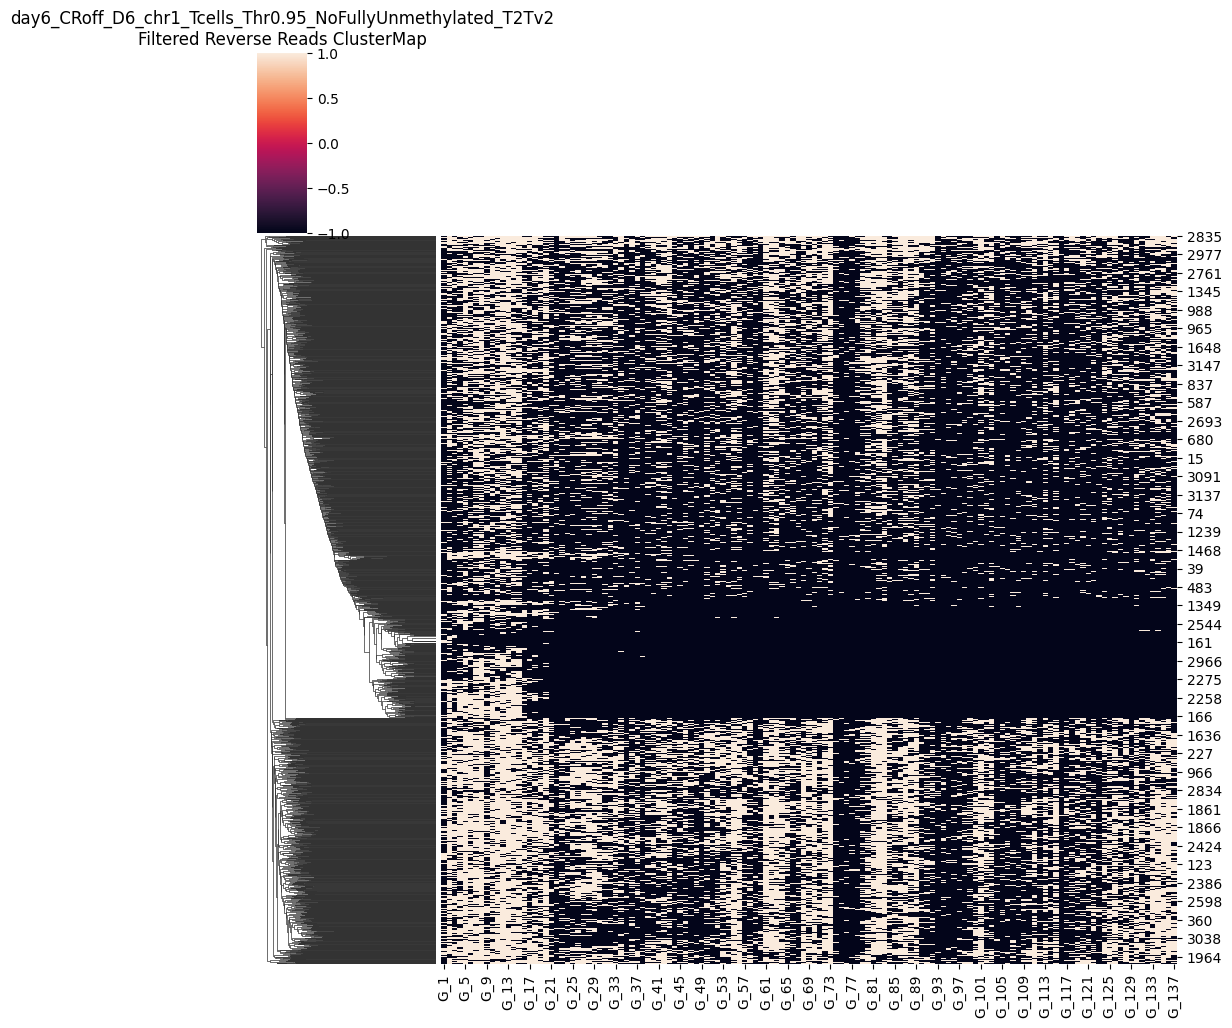

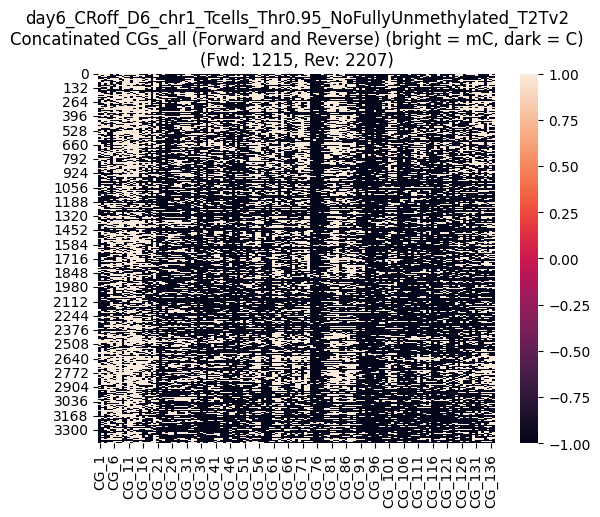

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



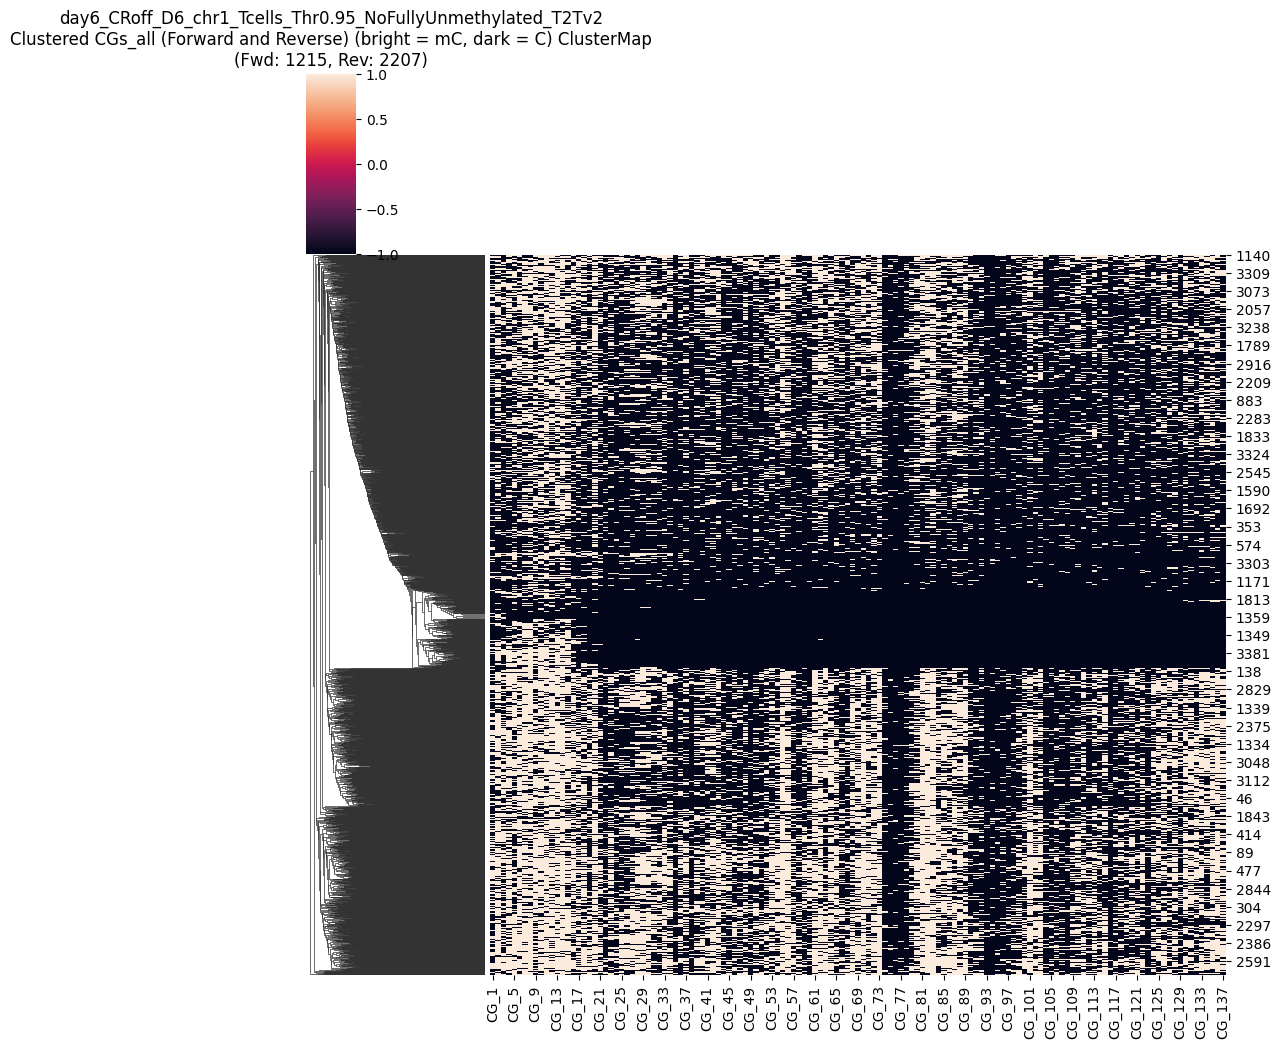

CGs_all saved as CG_137_padded_reads_day6_CRoff_D6_chr1_Tcells_Thr0.95_NoFullyUnmethylated_T2Tv2_mCthresh0.95_t2t_v2_0_chr1:206583354-206589854_2025-08-04_units_combined_numFWD1215_numRVS2207.npy in dimelo_v2_output
Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)


CG_1  CG_2  CG_3  CG_4  CG_5  CG_6  CG_7  CG_8  CG_9  CG_10  ...  \
0      1.0   1.0   NaN   1.0   NaN   1.0   1.0   1.0   1.0    1.0  ...   
1      NaN   NaN   NaN   NaN   NaN   NaN   1.0   1.0   1.0    NaN  ...   
2      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN  ...   
3      NaN   NaN   NaN   1.0   NaN   NaN   1.0   NaN   1.0    NaN  ...   
4      NaN   1.0   1.0   1.0   NaN   NaN   1.0   NaN   1.0    1.0  ...   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...    ...  ...   
3417   NaN   1.0   NaN   NaN   1.0   NaN   NaN   1.0   1.0    1.0  ...   
3418   1.0   1.0   NaN   1.0   1.0   NaN   1.0   1.0   1.0    1.0  ...   
3419   NaN   1.0   NaN   1.0   1.0   NaN   1.0   1.0   1.0    NaN  ...   
3420   NaN   1.0   1.0   1.0   1.0   1.0   NaN   1.0   NaN    1.0  ...   
3421   NaN   NaN   NaN   1.0   1.0   NaN   1.0   1.0   1.0    1.0  ...   

      CG_128  CG_129  CG_130  CG_131  CG_132  CG_133  CG_134  CG_135  CG_136  \
0        NaN     NaN     1.0     1.0     1.0     1.0     NaN     1.0     NaN   
1        1.0     NaN     1.0     NaN     NaN     NaN     NaN     1.0     NaN   
2        NaN     NaN     NaN     NaN     NaN     1.0     NaN     NaN     1.0   
3        1.0     NaN     1.0     NaN     1.0     1.0     NaN     NaN     NaN   
4        1.0     NaN     1.0     1.0     NaN     1.0     1.0     1.0     1.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
3417     NaN     1.0     1.0     1.0     NaN     NaN     1.0     1.0     1.0   
3418     1.0     NaN     NaN     1.0     1.0     1.0     1.0     NaN     1.0   
3419     1.0     1.0     1.0     1.0     NaN     1.0     NaN     NaN     NaN   
3420     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3421     NaN     NaN     1.0     NaN     NaN     NaN     1.0     NaN     1.0   

      CG_137  
0        1.0  
1        NaN  
2        1.0  
3        NaN  
4        NaN  
...      ...  
3417     NaN  
3418     1.0  
3419     NaN  
3420     NaN  
3421     NaN  

[3422 rows x 137 columns]

In [17]:

! pwd
unedit_bam_path
threshold_mC =  0.95 
experiment_name = "day6_CRoff_D6_chr1_Tcells_Thr"+str(threshold_mC)+"_NoFullyUnmethylated_T2Tv2"
bam_path = unedit_bam_path

print('experiment_name = ', experiment_name)

save_padded_reads_name_np = f"padded_reads_{experiment_name}_mCthresh{threshold_mC}_{reg_genome_version}_{region_str}_{date_today}.npy"
output_dir = create_output_directory("./dimelo_v2_output")

extract_file, extract_regions = extract_from_bam(
    experiment_name = experiment_name,
    bam_path=bam_path,
    ref_genome_file=ref_genome_path,
    output_dir=output_dir,
    regions=region_str,
    motifs=motifs,
    output_name='extracted_reads',
    threshold_mC=threshold_mC,
)
keep_full_coverage_reads_only=True

if extract_file:
    reads_df, regions_dict = process_extracted_reads(extract_file, region_str, motifs, ref_seq_list, 
    keep_full_coverage_reads_only=keep_full_coverage_reads_only)
    visualize_data(reads_df)

    padded_reads = create_padded_reads(reads_df, regions_dict, region_length)
    if padded_reads is not None:
        plot_padded_reads(padded_reads, ref_seq_list)
        save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np)

# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_CRoff_D6_mc095_original = CGs_all
CGs_all_CRoff_D6_mc095_original

In [ ]:

threshold_percent = 80
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_CRoff_D6_mc095_remove_low80 = CGs_all
CGs_all_CRoff_D6_mc095_remove_low80

threshold_percent = 70
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_CRoff_D6_mc095_remove_low70 = CGs_all
CGs_all_CRoff_D6_mc095_remove_low70

threshold_percent = 50
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_CRoff_D6_mc095_remove_low50 = CGs_all
CGs_all_CRoff_D6_mc095_remove_low50

threshold_percent = 10
filtered_reads_df, methylation_counts = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

save_padded_reads_name_np_remove_low_methylated = 'removed_low'+str(threshold_percent)+'_methylated_' + save_padded_reads_name_np

padded_reads = create_padded_reads(filtered_reads_df, regions_dict, region_length)
if padded_reads is not None:
    plot_padded_reads(padded_reads, ref_seq_list)
    save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np_remove_low_methylated)


# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np_remove_low_methylated, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")

CGs_all_CRoff_D6_mc095_remove_low10 = CGs_all
CGs_all_CRoff_D6_mc095_remove_low10

CGs_all_pd = CGs_all_CRoff_D6_mc095_remove_low80
CGs_all_095_remove_low80_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_095_remove_low80_frac = CGs_all_095_remove_low80_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_CRoff_D6_mc095_remove_low70
CGs_all_095_remove_low70_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_095_remove_low70_frac = CGs_all_095_remove_low70_sums  / len(CGs_all_pd) 


CGs_all_pd = CGs_all_CRoff_D6_mc095_remove_low50
CGs_all_095_remove_low50_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_095_remove_low50_frac = CGs_all_095_remove_low50_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_CRoff_D6_mc095_remove_low10
CGs_all_095_remove_low10_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_095_remove_low10_frac = CGs_all_095_remove_low10_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_CRoff_D6_mc095_original
CGs_all_mc095_orifinal_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_mc095_orifinal_frac = CGs_all_mc095_orifinal_sums  / len(CGs_all_pd) 



plt.figure(figsize=(16, 5))
plt.bar(np.arange(len(CGs_all_095_remove_low80_frac)), CGs_all_095_remove_low80_frac, snap=False, alpha=0.5, label='mC threshold 95%, >80% * mean(mC)')
plt.bar(np.arange(len(CGs_all_095_remove_low70_sums)), CGs_all_095_remove_low70_frac, snap=False, alpha=0.5, label='mC threshold 95%, >70% * mean(mC)')
plt.bar(np.arange(len(CGs_all_095_remove_low50_frac)), CGs_all_095_remove_low50_frac, snap=False, alpha=0.5, label='mC threshold 95%, >50% * mean(mC)')
plt.bar(np.arange(len(CGs_all_095_remove_low10_frac)), CGs_all_095_remove_low10_frac, snap=False, alpha=0.5, label='mC threshold 95%, >10% * mean(mC)')
plt.bar(np.arange(len(CGs_all_mc095_orifinal_frac)), CGs_all_mc095_orifinal_frac, snap=False, alpha=0.5, label='mC threshold 95%, original')

# Add labels and title
plt.xlabel('CpG units')
plt.ylabel('Fraction of mC')
plt.title('Fraction of mC for Unedited T cells CGs')
plt.legend()



Mean methylated CGs per read: 46.0
Maximum methylated CGs per read: 97.0
Threshold (80% of max): 36.80
Original number of reads: 3422
Number of reads after filtering: 2176
Removed 1246 reads


In [ ]:
CGs_all_pd = CGs_all_unedited_mc0995_remove_low70
CGs_all_unedited_0995_remove_low70_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_unedited_0995_remove_low70_frac = CGs_all_unedited_0995_remove_low70_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_unedited_mc095_remove_low70
CGs_all_unedited_095_remove_low70_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_unedited_095_remove_low70_frac = CGs_all_unedited_095_remove_low70_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_unedited_mc09_remove_low70
CGs_all_unedited_09_remove_low70_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_unedited_09_remove_low70_frac = CGs_all_unedited_09_remove_low70_sums  / len(CGs_all_pd) 

CGs_all_pd = CGs_all_unedited_mc07_remove_low70
CGs_all_unedited_07_remove_low70_sums = np.nansum(CGs_all_pd, axis=0) 
CGs_all_unedited_07_remove_low70_frac = CGs_all_unedited_07_remove_low70_sums  / len(CGs_all_pd) 

plt.figure(figsize=(16, 5))
plt.bar(np.arange(len(CGs_all_unedited_07_remove_low70_sums)), CGs_all_unedited_07_remove_low70_frac, snap=False, alpha=0.5, label='mC threshold 70%, >70% * mean(mC)')
plt.bar(np.arange(len(CGs_all_unedited_09_remove_low70_sums)), CGs_all_unedited_09_remove_low70_frac, snap=False, alpha=0.5, label='mC threshold 90%, >70% * mean(mC)')
plt.bar(np.arange(len(CGs_all_unedited_095_remove_low70_sums)), CGs_all_unedited_095_remove_low70_frac, snap=False, alpha=0.5, label='mC threshold 95%, >70% * mean(mC)')
plt.bar(np.arange(len(CGs_all_unedited_095_remove_low70_sums)), CGs_all_unedited_095_remove_low70_frac, snap=False, alpha=0.5, label='mC threshold 99.5%, >70% * mean(mC)')

# Add labels and title
plt.xlabel('CpG units')
plt.ylabel('Fraction of mC')
plt.title('Fraction of mC for Unedited T cells CGs')
plt.legend()

# Show the plot
plt.show()